# Project 2 - Term Deposit Classification
# Background:

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

## Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

## Attributes:

- age : age of customer (numeric)
- job : type of job (categorical)
- marital : marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- Output (desired target):
- y - has the client subscribed to a term deposit? (binary)

## Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)
Success Metric(s):

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.
Current Challenges:

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.
What makes the customers buy? Tell us which feature we should be focusing more on.

# 1. Setup

In [3]:
# Standard Library
import os
# import random  # Uncomment if needed

# Core Data Handling
import numpy as np
import pandas as pd
import duckdb

# Visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Statistical Modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# General ML Frameworks
import lazypredict
from lazypredict.Supervised import LazyClassifier

# Transformations & Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

# Modeling & Training
# from sklearn.utils import shuffle
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression  # for ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron

# dimension reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# optimization
from sklearn.model_selection import GridSearchCV

# Evaluation Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report

# Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

# Hyper Parameter Tuning
from hyperopt import fmin, tpe, hp, STATUS_OK
from hyperopt.pyll.base import scope
from hyperopt import space_eval
import optuna

# unsupervised models
import gower
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN

In [5]:
# Setup Environment and Data

seed = 6932
np.random.seed(seed)

# Show all rows and columns
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  # Adjust width for long outputs

# set directory
path = r'E:\My Stuff\Projects\Apziva\4132339939'
os.chdir(path)

# load data
df = pd.read_csv('term-deposit-marketing-2020.csv')

# 2. Exploratory

In [4]:
# Create Masks for Data Types -------------------------------------------------

_cols_categorical = [
    col for col, dtype in df.dtypes.items() if dtype == 'O' and col != 'y'
    ]

_cols_numerical = [
    col for col, dtype in df.dtypes.items() if not dtype == 'O' and col != 'y'
    ]
# -----------------------------------------------------------------------------

df.describe()

age   balance      day  duration  campaign
count 40000.00  40000.00 40000.00  40000.00  40000.00
mean     40.54   1274.28    16.02    254.82      2.88
std       9.64   2903.77     8.28    259.37      3.24
min      19.00  -8019.00     1.00      0.00      1.00
25%      33.00     54.00     8.00    100.00      1.00
50%      39.00    407.00    17.00    175.00      2.00
75%      48.00   1319.00    21.00    313.00      3.00
max      95.00 102127.00    31.00   4918.00     63.00

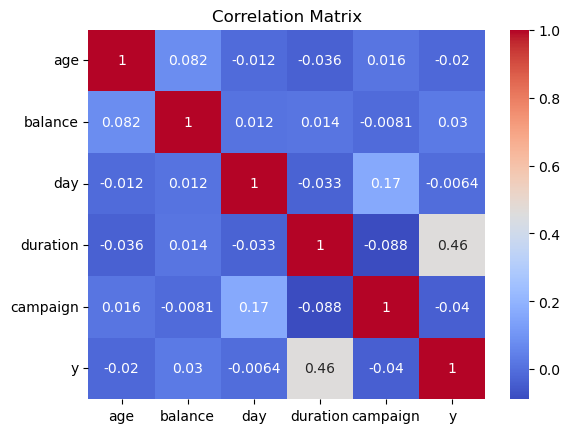

In [5]:
# Corr Matrix -----------------------------------------------------------------
df_temp = df.copy()
df_temp['y'] = df['y'].replace({'yes': 1, 'no': 0})
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
# -----------------------------------------------------------------------------

- Duration has a strong positive effect.

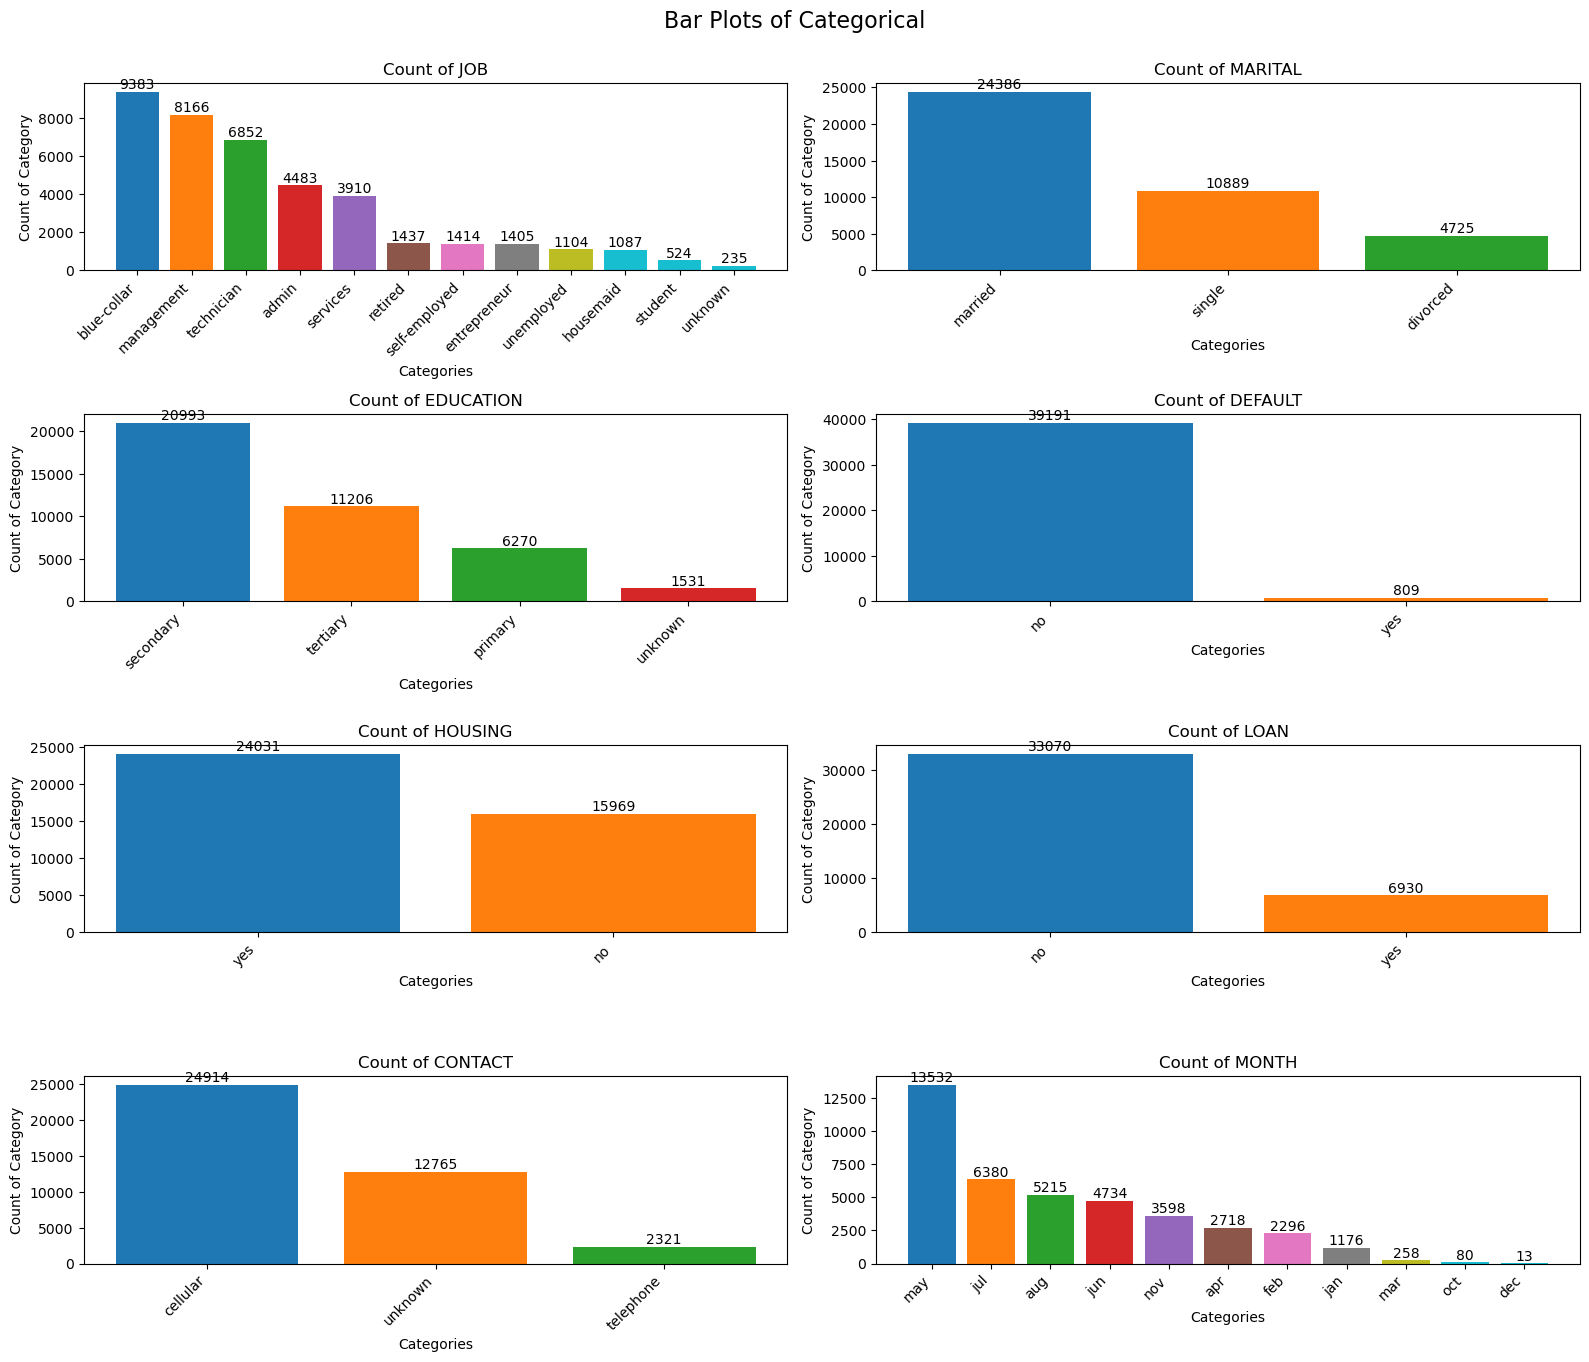

In [6]:
# Bar Plots -------------------------------------------------------------------
'''
Bar plots for each categorical variable to show the count of each class
'''

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(16, 16))

# Flatten the axes array to match with categorical columns
axes_flat = axes.flatten()

# Iterate through the flattened axes and categorical columns
for ax, column in zip(axes_flat, _cols_categorical):
    _data = dict(df[column].value_counts())
    _classes = _data.keys()
    _values = _data.values()

    # Create a unique color for each class
    colors = plt.cm.tab10(np.arange(len(_classes)))

    # Group bars by class and create a bar plot
    bars = ax.bar(_classes, _values, color=colors)

    ax.set_title(f'Count of {column.upper()}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count of Category')

    # Add labels on each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval),
                ha='center', va='bottom')  # Position label above the bar

    # Rotate x-axis labels
    ax.set_xticklabels(_classes, rotation=45, ha='right')

# Remove empty subplots if any (if _cols_categorical has fewer than 8 columns)
for i in range(len(_cols_categorical), len(axes_flat)):
    fig.delaxes(axes_flat[i])

fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

Seems fairly representative of the population. Odd thing to note, huge amount of people called in May? Tax season in Europe seems to be March-May (Filing start dates and deadlines), so maybe in April after most people have filed their taxes they call in May?

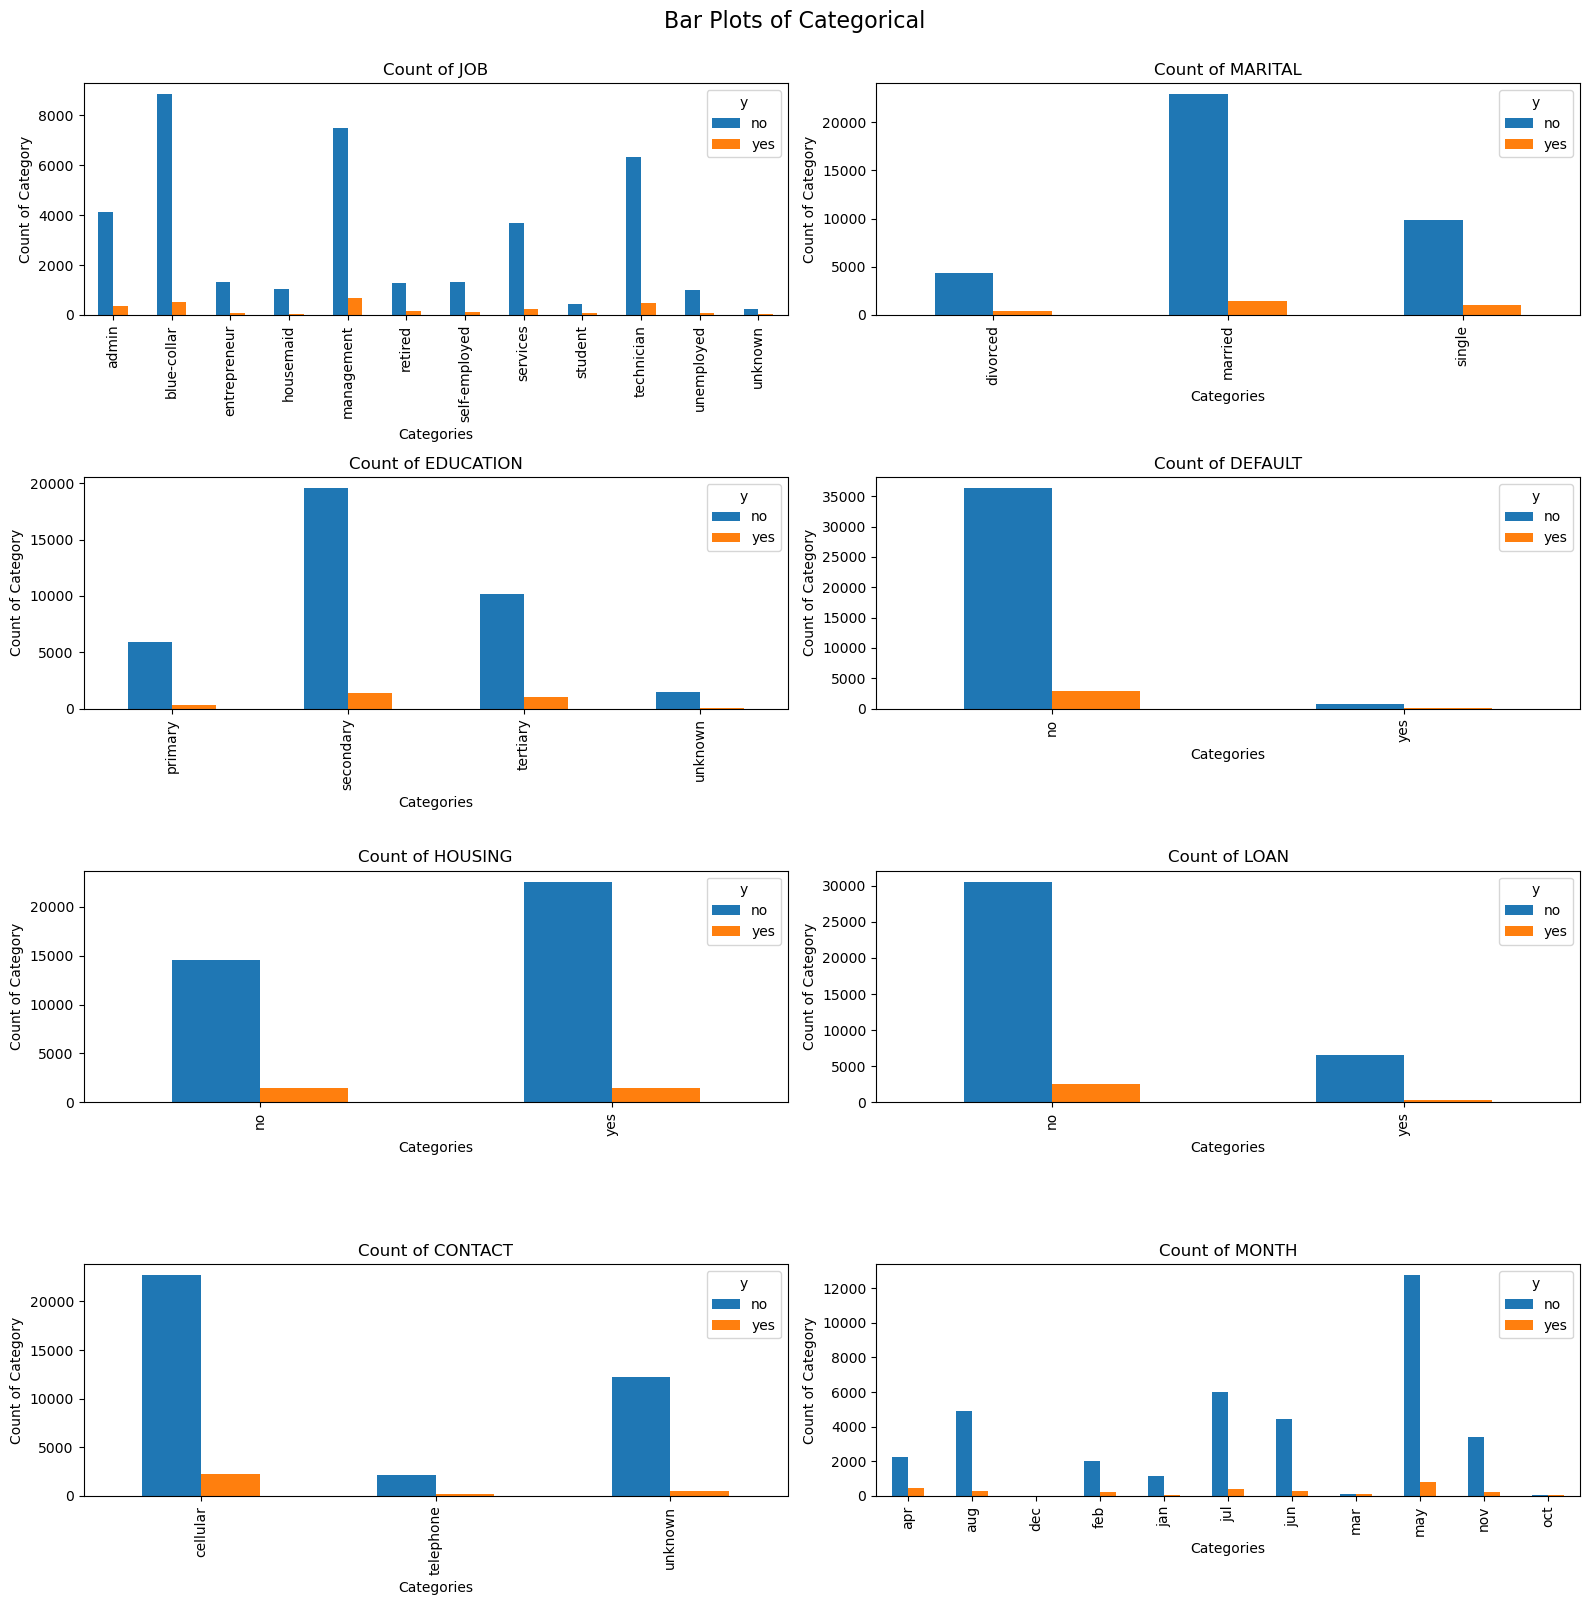

In [7]:
# Grouped Bar Plots -----------------------------------------------------------
'''
Grouped bar plots for each categorical variable to show the count of each class
'''

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

# Flatten the axes array to match with categorical columns
axes_flat = axes.flatten()

# Iterate through the flattened axes and categorical columns
for ax, column in zip(axes_flat, _cols_categorical):
    _group = df.groupby([column, 'y'])[column].count()
    _group.name = 'value'
    _data = _group.reset_index()
    _pivot = _data.pivot_table(
        index=_data.columns[0],
        columns=_data.columns[1],
        values='value'
        )
    _pivot.plot(kind='bar', stacked=False, ax=ax)

    ax.set_title(f'Count of {column.upper()}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count of Category')

fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

The amount of people that have actually subscribed to term deposits is extremely small when compared across classes in each plot.

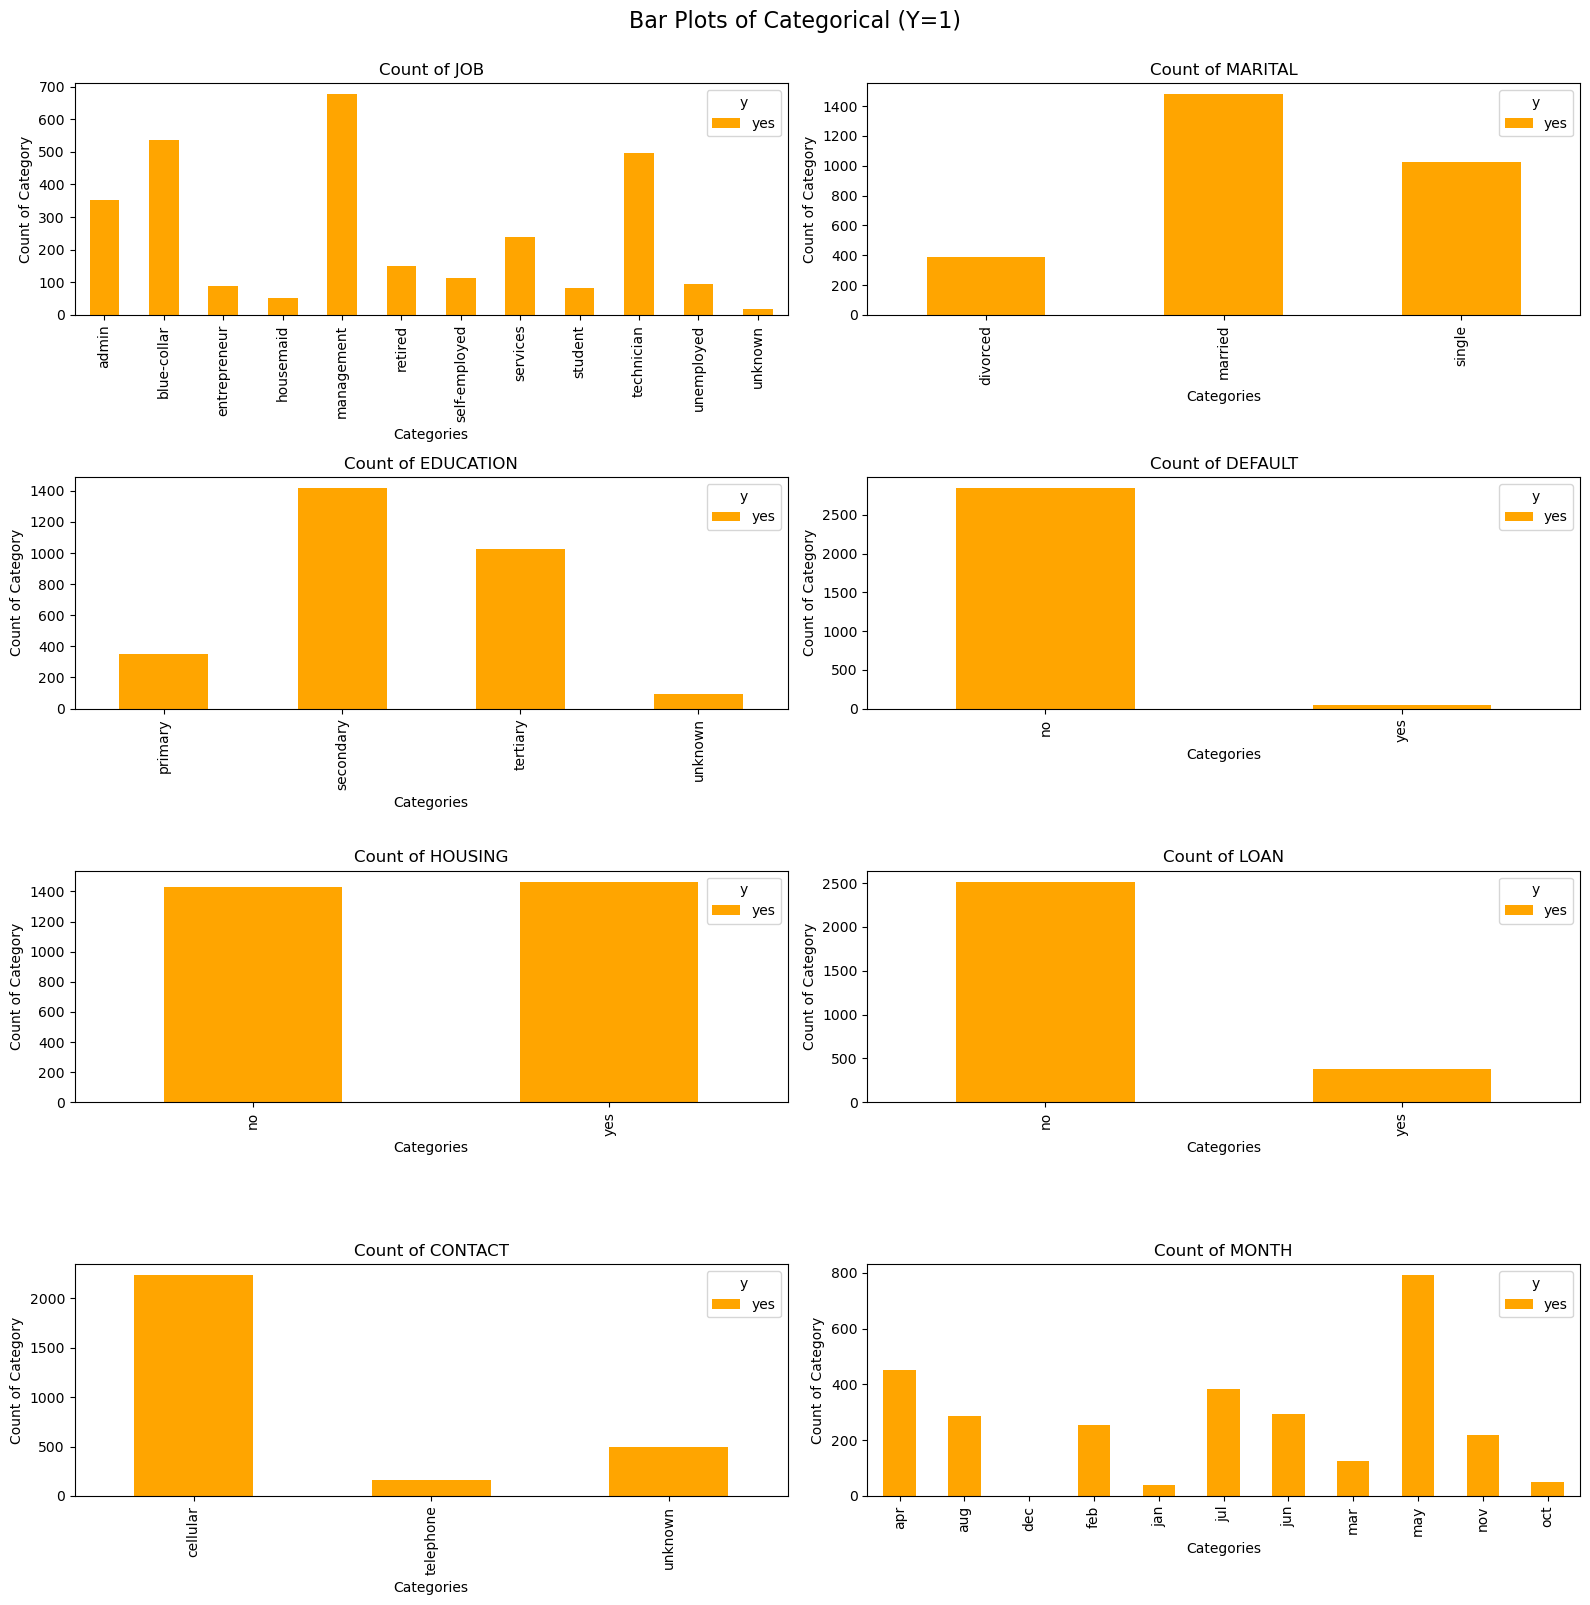

In [9]:
# Bar Plot Y=1 ----------------------------------------------------------------
# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

# Flatten the axes array to match with categorical columns
axes_flat = axes.flatten()

# Iterate through the flattened axes and categorical columns
for ax, column in zip(axes_flat, _cols_categorical):
    _group = df.groupby([column, 'y'])[column].count()
    _group.name = 'value'
    _data = _group.reset_index()
    _data = _data[_data['y'] == 'yes']
    _pivot = _data.pivot_table(
        index=_data.columns[0],
        columns=_data.columns[1],
        values='value'
        )
    _pivot.plot(kind='bar', stacked=False, ax=ax, color='orange')

    ax.set_title(f'Count of {column.upper()}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count of Category')

fig.suptitle("Bar Plots of Categorical (Y=1)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

Some observations.
 - mostly in roles such as management, blue-collar, technicians, admin.
 - mostly married.
 - most has a secondary education, but also a large portion have tertiary as well.
 - most have no defaults.
 - housing loans is split.
 - most don't have a loan.
 - Mostly using celluar phones.

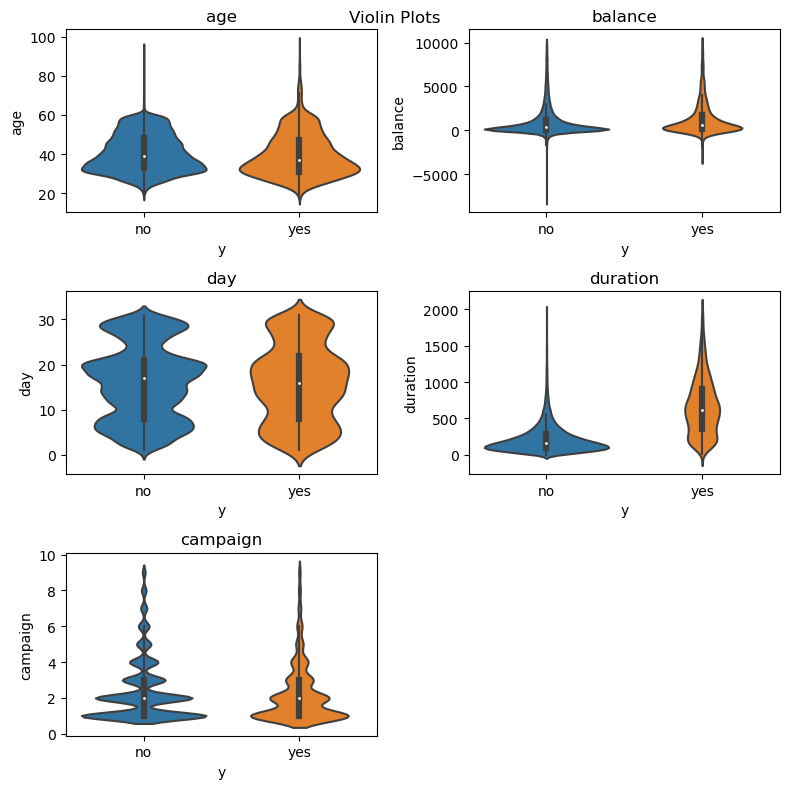

In [10]:
# Violin Plots for Numerical Columns ------------------------------------------
fig_violin, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    try:

        _col = _cols_numerical[i]

        cutoff = {
            'balance': 10000,
            'duration': 2000,
            'campaign': 10
            }

        if _col in cutoff.keys():

            rows = df[_col] < int(cutoff[_col])
            _ydata = df.loc[rows, _col]
            _xdata = df.loc[rows, 'y']

        else:
            _ydata = df.loc[:, _col]
            _xdata = df['y']

        sns.violinplot(x=_xdata, y=_ydata, ax=ax)
        ax.set_title(f"{_col}")

    except Exception:
        ax.axis('off')

plt.tight_layout()
fig_violin.suptitle("Violin Plots")
plt.show()
# -----------------------------------------------------------------------------

Nothing too polarizing except for duration. Customers have longer calls, probably to finalize some details or having a longer call in general because they are interested.

In [11]:
# Mean of y -------------------------------------------------------------------
y_df = df['y'].replace({'yes': 1, 'no': 0})

y_df.value_counts()
# -----------------------------------------------------------------------------

0    37104
1     2896
Name: y, dtype: int64

In [12]:
y_df.mean()

0.0724

Super small mean of y at 0.0724. Only 2896 of out 40000 customers are subscribed to a term deposit.

# 3. Regression Results
    
## 3.1 Single Regressions

In [12]:
%%capture

# Logistic Regressions
'''
- run single regressions
- review results
'''

# Single Logistic Regressions Function ----------------------------------------
'''
Function to run each indepent variable on the dependent.
'''


def run_single_regressions(y_df, x_df):
    results = []
    pred = []
    models = []

    for col in x_df.columns:
        X = x_df[col]
        y = df['y'].replace({'yes': 1, 'no': 0})

        if X.dtype == 'O':
            dummies = pd.get_dummies(X, drop_first=True)
            X = pd.concat([dummies], axis=1)

        X = sm.add_constant(X)

        # Fit the regression model
        model = sm.Logit(y, X).fit()
        models.append(model)

        # Predict
        pred.append(model.predict(X))

        # Collect the results
        results.append({
            'Variable': col,
            'Coefficient': model.params[1],
            'Intercept': model.params[0],
            'P-Value': model.pvalues[1],
            # 'R-Squared': model.rsquared
        })
    return results, pred, models


# -----------------------------------------------------------------------------

# Return results --------------------------------------------------------------
results, pred, models = run_single_regressions(
    df['y'], df[df.columns[0:-1]]
    )

dfresults = summary_col(models, stars=True, float_format='%0.4f')


# dfresults.tables[0].to_csv("result_tables.csv")
# -----------------------------------------------------------------------------

In [13]:
dfresults

<class 'statsmodels.iolib.summary2.Summary'>
"""

===========================================================================================================================================================================
                 y I        y II      y III      y IIII    y IIIII    y IIIIII  y IIIIIII  y IIIIIIII y IIIIIIIII y IIIIIIIIII y IIIIIIIIIII y IIIIIIIIIIII y IIIIIIIIIIIII
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
age           -0.0082***                                                                                                                                                   
              (0.0020)                                                                                                                                                     
aug                                                                                                                            -1.2248***                                  
                                                                                                                               (0.0796)                                    
balance                                                              0.0000***                                                                                             
                                                                     (0.0000)                                                                                              
blue-collar              -0.3399***                                                                                                                                        
                         (0.0712)                                                                                                                                          
campaign                                                                                                                                                    -0.0704***     
                                                                                                                                                            (0.0087)       
const         -2.2189*** -2.4657*** -2.4055*** -2.8191*** -2.5468*** -2.5912*** -2.3176*** -2.4968*** -2.3182***  -2.5027***   -1.6147***    -4.1599***     -2.3652***     
              (0.0834)   (0.0556)   (0.0528)   (0.0548)   (0.0195)   (0.0208)   (0.0277)   (0.0207)   (0.0222)    (0.0417)     (0.0516)      (0.0383)       (0.0286)       
day                                                                                                               -0.0030                                                  
                                                                                                                  (0.0023)                                                 
dec                                                                                                                            -0.8702                                     
                                                                                                                               (1.0421)                                    
duration                                                                                                                                     0.0043***                     
                                                                                                                                             (0.0001)                      
entrepreneur             -0.2400*                                                                                                                                          
                         (0.1233)                                                                                                                                     

Results tend to point at individuals who have low risk tolerance would also have term deposits; unemployed, higher balance, more education, older age, and no debts or loans.

We also see that a unit increases in duration leads to a higher probability of conversion, with statistical significance. The impact is fairly small per unit, but duration is measured in seconds; average duration is around 254 seconds. However, is the probability higher because they are actually converting a customer onto a term deposit or is the customer already interested in term deposits, and thus the conversation goes on longer?

## 3.2 Multivariate Regressions

In [17]:
%%capture

# Multivariate Logistic Regressions
'''
More risk averse individuals I think would typically be:
    - job: low skill, low education, unemployed, etc...
'''

# Variables
reg_results = {}
data = df.copy()
data['y'] = data['y'].replace({'yes': 1, 'no': 0})

# duration ~ job --------------------------------------------------------------
reg1 = "duration~job"
reg_results[reg1] = smf.ols(reg1, data=data).fit()
# -----------------------------------------------------------------------------

# duration ~ 'Kitchen Sink' ---------------------------------------------------
cols = list(df.columns)
cols.remove('duration')
reg2 = f"duration~{('+').join(cols)}"
reg_results[reg2] = smf.ols(reg2, data=data).fit()
# -----------------------------------------------------------------------------

# y ~ duration ----------------------------------------------------------------
reg3 = "y~duration"
reg_results[reg3] = smf.logit(reg3, data=data).fit()
# -----------------------------------------------------------------------------

# y ~ balance -----------------------------------------------------------------
# data_temp = data.copy()
# data_temp['balance'] = np.log(data['balance'] - + min(data['balance']) + 1)
reg4 = 'y~balance'
reg_results[reg4] = smf.logit(reg4, data=data).fit()
# -----------------------------------------------------------------------------

# y ~ 'Kitchen Sink'  ---------------------------------------------------------
cols = list(df.columns)
cols.remove('y')
reg5 = f"y~{('+').join(cols)}"
reg_results[reg5] = smf.logit(reg5, data=data).fit()
# -----------------------------------------------------------------------------

# duration ~ y ----------------------------------------------------------------
reg6 = 'duration~y'
reg_results[reg6] = smf.ols(reg6, data=df).fit()
# -----------------------------------------------------------------------------

In [21]:
%%capture

# reg2 = f"duration~{('+').join(cols)}"

"""

===================================
                         duration  
-----------------------------------
Intercept              262.3027*** 
                       (10.4793)   
job[T.blue-collar]     22.1662***  
                       (4.3282)    
job[T.entrepreneur]    16.9851**   
                       (7.1158)    
job[T.housemaid]       21.4047***  
                       (7.9267)    
job[T.management]      7.4751      
                       (4.9392)    
job[T.retired]         16.3249**   
                       (7.3258)    
job[T.self-employed]   25.4981***  
                       (7.0906)    
job[T.services]        13.4851***  
                       (4.9729)    
job[T.student]         -35.1801*** 
                       (10.7341)   
job[T.technician]      6.7442      
                       (4.4399)    
job[T.unemployed]      37.1241***  
                       (7.7139)    
job[T.unknown]         0.1927      
                       (15.4869)   
marital[T.married]     -2.7247     
                       (3.6544)    
marital[T.single]      -0.6694     
                       (4.2277)    
education[T.secondary] 4.1575      
                       (3.6057)    
education[T.tertiary]  -1.0385     
                       (4.6007)    
education[T.unknown]   8.4922      
                       (6.6567)    
default[T.yes]         -16.3543**  
                       (8.1137)    
housing[T.yes]         14.8526***  
                       (2.7628)    
loan[T.yes]            0.5798      
                       (3.0842)    
contact[T.telephone]   -27.3404*** 
                       (5.0843)    
contact[T.unknown]     50.3784***  
                       (3.7954)    
month[T.aug]           7.0610      
                       (5.7954)    
month[T.dec]           -122.2162*  
                       (63.1606)   
month[T.feb]           -44.3334*** 
                       (6.8225)    
month[T.jan]           64.6400***  
                       (8.2371)    
month[T.jul]           36.0642***  
                       (5.3576)    
month[T.jun]           -56.4108*** 
                       (6.8015)    
month[T.mar]           -216.6404***
                       (14.9264)   
month[T.may]           -19.3713*** 
                       (5.3103)    
month[T.nov]           11.0706*    
                       (5.8599)    
month[T.oct]           -177.6157***
                       (26.0737)   
age                    -0.6551***  
                       (0.1437)    
balance                0.0010**    
                       (0.0004)    
day                    -1.9660***  
                       (0.1646)    
campaign               -4.7173***  
                       (0.3716)    
y                      482.0197*** 
                       (4.5038)    
R-squared              0.2363      
R-squared Adj.         0.2356      
===================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

Y has a huge effect on duration with statistically significance at the highest level. Since it's so massive, it leads me to believe that it might be more likely that instead of duration predicting y it's leaking y. The call duration is longer because they are subscribing.

In [22]:
%%capture

# reg5 = f"y~{('+').join(cols)}"

"""

=================================
                           y     
---------------------------------
Intercept              -3.1687***
                       (0.2112)  
job[T.blue-collar]     -0.2821***
                       (0.0908)  
job[T.entrepreneur]    -0.3254** 
                       (0.1542)  
job[T.housemaid]       -0.7466***
                       (0.1960)  
job[T.management]      -0.1794*  
                       (0.0978)  
job[T.retired]         0.3090**  
                       (0.1384)  
job[T.self-employed]   -0.2688*  
                       (0.1442)  
job[T.services]        -0.2627** 
                       (0.1063)  
job[T.student]         0.2487    
                       (0.1672)  
job[T.technician]      -0.0946   
                       (0.0898)  
job[T.unemployed]      -0.3106** 
                       (0.1532)  
job[T.unknown]         0.1016    
                       (0.3108)  
marital[T.married]     -0.2937***
                       (0.0740)  
marital[T.single]      -0.0130   
                       (0.0839)  
education[T.secondary] 0.0584    
                       (0.0819)  
education[T.tertiary]  0.3149*** 
                       (0.0978)  
education[T.unknown]   -0.1297   
                       (0.1496)  
default[T.yes]         0.2990*   
                       (0.1728)  
housing[T.yes]         -0.6646***
                       (0.0567)  
loan[T.yes]            -0.2559***
                       (0.0708)  
contact[T.telephone]   -0.3916***
                       (0.1180)  
contact[T.unknown]     -1.9956***
                       (0.0908)  
month[T.aug]           -1.5223***
                       (0.1056)  
month[T.dec]           0.4654    
                       (1.0671)  
month[T.feb]           -0.0427   
                       (0.1131)  
month[T.jan]           -3.1138***
                       (0.2264)  
month[T.jul]           -1.4842***
                       (0.0936)  
month[T.jun]           0.7089*** 
                       (0.1313)  
month[T.mar]           2.1199*** 
                       (0.1533)  
month[T.may]           -0.2308***
                       (0.0822)  
month[T.nov]           -1.4623***
                       (0.1073)  
month[T.oct]           3.4873*** 
                       (0.2879)  
age                    -0.0023   
                       (0.0030)  
balance                0.0000**  
                       (0.0000)  
day                    0.0342*** 
                       (0.0036)  
duration               0.0049*** 
                       (0.0001)  
campaign               -0.0418***
                       (0.0111)  
=================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

Retired and higher education seems to have the strongest positive effects on indicating they would buy term deposits.

# 4. Machine Learning Models
## 4.1 First Layer Traininng and Prediction
### 4.1A Setup Data

After some thought, it seems like the variables duration (mostly this), and potentially day, month, and campaign could be leaking the answer to our model. From prior logistical regressions and exploratory data analysis, duration looks too strong of a predictor. And the other predictors, day, month, and campaign might be in a similar boat since it's related to the actual customer calls.

To address this issue, we will do a two layer approach. The first layer would be based on data not related to the last call and focus on the other variables. The goal of this model would be to remove as many customers that wouldn't be worth calling based on their background rather than their last call. Then, the second model would include the previously removed variables and focus on customers worth calling again based on the last call.

In [7]:
# Setup Data for First Layer
'''
hot-encoding
standardization
'''

# Setup X and y
X = df[df.columns[0:-1]]
y = df['y']
y = y.replace({'yes': 1, 'no': 0})

# Drop Columns
X = X.drop(columns=['duration', 'month', 'day', 'campaign'])


# Train and Test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=seed,
    stratify=y  # Ensures equal class distribution
)

# encoding

# Create Pipelines for numerical columns and categorical columns
num_pipeline = make_pipeline(
    StandardScaler()
)


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False),
)


# Create Preprocessing variable to apply pipelines
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=int)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

# Create Training Set and Test Set
X_train_t = preprocessing.fit_transform(X_train)
X_test_t = preprocessing.fit_transform(X_test)

X_train_t_df = pd.DataFrame(
    X_train_t,
    columns=preprocessing.get_feature_names_out(),
    index=X_train.index)


X_test_t_df = pd.DataFrame(
    X_test_t,
    columns=preprocessing.get_feature_names_out(),
    index=X_test.index)

# Create Full Set for Later... To Trim
X_trim = preprocessing.fit_transform(X)

X_trim_df = pd.DataFrame(
    X_trim,
    columns=preprocessing.get_feature_names_out(),
    index=X.index)


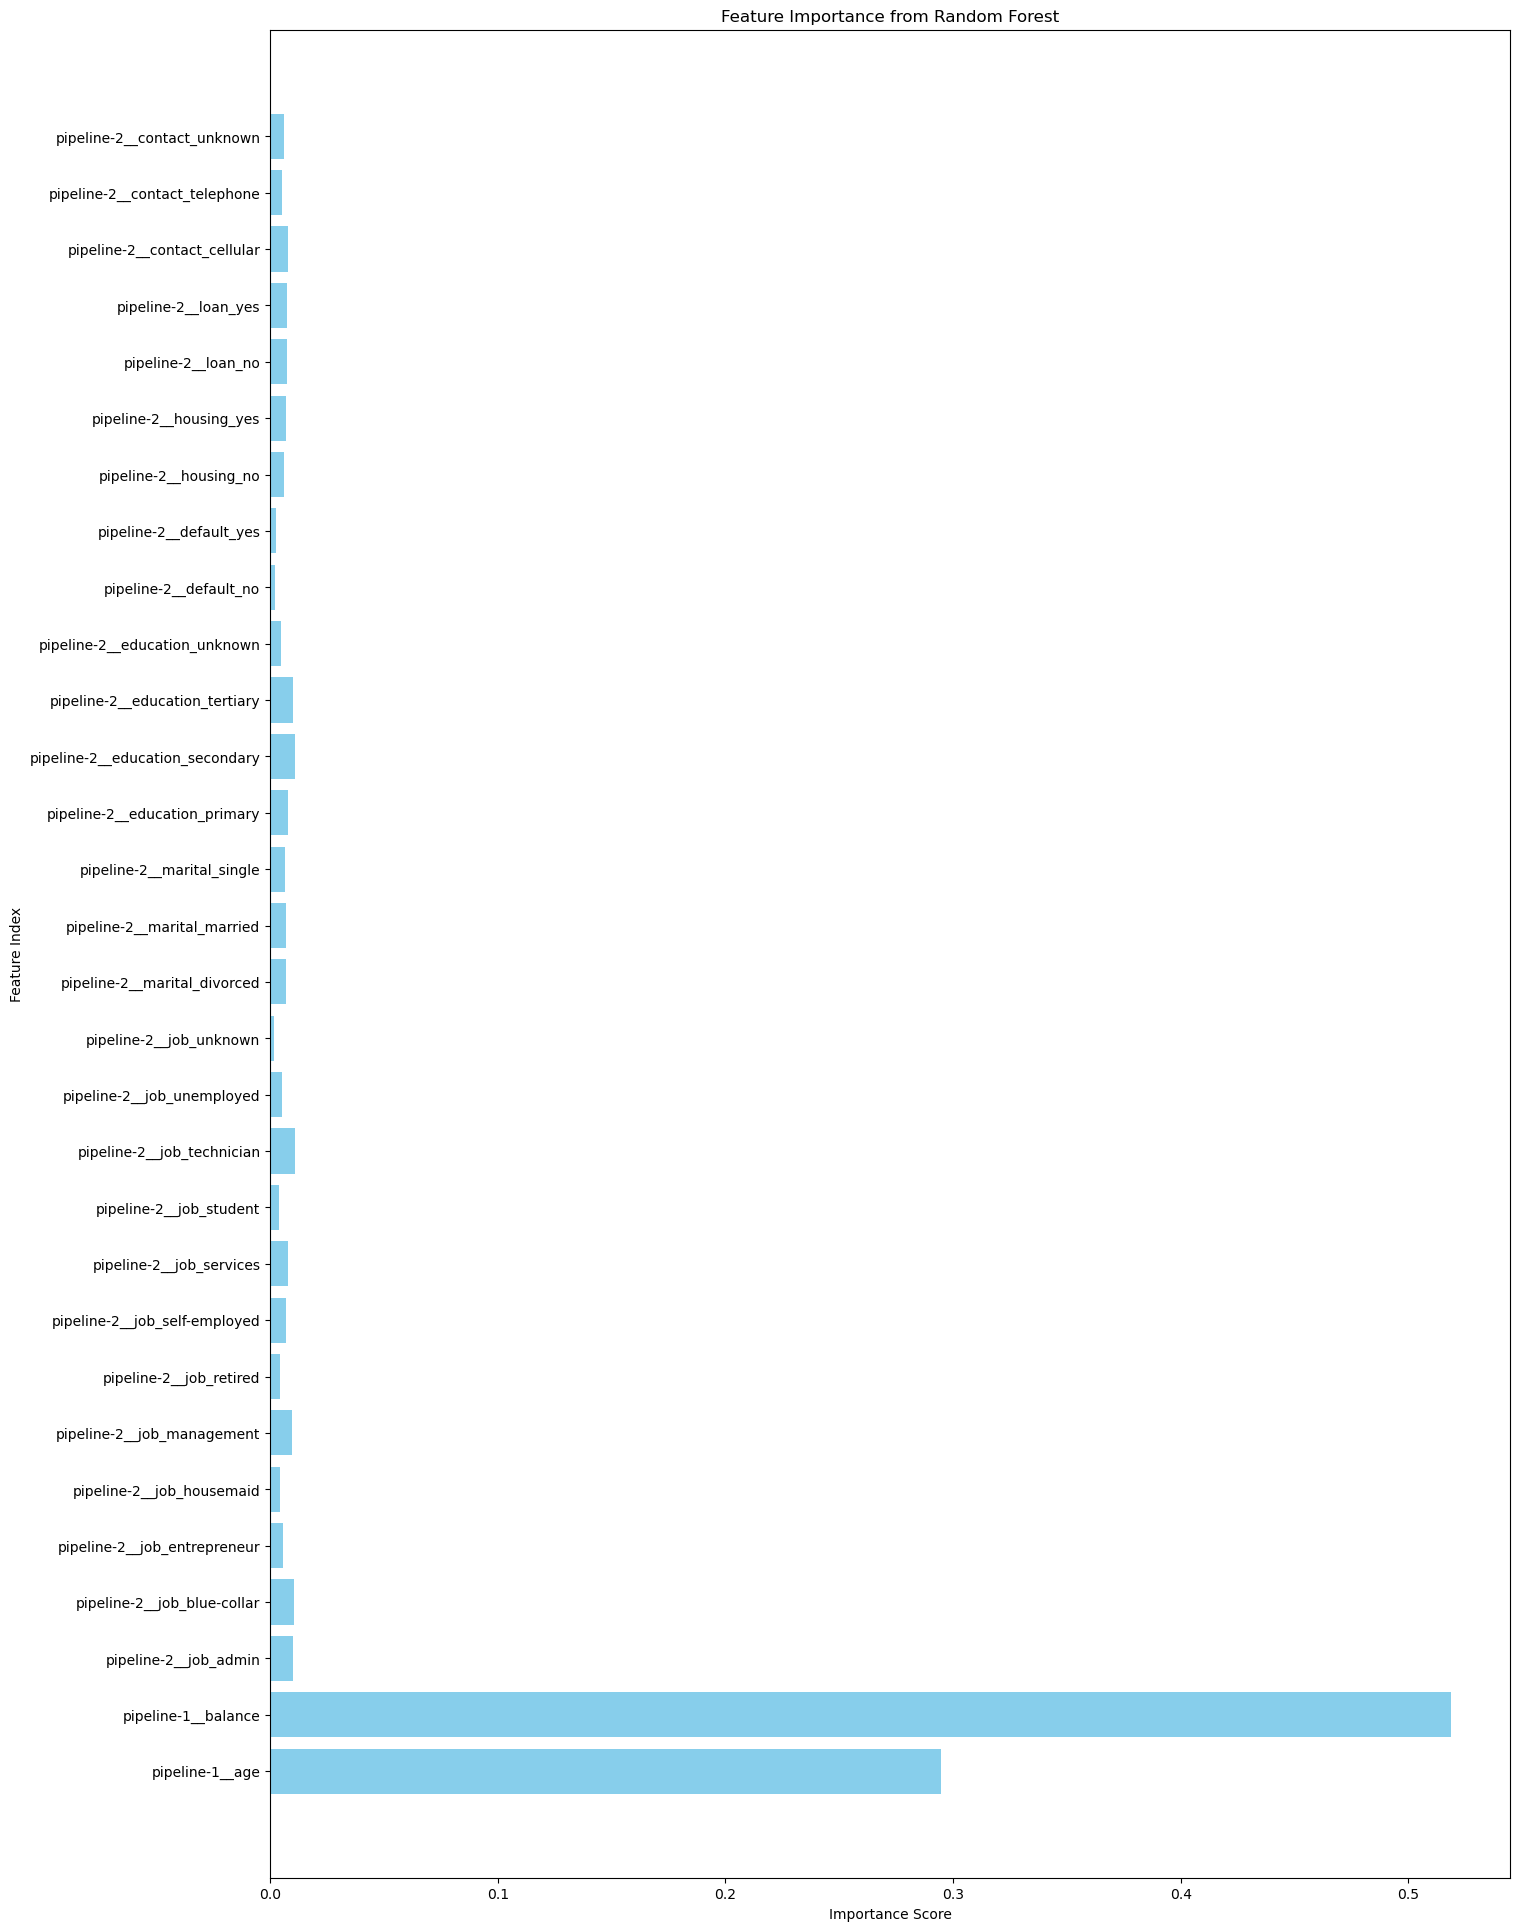

In [25]:
# Feature Importance

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=seed)
rf.fit(X_train_t_df, y_train)

# Get feature importance
importance = rf.feature_importances_

# Plot feature importance
plt.figure(figsize=(16, 24))

# Create a horizontal bar plot
plt.barh([x for x in range(len(importance))], importance, color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature Index")
plt.title("Feature Importance from Random Forest")
plt.yticks(range(len(importance)), labels=X_train_t_df.columns, fontsize=10)
plt.show()

Balance and age are now our most important predictors according to the model; before it was duration.

### 4.1B Model Selection

In [26]:
%%capture

# Model Selection - First Layer

# LazyPredict
clf = LazyClassifier(
    verbose=0,
    ignore_warnings=True,
    custom_metric=None,
    predictions=True,
    random_state=seed
    )

lazymodels, predictions = clf.fit(
    X_train_t_df,
    X_test_t_df,
    y_train,
    y_test
)

lazymodels = pd.DataFrame(lazymodels)

'''
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  Time Taken
Model
NearestCentroid                    0.59               0.60     0.60      0.68        4.09
GaussianNB                         0.88               0.55     0.55      0.88        0.12
QuadraticDiscriminantAnalysis      0.53               0.52     0.52      0.63        0.15
ExtraTreesClassifier               0.90               0.52     0.52      0.88        4.40
RandomForestClassifier             0.92               0.52     0.52      0.89        4.31
ExtraTreeClassifier                0.88               0.52     0.52      0.87        0.13
DecisionTreeClassifier             0.86               0.52     0.52      0.87        0.27
LabelSpreading                     0.91               0.51     0.51      0.89      116.01
BaggingClassifier                  0.92               0.51     0.51      0.89        1.50
LabelPropagation                   0.91               0.51     0.51      0.89       84.86
PassiveAggressiveClassifier        0.84               0.51     0.51      0.85        0.11
KNeighborsClassifier               0.92               0.51     0.51      0.89        1.98
AdaBoostClassifier                 0.93               0.51     0.51      0.89        1.59
XGBClassifier                      0.93               0.51     0.51      0.89        1.08
LGBMClassifier                     0.93               0.50     0.50      0.89        0.61
BernoulliNB                        0.93               0.50     0.50      0.89        0.14
LogisticRegression                 0.93               0.50     0.50      0.89        1.23
LinearDiscriminantAnalysis         0.93               0.50     0.50      0.89        0.74
DummyClassifier                    0.93               0.50     0.50      0.89        0.09
CalibratedClassifierCV             0.93               0.50     0.50      0.89       20.75
RidgeClassifier                    0.93               0.50     0.50      0.89        0.12
RidgeClassifierCV                  0.93               0.50     0.50      0.89        0.17
SGDClassifier                      0.93               0.50     0.50      0.89        0.22
SVC                                0.93               0.50     0.50      0.89       43.18
LinearSVC                          0.93               0.50     0.50      0.89        5.67
Perceptron                         0.86               0.50     0.50      0.86        0.11
'''

In [18]:
lazymodels

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  Time Taken
Model                                                                                    
NearestCentroid                    0.59               0.60     0.60      0.68        0.16
GaussianNB                         0.88               0.55     0.55      0.88        0.12
QuadraticDiscriminantAnalysis      0.53               0.52     0.52      0.63        0.15
ExtraTreesClassifier               0.90               0.52     0.52      0.88        4.17
RandomForestClassifier             0.92               0.52     0.52      0.89        4.05
ExtraTreeClassifier                0.88               0.52     0.52      0.87        0.11
DecisionTreeClassifier             0.86               0.52     0.52      0.87        0.24
LabelSpreading                     0.91               0.51     0.51      0.89      102.45
BaggingClassifier                  0.92               0.51     0.51      0.89        1.37
LabelPropagation                   0.91               0.51     0.51      0.89       82.90
PassiveAggressiveClassifier        0.84               0.51     0.51      0.85        0.12
KNeighborsClassifier               0.92               0.51     0.51      0.89        1.91
AdaBoostClassifier                 0.93               0.51     0.51      0.89        1.43
XGBClassifier                      0.93               0.51     0.51      0.89        1.01
LGBMClassifier                     0.93               0.50     0.50      0.89        0.57
BernoulliNB                        0.93               0.50     0.50      0.89        0.14
LogisticRegression                 0.93               0.50     0.50      0.89        0.13
LinearDiscriminantAnalysis         0.93               0.50     0.50      0.89        0.20
DummyClassifier                    0.93               0.50     0.50      0.89        0.08
CalibratedClassifierCV             0.93               0.50     0.50      0.89       19.32
RidgeClassifier                    0.93               0.50     0.50      0.89        0.11
RidgeClassifierCV                  0.93               0.50     0.50      0.89        0.16
SGDClassifier                      0.93               0.50     0.50      0.89        0.21
SVC                                0.93               0.50     0.50      0.89       41.26
LinearSVC                          0.93               0.50     0.50      0.89        5.35
Perceptron                         0.86               0.50     0.50      0.86        0.10

GaussianNB looks like the best choice to trim our data. NearestCentroid might be better, but it's a simpler model and harder to gauge probability from. However, since the dataset is fairly unbalanced, F1 should be a better score to use, and GaussianNB has the highest f1 by a large margin.

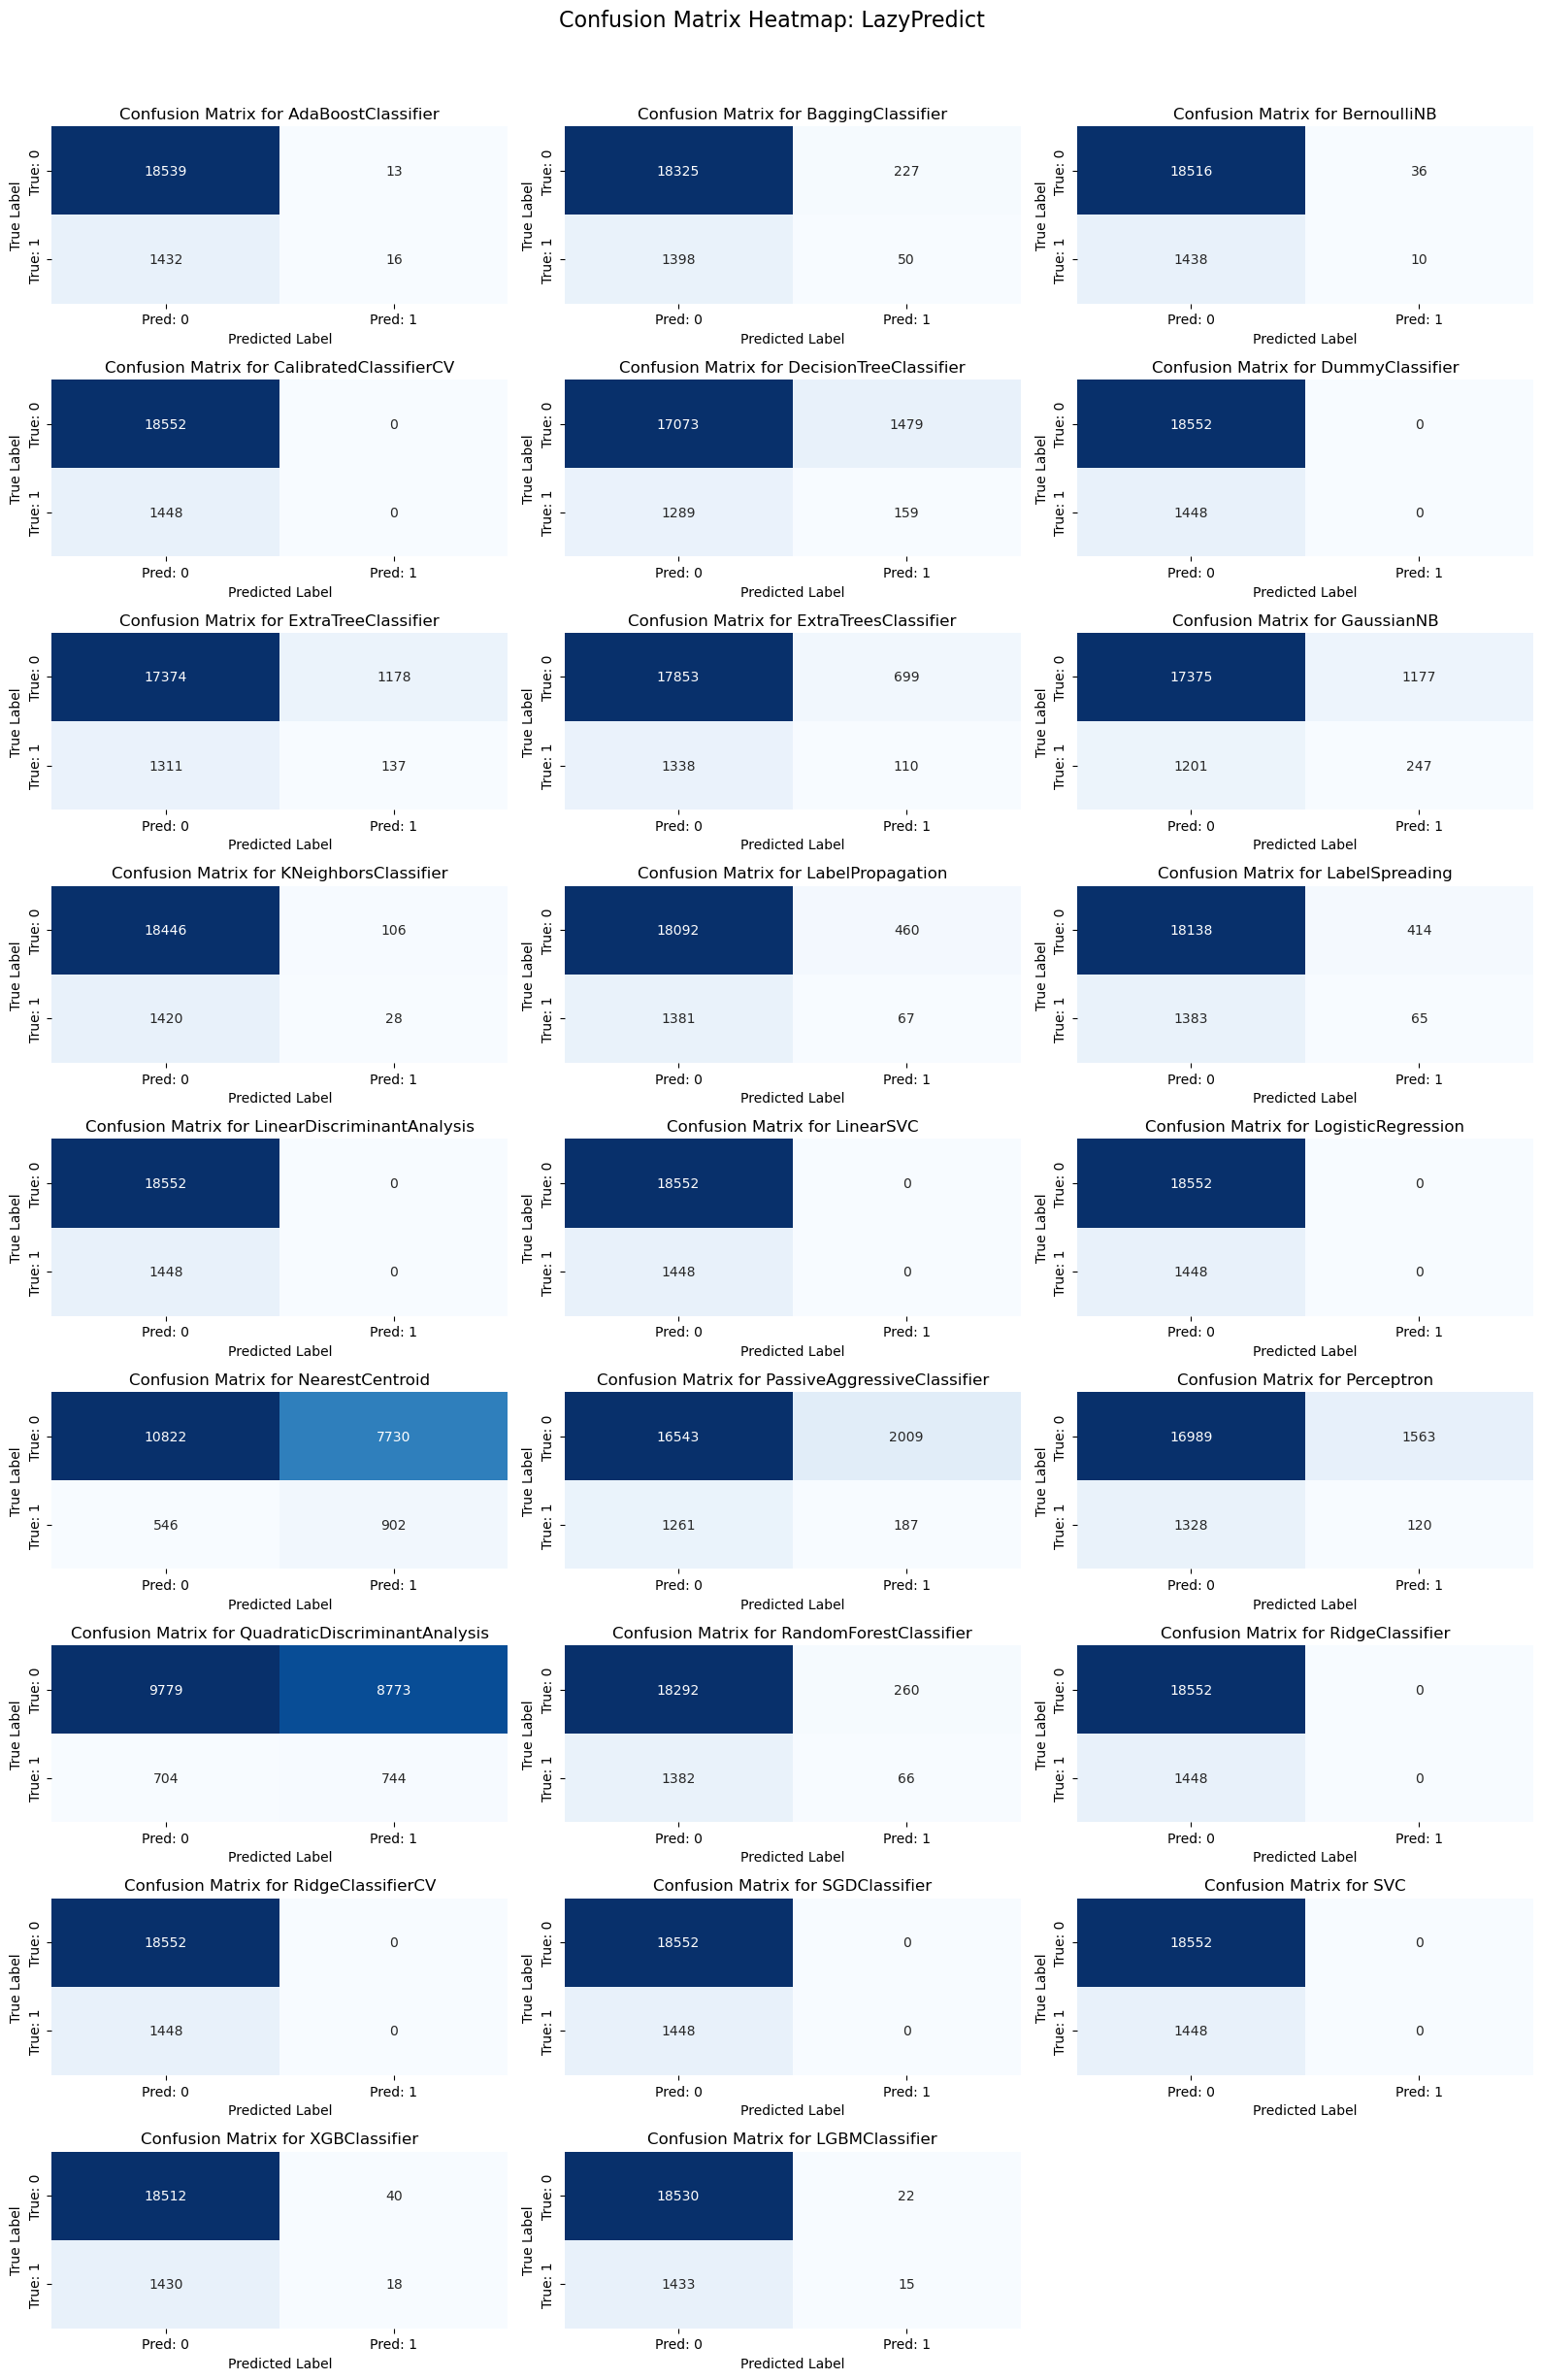

In [ ]:
# Figure for cms
fig_cm, axes = plt.subplots(9, 3, figsize=(16, 24))

cm_results = {}

# Get predictions for each model
for i, ax in enumerate(axes.flat):
    try:
        # get model and pred data
        model_name = predictions.keys()[i]
        y_pred = predictions[model_name]

        # Generate Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_results[model_name] = cm

        # Plot Confusion Matrix
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Pred: 0', 'Pred: 1'],
            yticklabels=['True: 0', 'True: 1'],
            ax=ax,
            cbar=False  # Remove the colorbar
            )

        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    except Exception:
        ax.axis('off')

fig_cm.suptitle("Confusion Matrix Heatmap: LazyPredict", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Note that GaussianNB still tries to predict both classes and isn't using a naive strategy.

In [33]:
# Closer Look at CM Results ---------------------------------------------------
cm_ratios_df = pd.DataFrame(columns=['tp', 'tn', 'fp', 'fn'])

for key, value in cm_results.items():

    tn, fp, fn, tp = value.flatten()

    cm_ratios_df.loc[key] = {
            'tp': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'tn': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'fp': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'fn': fn / (fn + tp) if (fn + tp) > 0 else 0
        }
# -----------------------------------------------------------------------------

tp   tn   fp   fn
AdaBoostClassifier            0.01 1.00 0.00 0.99
BaggingClassifier             0.03 0.99 0.01 0.97
BernoulliNB                   0.01 1.00 0.00 0.99
CalibratedClassifierCV        0.00 1.00 0.00 1.00
DecisionTreeClassifier        0.11 0.92 0.08 0.89
DummyClassifier               0.00 1.00 0.00 1.00
ExtraTreeClassifier           0.09 0.94 0.06 0.91
ExtraTreesClassifier          0.08 0.96 0.04 0.92
GaussianNB                    0.17 0.94 0.06 0.83
KNeighborsClassifier          0.02 0.99 0.01 0.98
LabelPropagation              0.05 0.98 0.02 0.95
LabelSpreading                0.04 0.98 0.02 0.96
LinearDiscriminantAnalysis    0.00 1.00 0.00 1.00
LinearSVC                     0.00 1.00 0.00 1.00
LogisticRegression            0.00 1.00 0.00 1.00
NearestCentroid               0.62 0.58 0.42 0.38
PassiveAggressiveClassifier   0.13 0.89 0.11 0.87
Perceptron                    0.08 0.92 0.08 0.92
QuadraticDiscriminantAnalysis 0.51 0.53 0.47 0.49
RandomForestClassifier        0.05 0.99 0.01 0.95
RidgeClassifier               0.00 1.00 0.00 1.00
RidgeClassifierCV             0.00 1.00 0.00 1.00
SGDClassifier                 0.00 1.00 0.00 1.00
SVC                           0.00 1.00 0.00 1.00
XGBClassifier                 0.01 1.00 0.00 0.99
LGBMClassifier                0.01 1.00 0.00 0.99

In [34]:
cm_ratios_df.sort_values(by='tp', ascending=False)

tp   tn   fp   fn
NearestCentroid               0.62 0.58 0.42 0.38
QuadraticDiscriminantAnalysis 0.51 0.53 0.47 0.49
GaussianNB                    0.17 0.94 0.06 0.83
PassiveAggressiveClassifier   0.13 0.89 0.11 0.87
DecisionTreeClassifier        0.11 0.92 0.08 0.89
ExtraTreeClassifier           0.09 0.94 0.06 0.91
Perceptron                    0.08 0.92 0.08 0.92
ExtraTreesClassifier          0.08 0.96 0.04 0.92
LabelPropagation              0.05 0.98 0.02 0.95
RandomForestClassifier        0.05 0.99 0.01 0.95
LabelSpreading                0.04 0.98 0.02 0.96
BaggingClassifier             0.03 0.99 0.01 0.97
KNeighborsClassifier          0.02 0.99 0.01 0.98
XGBClassifier                 0.01 1.00 0.00 0.99
AdaBoostClassifier            0.01 1.00 0.00 0.99
LGBMClassifier                0.01 1.00 0.00 0.99
BernoulliNB                   0.01 1.00 0.00 0.99
LogisticRegression            0.00 1.00 0.00 1.00
LinearDiscriminantAnalysis    0.00 1.00 0.00 1.00
DummyClassifier               0.00 1.00 0.00 1.00
CalibratedClassifierCV        0.00 1.00 0.00 1.00
RidgeClassifier               0.00 1.00 0.00 1.00
RidgeClassifierCV             0.00 1.00 0.00 1.00
SGDClassifier                 0.00 1.00 0.00 1.00
SVC                           0.00 1.00 0.00 1.00
LinearSVC                     0.00 1.00 0.00 1.00

GaussianNB has a really good true and false negative score while still being fairly general.

### 4.1C Model Training

In [36]:
# Model Implementation - First Layer

# Variables
fitted_models = {}

# NearestCentroid -------------------------------------------------------------
# param_grid = {
#     'metric': ['euclidean', 'manhattan'],
#     'shrink_threshold': [None, 0.001, 0.01, 0.2, 0.5]
# }

# model = GridSearchCV(
#     NearestCentroid(),
#     param_grid,
#     cv=5,
#     scoring='balanced_accuracy',
#     n_jobs=-1
#     )

# model.fit(X_train_t_df, y_train)

# fitted_models['NearestCentroid'] = model
# -----------------------------------------------------------------------------

# QDA -------------------------------------------------------------------------
# param_grid = {
#     'reg_param': [None, 0.001, 0.01, 0.2, 0.5],  # Similar to shrinkage
#     'tol': [1e-4, 1e-3, 1e-2]  # Tolerance for singular value decomposition
# }

# # Initialize GridSearchCV with QDA
# model = GridSearchCV(
#     QuadraticDiscriminantAnalysis(),
#     param_grid,
#     cv=5,
#     scoring='balanced_accuracy',
#     n_jobs=-1
# )

# # Fit the model
# model.fit(X_train_t_df, y_train)

# # Store the fitted model
# fitted_models['QDA'] = model
# -----------------------------------------------------------------------------

# Define hyperparameter grid --------------------------------------------------
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize GridSearchCV with GaussianNB
model = GridSearchCV(
    GaussianNB(),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',  # Handles class imbalance better
    n_jobs=-1
)

# Fit the model
model.fit(X_train_t_df, y_train)

# Store the fitted model
fitted_models['GaussianNB'] = model
# -----------------------------------------------------------------------------

y_pred = fitted_models['GaussianNB'].predict_proba(X_trim_df)

df_trimmed = df[(y_pred[:, 0] < 0.99)]

All cases where the probability of the customer not subscribing to a term deposit is higher than 0.99, this drops around 10,000 calls. The trade off is dropping around 10,000, which saves around 20,095.00 hours or 837 days, but losing around 200 customers that would have been worth calling.

## 4.2 Second Layer Training and Prediction

Now we focus on customers that are worth calling and we add back in the variables related to the last call.

### 4.2A Setup Data

In [38]:
# Setup X and y
X = df_trimmed[df.columns[0:-1]]
y = df_trimmed['y']
y = y.replace({'yes': 1, 'no': 0})

# Train and Test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=seed,
    stratify=y  # Ensures equal class distribution
)

# encoding

# Create Pipelines for numerical columns and categorical columns
num_pipeline = make_pipeline(
    StandardScaler()
)


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False),
)


# Create Preprocessing variable to apply pipelines
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=int)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

# Create Training Set and Test Set
X_train_t = preprocessing.fit_transform(X_train)
X_test_t = preprocessing.fit_transform(X_test)

X_train_t_df = pd.DataFrame(
    X_train_t,
    columns=preprocessing.get_feature_names_out(),
    index=X_train.index)


X_test_t_df = pd.DataFrame(
    X_test_t,
    columns=preprocessing.get_feature_names_out(),
    index=X_test.index)

# Create Full Set for Later... To Trim
X_trim = preprocessing.fit_transform(X)

X_trim_df = pd.DataFrame(
    X_trim,
    columns=preprocessing.get_feature_names_out(),
    index=X.index)

### 4.2B Model Selection

In [41]:
%%capture

# LazyPredict
clf = LazyClassifier(
    verbose=0,
    ignore_warnings=True,
    custom_metric=None,
    predictions=True,
    random_state=seed
    )

lazymodels, predictions = clf.fit(X_train_t_df,
                                  X_test_t_df,
                                  y_train,
                                  y_test
                                  )

lazymodels = pd.DataFrame(lazymodels)

In [42]:
lazymodels

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  Time Taken
Model                                                                                    
NearestCentroid                    0.88               0.82     0.82      0.90        0.16
Perceptron                         0.90               0.72     0.72      0.90        0.10
XGBClassifier                      0.93               0.71     0.71      0.92        1.13
LGBMClassifier                     0.93               0.70     0.70      0.93        0.38
LinearDiscriminantAnalysis         0.93               0.70     0.70      0.92        0.26
DecisionTreeClassifier             0.91               0.70     0.70      0.91        0.28
AdaBoostClassifier                 0.92               0.67     0.67      0.92        1.59
BaggingClassifier                  0.93               0.67     0.67      0.92        1.55
SGDClassifier                      0.92               0.65     0.65      0.91        0.20
LogisticRegression                 0.93               0.65     0.65      0.92        0.15
CalibratedClassifierCV             0.93               0.64     0.64      0.92       14.67
RandomForestClassifier             0.93               0.64     0.64      0.91        2.95
LabelPropagation                   0.91               0.63     0.63      0.90       48.32
LabelSpreading                     0.91               0.63     0.63      0.90       51.88
ExtraTreeClassifier                0.89               0.63     0.63      0.89        0.12
PassiveAggressiveClassifier        0.81               0.62     0.62      0.84        0.12
LinearSVC                          0.93               0.61     0.61      0.91        3.79
SVC                                0.93               0.61     0.61      0.91       12.45
ExtraTreesClassifier               0.92               0.60     0.60      0.91        3.33
KNeighborsClassifier               0.92               0.59     0.59      0.90        1.69
RidgeClassifier                    0.92               0.58     0.58      0.90        0.11
RidgeClassifierCV                  0.92               0.58     0.58      0.90        0.15
BernoulliNB                        0.91               0.55     0.55      0.89        0.12
GaussianNB                         0.12               0.52     0.52      0.08        0.12
QuadraticDiscriminantAnalysis      0.13               0.52     0.52      0.10        0.16
DummyClassifier                    0.92               0.50     0.50      0.88        0.08

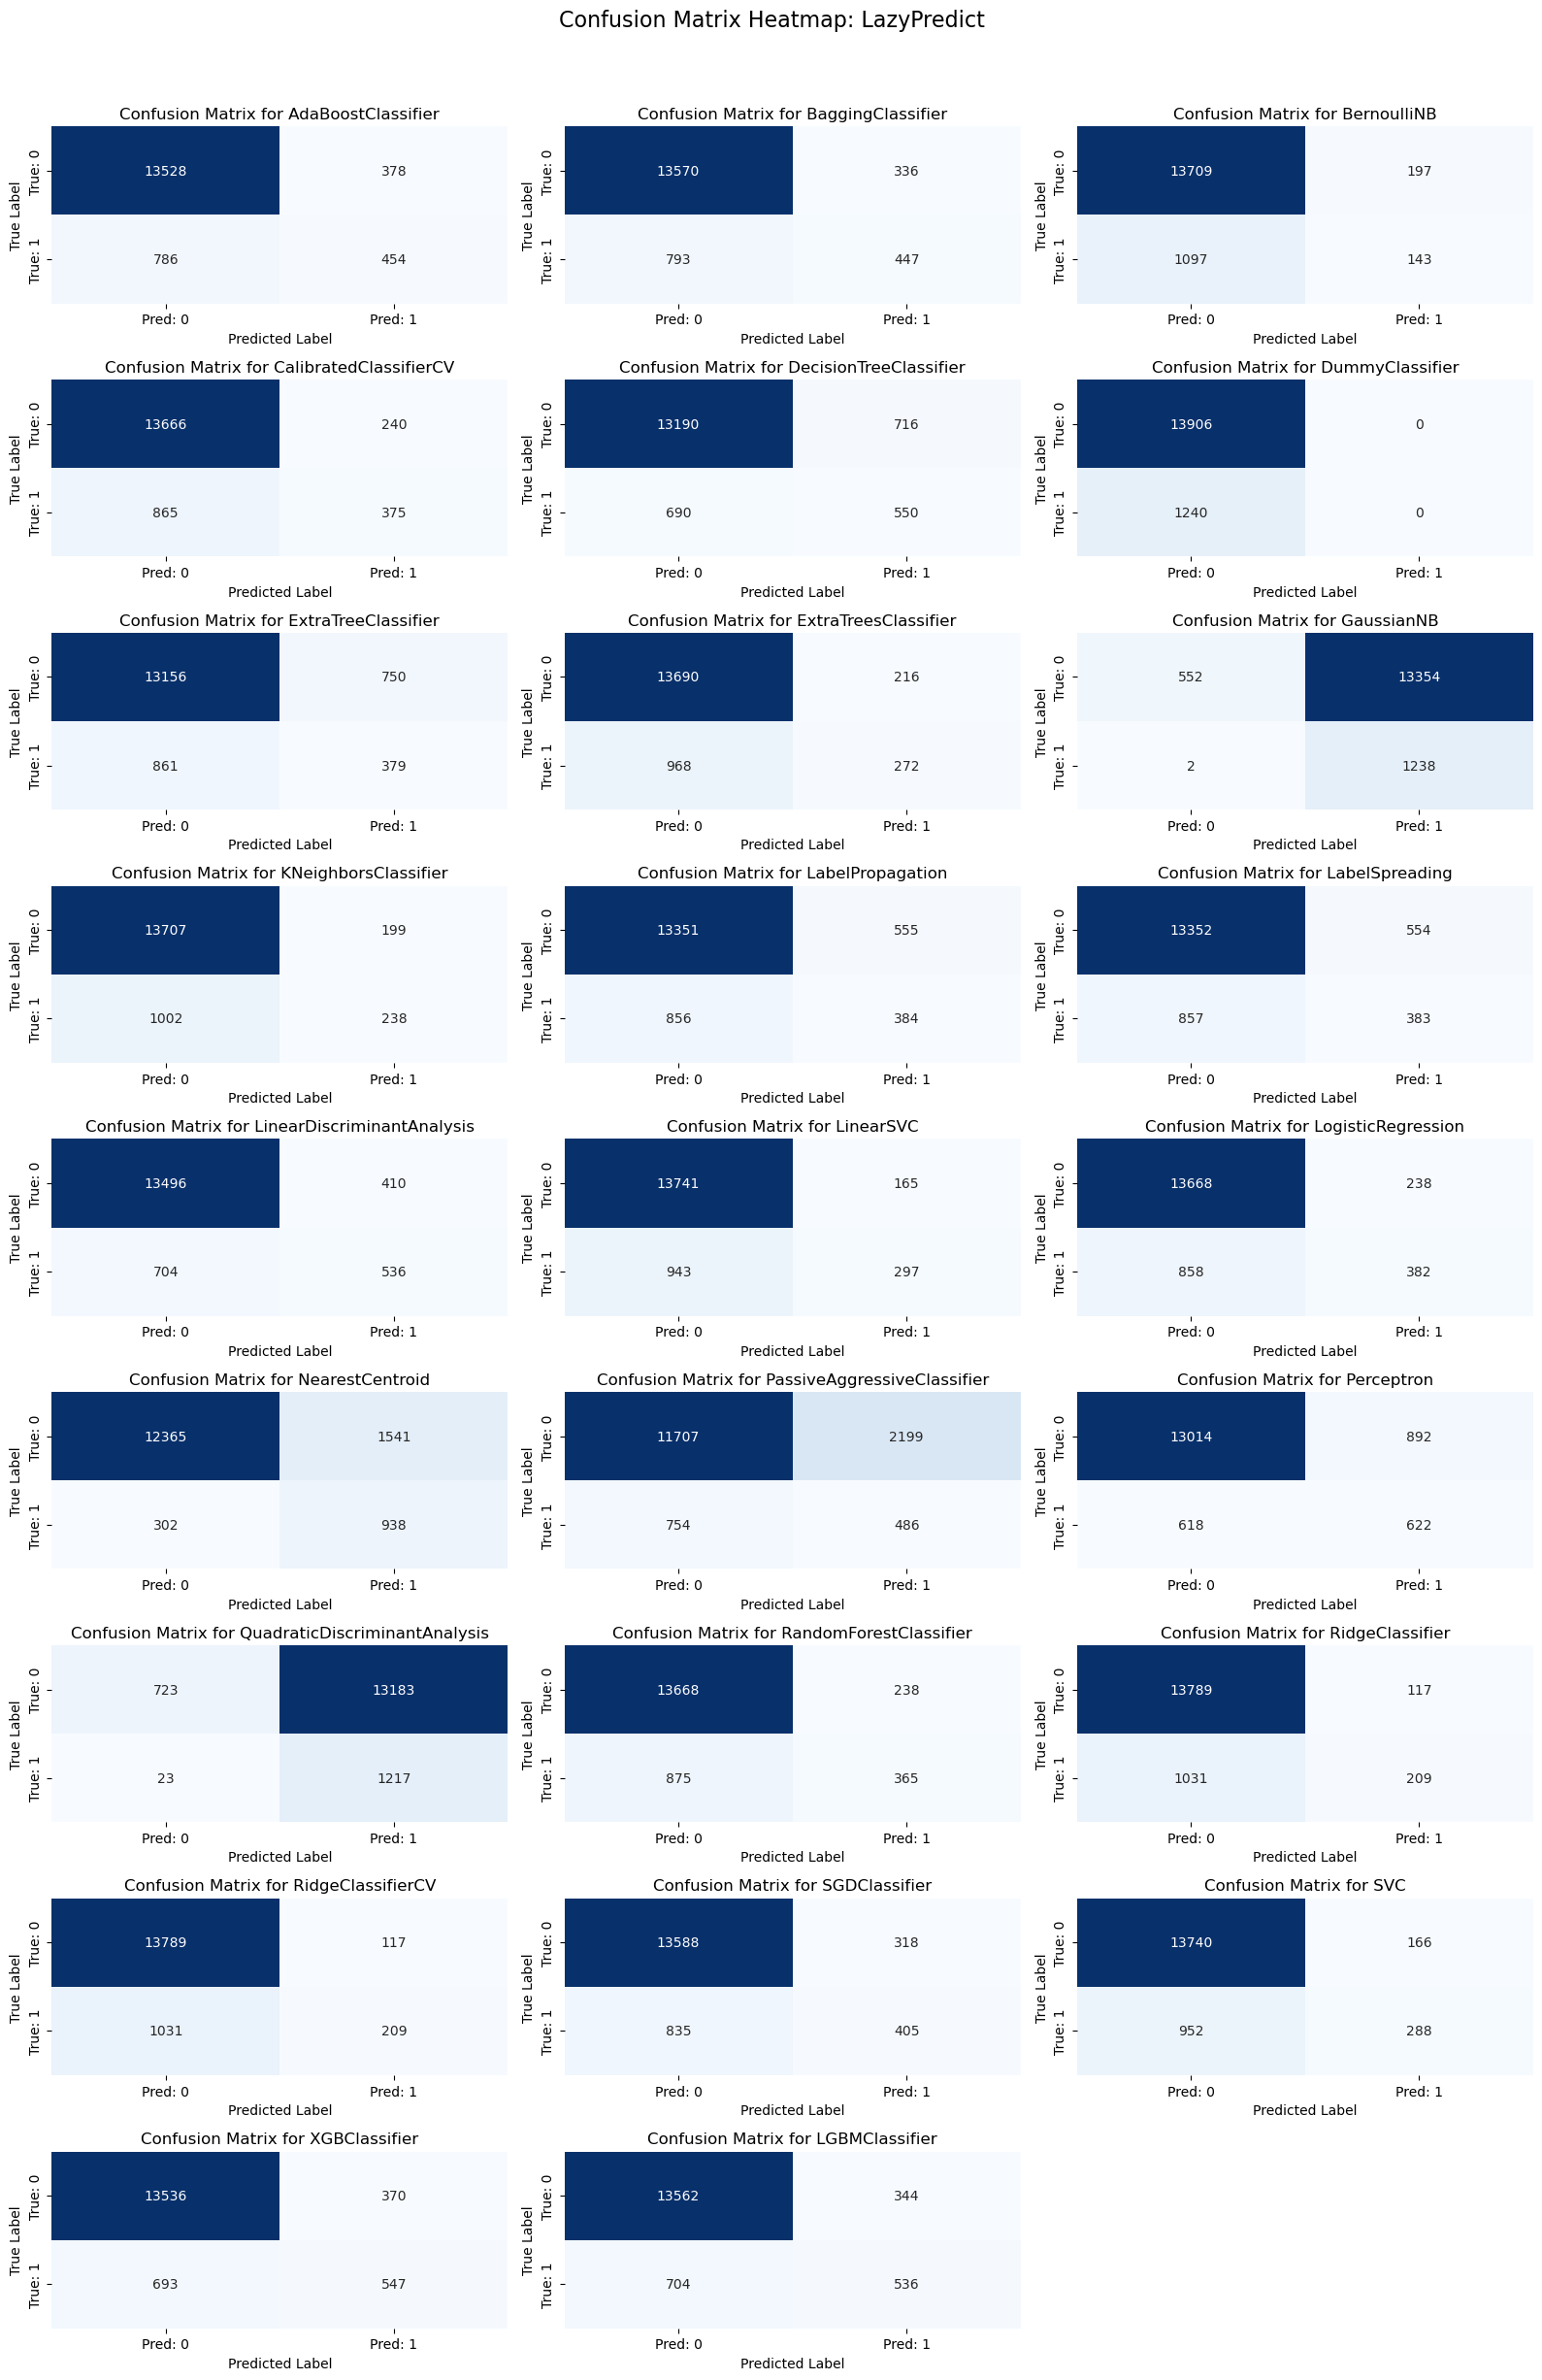

In [25]:
# Figure for cms
fig_cm, axes = plt.subplots(9, 3, figsize=(16, 24))

cm_results = {}

# Get predictions for each model
for i, ax in enumerate(axes.flat):
    try:
        # get model and pred data
        model_name = predictions.keys()[i]
        y_pred = predictions[model_name]

        # Generate Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_results[model_name] = cm

        # Plot Confusion Matrix
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Pred: 0', 'Pred: 1'],
            yticklabels=['True: 0', 'True: 1'],
            ax=ax,
            cbar=False  # Remove the colorbar
            )

        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    except Exception:
        ax.axis('off')

fig_cm.suptitle("Confusion Matrix Heatmap: LazyPredict", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Nice looking balanced strategies from NearestCentriod and Perceptron.

In [43]:
%%capture

# Closer Look at CM Results ---------------------------------------------------
cm_ratios_df = pd.DataFrame(columns=['tp', 'tn', 'fp', 'fn'])

for key, value in cm_results.items():

    tn, fp, fn, tp = value.flatten()

    cm_ratios_df.loc[key] = {
            'tp': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'tn': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'fp': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'fn': fn / (fn + tp) if (fn + tp) > 0 else 0
        }



'''

GaussianNB                    1.00 0.04 0.96 0.00
QuadraticDiscriminantAnalysis 0.98 0.05 0.95 0.02
NearestCentroid               0.76 0.89 0.11 0.24
Perceptron                    0.50 0.94 0.06 0.50
DecisionTreeClassifier        0.44 0.95 0.05 0.56
XGBClassifier                 0.44 0.97 0.03 0.56
LGBMClassifier                0.43 0.98 0.02 0.57
LinearDiscriminantAnalysis    0.43 0.97 0.03 0.57
PassiveAggressiveClassifier   0.39 0.84 0.16 0.61
AdaBoostClassifier            0.37 0.97 0.03 0.63
BaggingClassifier             0.36 0.98 0.02 0.64
SGDClassifier                 0.33 0.98 0.02 0.67
LabelPropagation              0.31 0.96 0.04 0.69
LabelSpreading                0.31 0.96 0.04 0.69
LogisticRegression            0.31 0.98 0.02 0.69
ExtraTreeClassifier           0.31 0.95 0.05 0.69
CalibratedClassifierCV        0.30 0.98 0.02 0.70
RandomForestClassifier        0.29 0.98 0.02 0.71
LinearSVC                     0.24 0.99 0.01 0.76
SVC                           0.23 0.99 0.01 0.77
ExtraTreesClassifier          0.22 0.98 0.02 0.78
KNeighborsClassifier          0.19 0.99 0.01 0.81
RidgeClassifier               0.17 0.99 0.01 0.83
RidgeClassifierCV             0.17 0.99 0.01 0.83
BernoulliNB                   0.12 0.99 0.01 0.88
DummyClassifier               0.00 1.00 0.00 1.00
'''
# -----------------------------------------------------------------------------

In [27]:
cm_ratios_df.sort_values(by='tp', ascending=False)

tp   tn   fp   fn
GaussianNB                    1.00 0.04 0.96 0.00
QuadraticDiscriminantAnalysis 0.98 0.05 0.95 0.02
NearestCentroid               0.76 0.89 0.11 0.24
Perceptron                    0.50 0.94 0.06 0.50
DecisionTreeClassifier        0.44 0.95 0.05 0.56
XGBClassifier                 0.44 0.97 0.03 0.56
LGBMClassifier                0.43 0.98 0.02 0.57
LinearDiscriminantAnalysis    0.43 0.97 0.03 0.57
PassiveAggressiveClassifier   0.39 0.84 0.16 0.61
AdaBoostClassifier            0.37 0.97 0.03 0.63
BaggingClassifier             0.36 0.98 0.02 0.64
SGDClassifier                 0.33 0.98 0.02 0.67
LabelPropagation              0.31 0.96 0.04 0.69
LabelSpreading                0.31 0.96 0.04 0.69
LogisticRegression            0.31 0.98 0.02 0.69
ExtraTreeClassifier           0.31 0.95 0.05 0.69
CalibratedClassifierCV        0.30 0.98 0.02 0.70
RandomForestClassifier        0.29 0.98 0.02 0.71
LinearSVC                     0.24 0.99 0.01 0.76
SVC                           0.23 0.99 0.01 0.77
ExtraTreesClassifier          0.22 0.98 0.02 0.78
KNeighborsClassifier          0.19 0.99 0.01 0.81
RidgeClassifier               0.17 0.99 0.01 0.83
RidgeClassifierCV             0.17 0.99 0.01 0.83
BernoulliNB                   0.12 0.99 0.01 0.88
DummyClassifier               0.00 1.00 0.00 1.00

True positive and true negative ratios are the best for NearestCentroid. Seems like the best model to predict customers worth calling while also keeping false negatives low.

### 4.2C Model Training

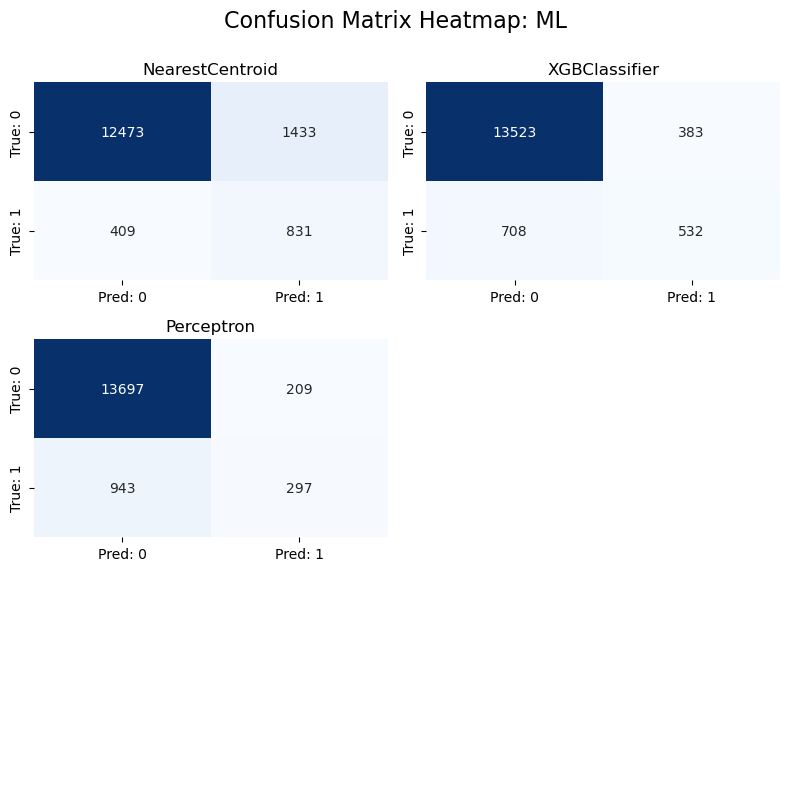

In [44]:
# Model Implementation - Second Layer
'''
- NearestCentriod
- Perceptron
- XGBClassifier
'''

fitted_models = {}

# NearestCentroid -------------------------------------------------------------
param_grid = {
    'metric': ['euclidean', 'manhattan'],
    'shrink_threshold': [None, 0.001, 0.01, 0.2, 0.5]
}

model = GridSearchCV(
    NearestCentroid(),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
    )

model.fit(X_train_t_df, y_train)

fitted_models['NearestCentroid'] = model
# -----------------------------------------------------------------------------

# XGBClassifier -------------------------------------------------------------
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.8, 1.0]
}

model = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid_xgb,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

model.fit(X_train_t_df, y_train)
fitted_models['XGBClassifier'] = model
# -----------------------------------------------------------------------------

# Perceptron -------------------------------------------------------------
param_grid_perceptron = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 5000]
}

model = GridSearchCV(
    Perceptron(),
    param_grid_perceptron,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

model.fit(X_train_t_df, y_train)
fitted_models['Perceptron'] = model
# -----------------------------------------------------------------------------

# Gather Accuracy Scores ------------------------------------------------------


def get_accuracy_score(x):
    model = fitted_models[x]
    y_pred = model.predict(X_test_t_df)
    y_pred = (y_pred >= 0.5).astype(int)
    result = accuracy_score(y_test, y_pred)
    return x, result


def get_confusion_matricies(x):
    model = fitted_models[x]
    y_pred = model.predict(X_test_t_df)
    y_pred = (y_pred >= 0.5).astype(int)
    result = confusion_matrix(y_test, y_pred)
    return x, result


accuracy = dict(
    map(lambda x: get_accuracy_score(x), fitted_models)
    )

confusion_matricies = dict(
    map(lambda x: get_confusion_matricies(x), fitted_models)
    )

# -----------------------------------------------------------------------------

# Confusion Plots -------------------------------------------------------------
fig_cm2, axes = plt.subplots(3, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    try:
        cm = confusion_matricies[list(confusion_matricies.keys())[i]]

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred: 0', 'Pred: 1'],
                    yticklabels=['True: 0', 'True: 1'],
                    ax=ax
                    )
        ax.set_title(f'{list(confusion_matricies.keys())[i]}')
    except Exception:
        ax.axis('off')

fig_cm2.suptitle("Confusion Matrix Heatmap: ML", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

In [45]:
# Confusion Ratios ------------------------------------------------------------
cmr = pd.DataFrame(columns=['tp', 'tn', 'fp', 'fn'])

for key, value in confusion_matricies.items():

    tn, fp, fn, tp = value.flatten()

    cmr.loc[key] = {
            'tp': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'tn': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'fp': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'fn': fn / (fn + tp) if (fn + tp) > 0 else 0
        }

cmr.sort_values(by='tp', ascending=False)
# -----------------------------------------------------------------------------

tp   tn   fp   fn
NearestCentroid 0.67 0.90 0.10 0.33
XGBClassifier   0.43 0.97 0.03 0.57
Perceptron      0.24 0.98 0.02 0.76

NearestCentriod looks the best. At this point deciding on a model could depend on the trade-offs between time-saved and potentially losing customers who would have subscribed.

### 4.2D Further Optimizations

I can't really optimize NearestCentriod further. We can try another model that allows for more complexity and see if we can tune a complex model for better performance. I use XGB because it had performed pretty well before, kept false positives fairly low, and had a good general accuracy; it can also become a fairly complicated model.

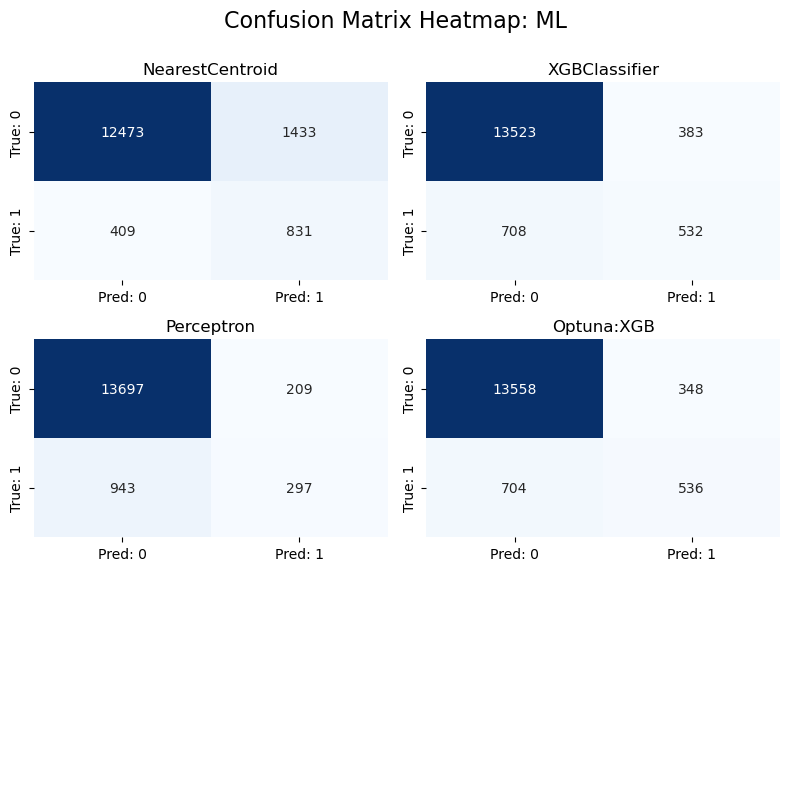

In [47]:
# Further Optimization

# # Define the Optuna objective function
# def objective(trial):
#     # Define hyperparameter search space
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 300),

#         "max_depth": trial.suggest_int("max_depth", 3, 15),

#         "learning_rate": trial.suggest_float(
#             "learning_rate", 0.01, 0.3, log=True
#             ),

#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "gamma": trial.suggest_float("gamma", 0, 5),
#         "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#         "use_label_encoder": False,
#         "objective": "multi:softmax",
#         "num_class": 2,
#         "eval_metric": "aucpr",
#         "seed": seed,
#     }

#     # Train the model with these parameters
#     model = XGBClassifier(**params, random_state=seed)

#     scores = cross_val_score(
#         model, X_train_t_df, y_train, cv=5, scoring="average_precision"
#      )

#     return scores.mean()  # Maximize accuracy


# # Run the Optuna optimization
# study = optuna.create_study(direction="maximize")  # Maximize accuracy
# study.optimize(objective, n_trials=50, n_jobs=-1)

# # Print the best parameters
# print("Best accuracy:", study.best_value)
# print("Best parameters:", study.best_params)

best_params = {
  'n_estimators': 297,
  'max_depth': 15,
  'learning_rate': 0.08890903365180643,
  'subsample': 0.9576066506798475,
  'colsample_bytree': 0.6404825013379966,
  'gamma': 3.1695839150861618,
  'reg_alpha': 0.011568052561632403,
  'reg_lambda': 4.584734978300553,
  'min_child_weight': 3
  }

# Train the best model with the found parameters
# best_params = study.best_params
best_model = XGBClassifier(**best_params, random_state=seed)
best_model.fit(X_train_t_df, y_train)

fitted_models['Optuna:XGB'] = best_model

# Scores ----------------------------------------------------------------------
accuracy = dict(
    map(lambda x: get_accuracy_score(x), fitted_models)
    )

confusion_matricies = dict(
    map(lambda x: get_confusion_matricies(x), fitted_models)
    )
# -----------------------------------------------------------------------------

# Confusion Plots -------------------------------------------------------------
fig_cm2, axes = plt.subplots(3, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    try:
        cm = confusion_matricies[list(confusion_matricies.keys())[i]]

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred: 0', 'Pred: 1'],
                    yticklabels=['True: 0', 'True: 1'],
                    ax=ax
                    )
        ax.set_title(f'{list(confusion_matricies.keys())[i]}')
    except Exception:
        ax.axis('off')

fig_cm2.suptitle("Confusion Matrix Heatmap: ML", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

Can't squeeze out much more performance from XGB. To do the final model implementation I'll use NearestCentriod.

In [48]:
%%capture

# Confusion Ratios ------------------------------------------------------------
cmr = pd.DataFrame(columns=['tp', 'tn', 'fp', 'fn'])

for key, value in confusion_matricies.items():

    tn, fp, fn, tp = value.flatten()

    cmr.loc[key] = {
            'tp': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'tn': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'fp': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'fn': fn / (fn + tp) if (fn + tp) > 0 else 0
        }

# -----------------------------------------------------------------------------

'''
                  tp   tn   fp   fn
NearestCentroid 0.67 0.90 0.10 0.33
Optuna:XGB      0.43 0.97 0.03 0.57
XGBClassifier   0.43 0.97 0.03 0.57
Perceptron      0.24 0.98 0.02 0.76
'''

In [49]:
cmr.sort_values(by='tp', ascending=False)

tp   tn   fp   fn
NearestCentroid 0.67 0.90 0.10 0.33
Optuna:XGB      0.43 0.97 0.03 0.57
XGBClassifier   0.43 0.97 0.03 0.57
Perceptron      0.24 0.98 0.02 0.76

In [52]:
# Cross Val -------------------------------------------------------------------
scores = cross_val_score(
    fitted_models['NearestCentroid'],
    X_train_t_df,
    y_train,
    cv=5,
    scoring="accuracy"
 )
# -----------------------------------------------------------------------------

In [54]:
scores

array([0.87190492, 0.88180918, 0.87850776, 0.8827996 , 0.87157478])

In [51]:
scores.mean()

0.8773192472763288

The model gets an average accuracy score of 87%, which completes one of our goals; "%81 or above accuracy by evaluating with 5-fold cross validation".

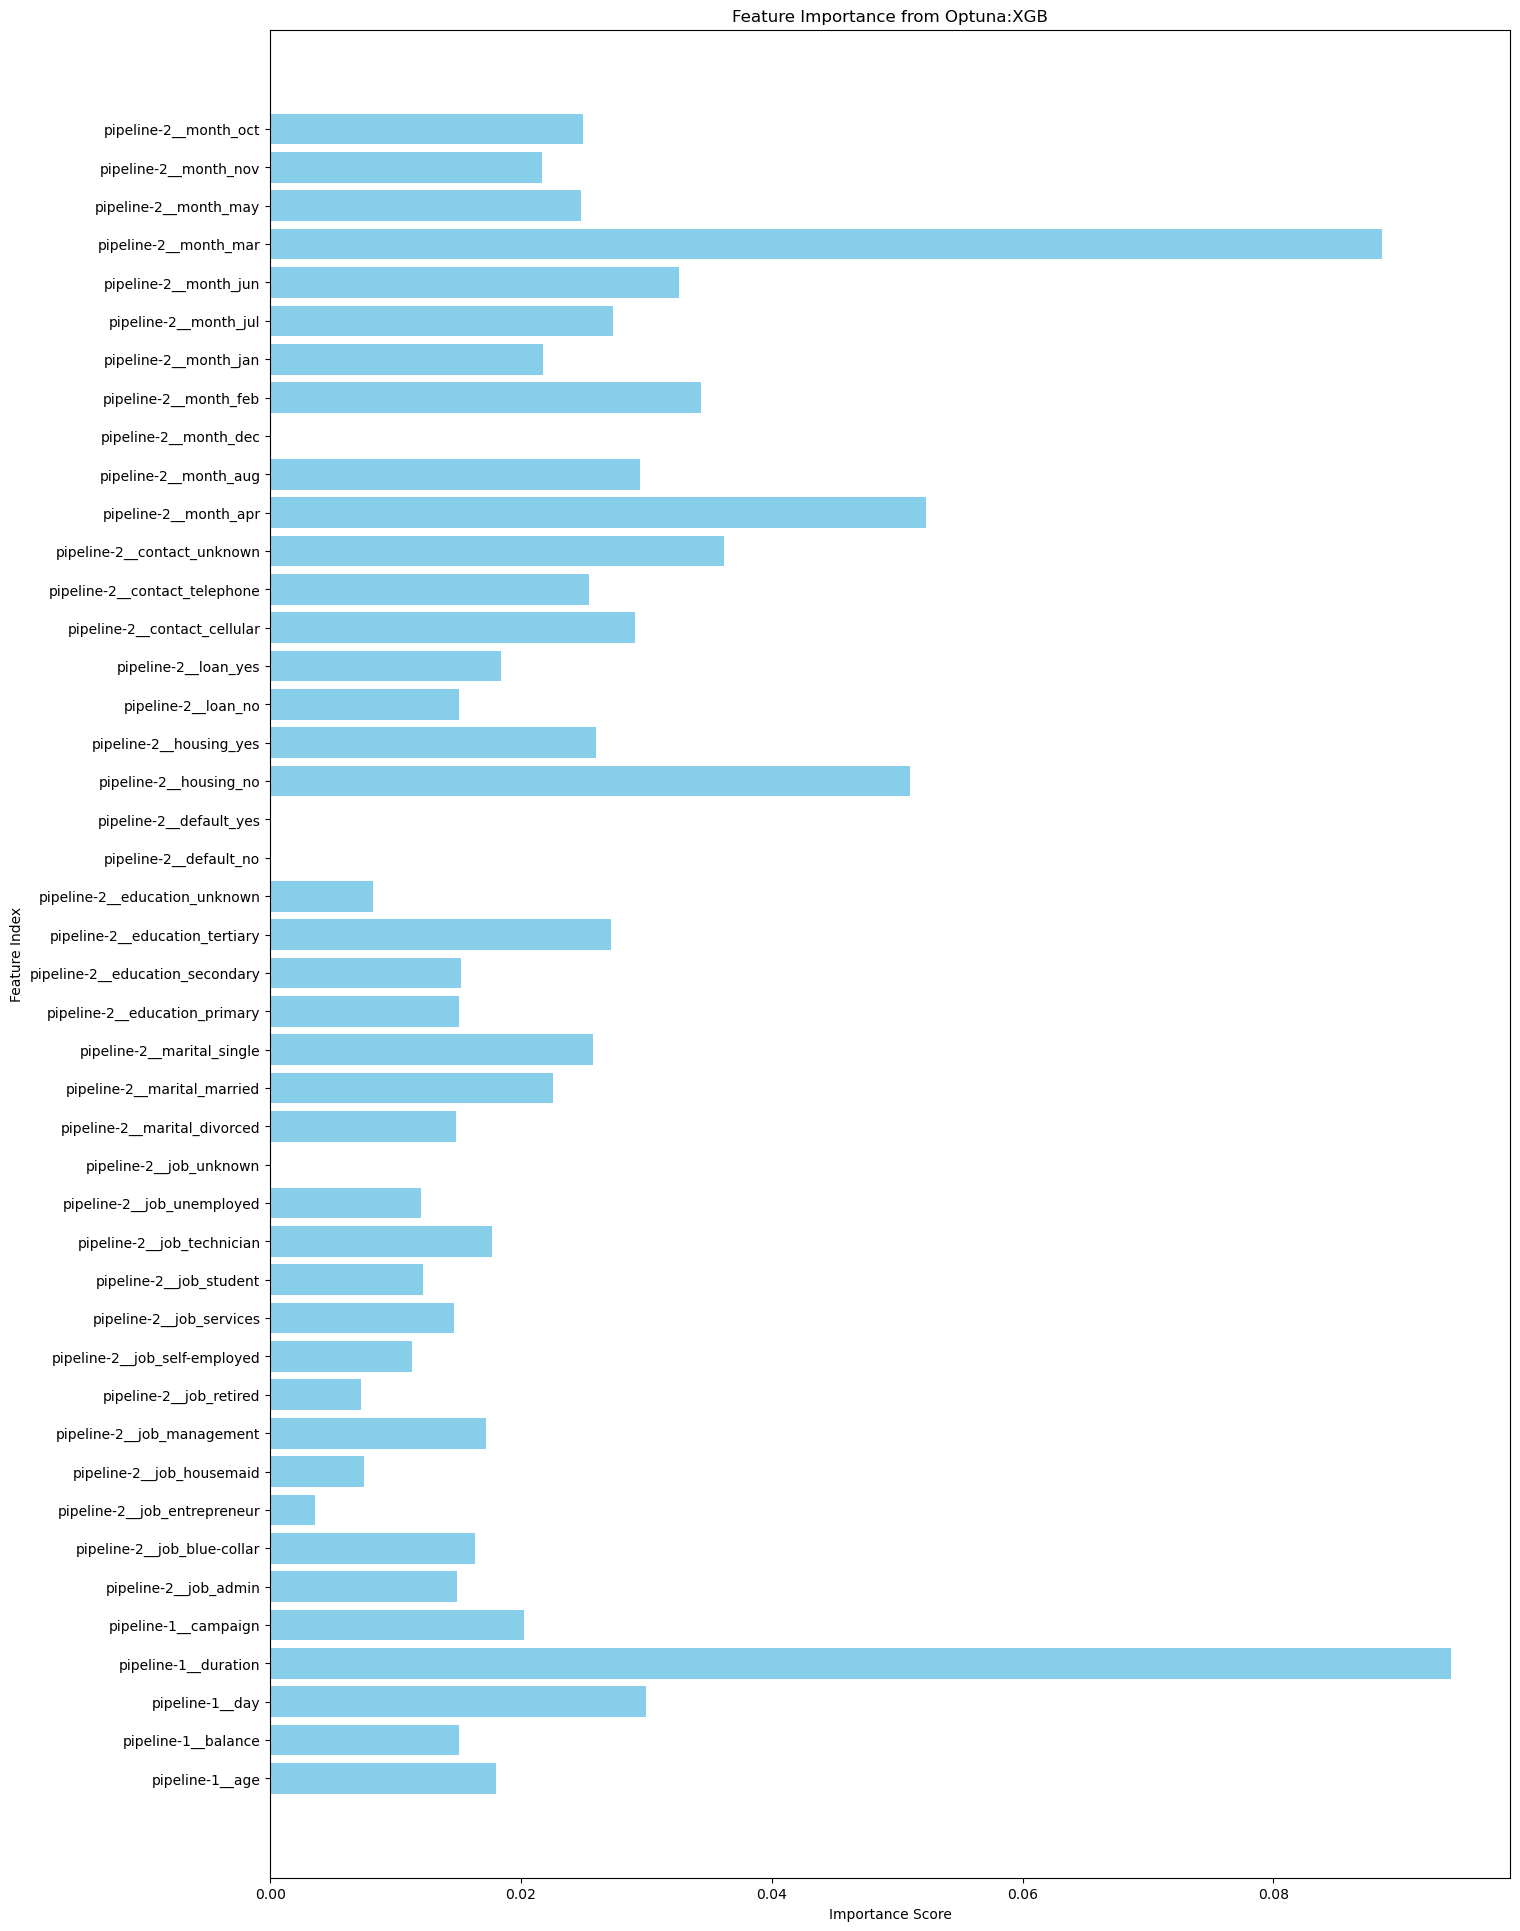

In [35]:
# Feature Importance ----------------------------------------------------------
importance = fitted_models['Optuna:XGB'].feature_importances_

# Plot feature importance
plt.figure(figsize=(16, 24))

# Create a horizontal bar plot
plt.barh([x for x in range(len(importance))], importance, color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature Index")
plt.title("Feature Importance from Optuna:XGB")
plt.yticks(range(len(importance)), labels=X_train_t_df.columns, fontsize=10)
plt.show()
# -----------------------------------------------------------------------------

One thing to note, March was a very important feature. This was fairly strange considering March had so few calls, so I looked into it. For pretty much all the calls in March they had all led to a customer subscribing to a deposit. Maybe there was a particular reason for this? It could be that the customers called in this month had completed their taxes for the season, knew or had their refund, and then wanted to invest in something low risk.

## 4.3 Second Layer Extended Training and Prediction

Here I further extend the training set to encompass the entire trimmed dataset. This is to mostly see the potential in culling the number of calls made while still retaining customers that are worth calling in the trimmed dataset.

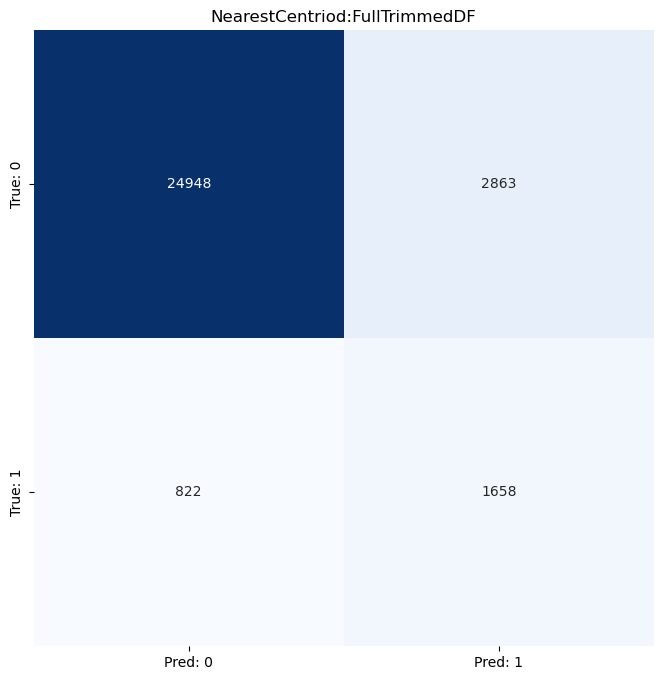

In [58]:
# NearestCentroid -------------------------------------------------------------
param_grid = {
    'metric': ['euclidean', 'manhattan'],
    'shrink_threshold': [None, 0.001, 0.01, 0.2, 0.5]
}

model = GridSearchCV(
    NearestCentroid(),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
    )

model = model.fit(X_train_t_df, y_train)
# -----------------------------------------------------------------------------

# Results ---------------------------------------------------------------------
y_pred = model.predict(X_trim_df)
acc_result = accuracy_score(y, y_pred)
cm_result = confusion_matrix(y, y_pred)
cv_results = model.cv_results_
# -----------------------------------------------------------------------------

# CM Plot ---------------------------------------------------------------------
plt.figure(figsize=(8, 8))

sns.heatmap(cm_result, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: 0', 'Pred: 1'],
            yticklabels=['True: 0', 'True: 1'],
            )
plt.title("NearestCentriod:FullTrimmedDF")
plt.show()
# -----------------------------------------------------------------------------

In [72]:
%%capture

# Some Calculations...
duration_calc = X[y_pred == 1]['duration']

hours_model = sum(duration_calc) / 120
hours_trimmed = sum(X["duration"]) / 120
hours_total = sum(df["duration"]) / 120

print(f'{hours_model:,.2f} hours calling only pred 1')
print(f'{hours_trimmed:,.2f} hours calling everyone in trimmed')
print(f'{hours_total:,.2f} hours calling everyone')

print(f'\nFrom trimming we save {hours_total - hours_trimmed:,.2f} hours. \n')

print(f'''From using the model we save an additional {hours_trimmed - hours_model:,.2f} \n''')

print(f'From using the model we save overall {hours_total - hours_model:,.2f} \n')

print(f'''Trade off from using the model is that we spend about 56,824.73 hours \
less on the phone, but lose about {sum(y) - cm_result[1,1]} subscribers, \
but then spend only {hours_model:,.2f} hours on the phone to get \
{cm_result[1,1]} subscribers.''')

Here is the potential time saved and trade-off.
- 20,095 hours or 837 days from trimming the dataset (1st layer)
- 36,729 hours or 1530 days saved from calling only customers deemed worthy by the model (2nd layer).
- The trade-off after applying this model would be saving 56,824 hours or 2367 days worth of call time, but we would lose 822 customers that would have subscribed if we called everyone.

## 4.4 Segmentations

Looking at just the customers who have subscribed, I will apply some unsupervised learning and see if I can find any groups within that would be of interest.

### 4.4A Kmeans

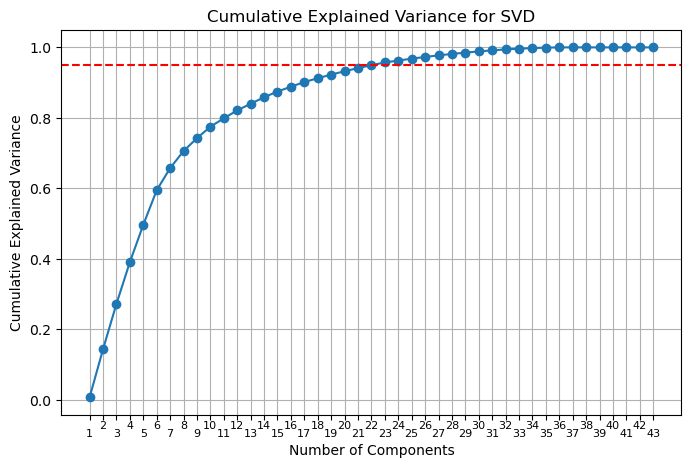

In [8]:
# %% [13] Unsupervised model - kmeans

# DuckDB ----------------------------------------------------------------------
'''
Use duckDB to filter data to only subscribers.
'''

df_subscribers = duckdb.sql("SELECT * FROM df WHERE y = 'yes'").fetchdf()
# -----------------------------------------------------------------------------

# Setup Data for Unsupervised ML ----------------------------------------------
df_subscribers = df_subscribers.drop(columns=['y'])

# Transform and Encode
df_subscribers_encoded = preprocessing.fit_transform(df_subscribers)

df_subscribers_encoded_df = pd.DataFrame(
    df_subscribers_encoded,
    columns=preprocessing.get_feature_names_out(),
    index=df_subscribers.index)
# -----------------------------------------------------------------------------

# Truncated SVD ---------------------------------------------------------------
svd = TruncatedSVD(
    n_components=min(df_subscribers_encoded_df.shape)-1,
    random_state=seed
    )

svd.fit(df_subscribers_encoded_df)

explained_variance = svd.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))

plt.plot(
    range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o'
    )

plt.title('Cumulative Explained Variance for SVD')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Threshold line at 95%
plt.grid()

# Set x-ticks to show all components
plt.xticks(range(1, len(cumulative_variance) + 1), fontsize=8)

# Offset every other x-tick up and down
for i, tick in enumerate(plt.gca().get_xticklabels()):
    if i % 2 == 0:  # Adjust only even-indexed ticks
        tick.set_y(tick.get_position()[1] - 0.01)
    else:
        tick.set_y(tick.get_position()[1] + 0.01)

plt.show()
# -----------------------------------------------------------------------------

In [69]:
# Apply Reduction -------------------------------------------------------------
svd = TruncatedSVD(
    n_components=22,
    random_state=seed
    )

svd.fit(df_subscribers_encoded_df)

df_subscribers_encoded_df_reduction = svd.fit_transform(
    df_subscribers_encoded_df
    )
# -----------------------------------------------------------------------------

# PCA Reduction----------------------------------------------------------------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_subscribers_encoded_df_reduction)
# -----------------------------------------------------------------------------

I applied TruncatedSVD to reduce from 44 to 22 components based on the cumulative variance being still 95% at 22 components, and then I applied PCA to further reduce to 2 components. I had used TruncatedSVD because it's good for sparse data and I wanted to see if combining these two techniques could improve the reduction, but after some fiddling I found it made no difference.

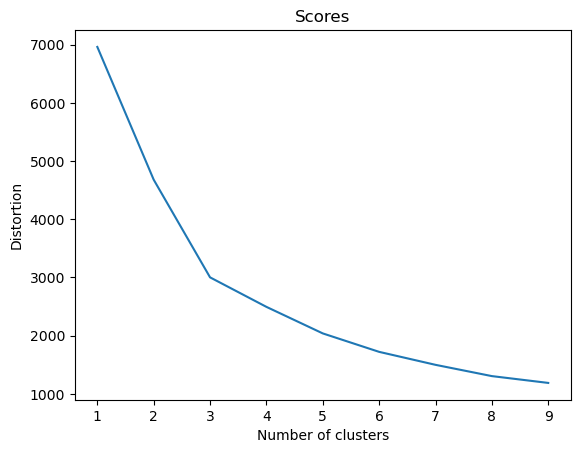

In [70]:
# kmeans ----------------------------------------------------------------------
distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(pca_result)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 10), distortions)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Scores')
plt.show()
# -----------------------------------------------------------------------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


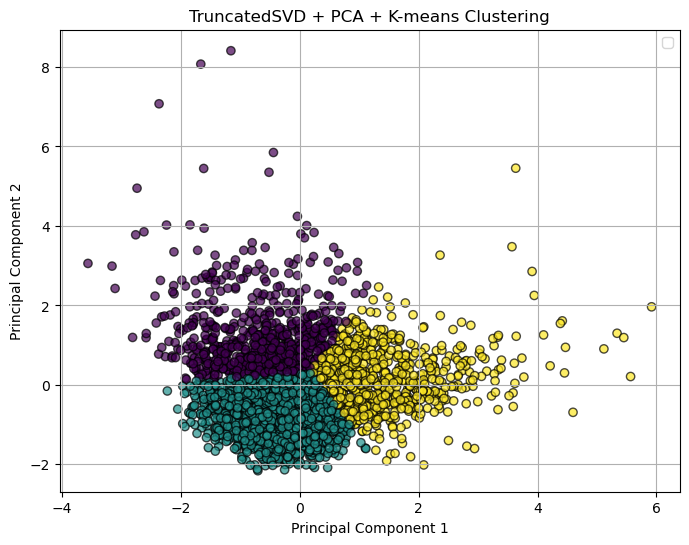

In [71]:
# Plot K-means ----------------------------------------------------------------
kmeans = KMeans(n_clusters=3, random_state=seed)  # Change number of clusters as needed
kmeans.fit(pca_result)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))

plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=labels,
    cmap='viridis',
    edgecolor='k',
    alpha=0.7
    )

plt.title('TruncatedSVD + PCA + K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

'''
Pretty much seeing one blob with some outliers. Not really any distinct groups
within subscribers...

- tried with and without TruncatedSVD, saw no changes
'''
# -----------------------------------------------------------------------------

# Most Common Features --------------------------------------------------------

def return_common_features(df):
    result = pd.DataFrame()

    for col in df.columns:
        mode_value = df[col].mode().iloc[0]
        mode_count = df[col].value_counts().iloc[0]
        result[col] = [mode_value, mode_count]
        result.index = ['most_common', 'common_count']

    describe_df = df.describe()
    result = pd.concat([result, describe_df])

    return result


# variables
label_groups_df = []
df_subscribers['label'] = labels

# seperate groups
for label in set(labels):

    label_groups_df.append(
        df_subscribers[df_subscribers['label'] == label]
        )

common_features = list(map(return_common_features, label_groups_df))
common_features.append(return_common_features(df_subscribers))
'''
Nothing immedietly distinct between the groups...
'''
# -----------------------------------------------------------------------------

# Combine DataFrames ----------------------------------------------------------
'''
I want to combine and tag my dataframes for each group, so I can plot them.
'''

count = 1
for group in label_groups_df:
    group['id'] = count
    count += 1

df_subscribers['id'] = 4
label_groups_df.append(df_subscribers)
groups_df = pd.concat(label_groups_df)
# -----------------------------------------------------------------------------

This plot tells us that these customers are fairly similar. It's able to find define some clusters, but the differences between them might not be fairly discernable.

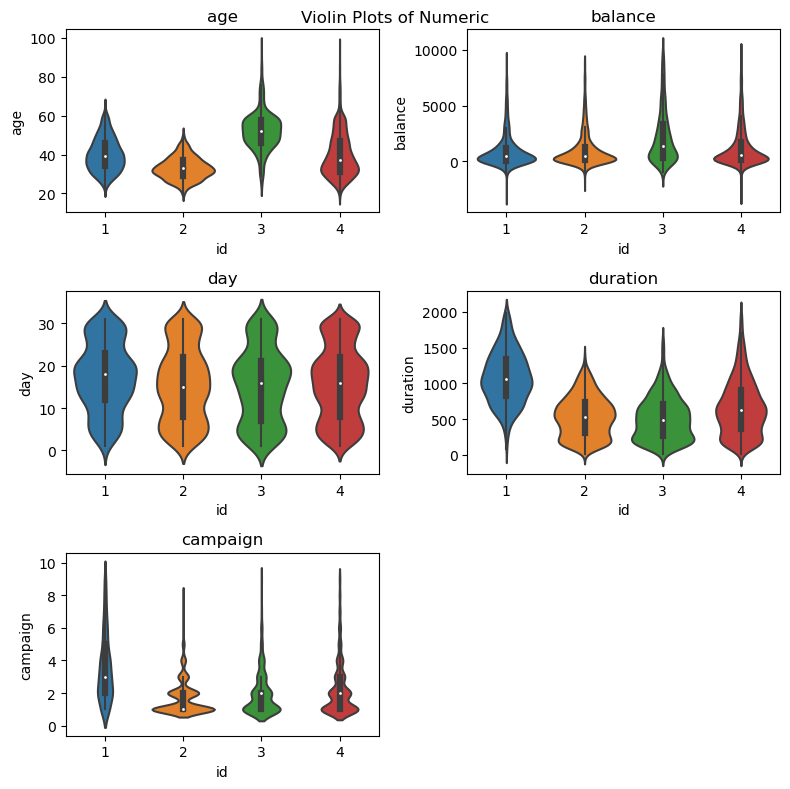

In [73]:

# Violin Plots With Each Group ------------------------------------------------
fig_violin, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    try:

        _col = _cols_numerical[i]

        cutoff = {
            'balance': 10000,
            'duration': 2000,
            'campaign': 10
            }

        if _col in cutoff.keys():

            rows = groups_df[_col] < int(cutoff[_col])
            _ydata = groups_df.loc[rows, _col]
            _xdata = groups_df.loc[rows, 'id']

        else:
            _ydata = groups_df.loc[:, _col]
            _xdata = groups_df['id']

        sns.violinplot(x=_xdata, y=_ydata, ax=ax)
        ax.set_title(f"{_col}")

    except Exception:
        ax.axis('off')

plt.tight_layout()
fig_violin.suptitle("Violin Plots of Numeric")
plt.show()
# -----------------------------------------------------------------------------

We can kind of see the three different groups easier in these violin plots. Note that group four is just a group I added manually; it's all of our subscribers as one group.

These are some of the details I noticed relative to each group.
- Blue group: mostly middle aged, low balance, higher average duration (8-30 mins), much more spread out campaign calls.

- Orange group: middle to younger aged, low balance, shorter duration calls, less campaigns needed.

- Green group: older aged, spread out balances, shorter to mid duration, slightly more spread out campaign calls.

Note that groups are uneven, 1 ~ 700, 2 ~ 1400, 3 ~ 700.

The most polarizing differences seem to be in age, call duration, and number of campaigns.

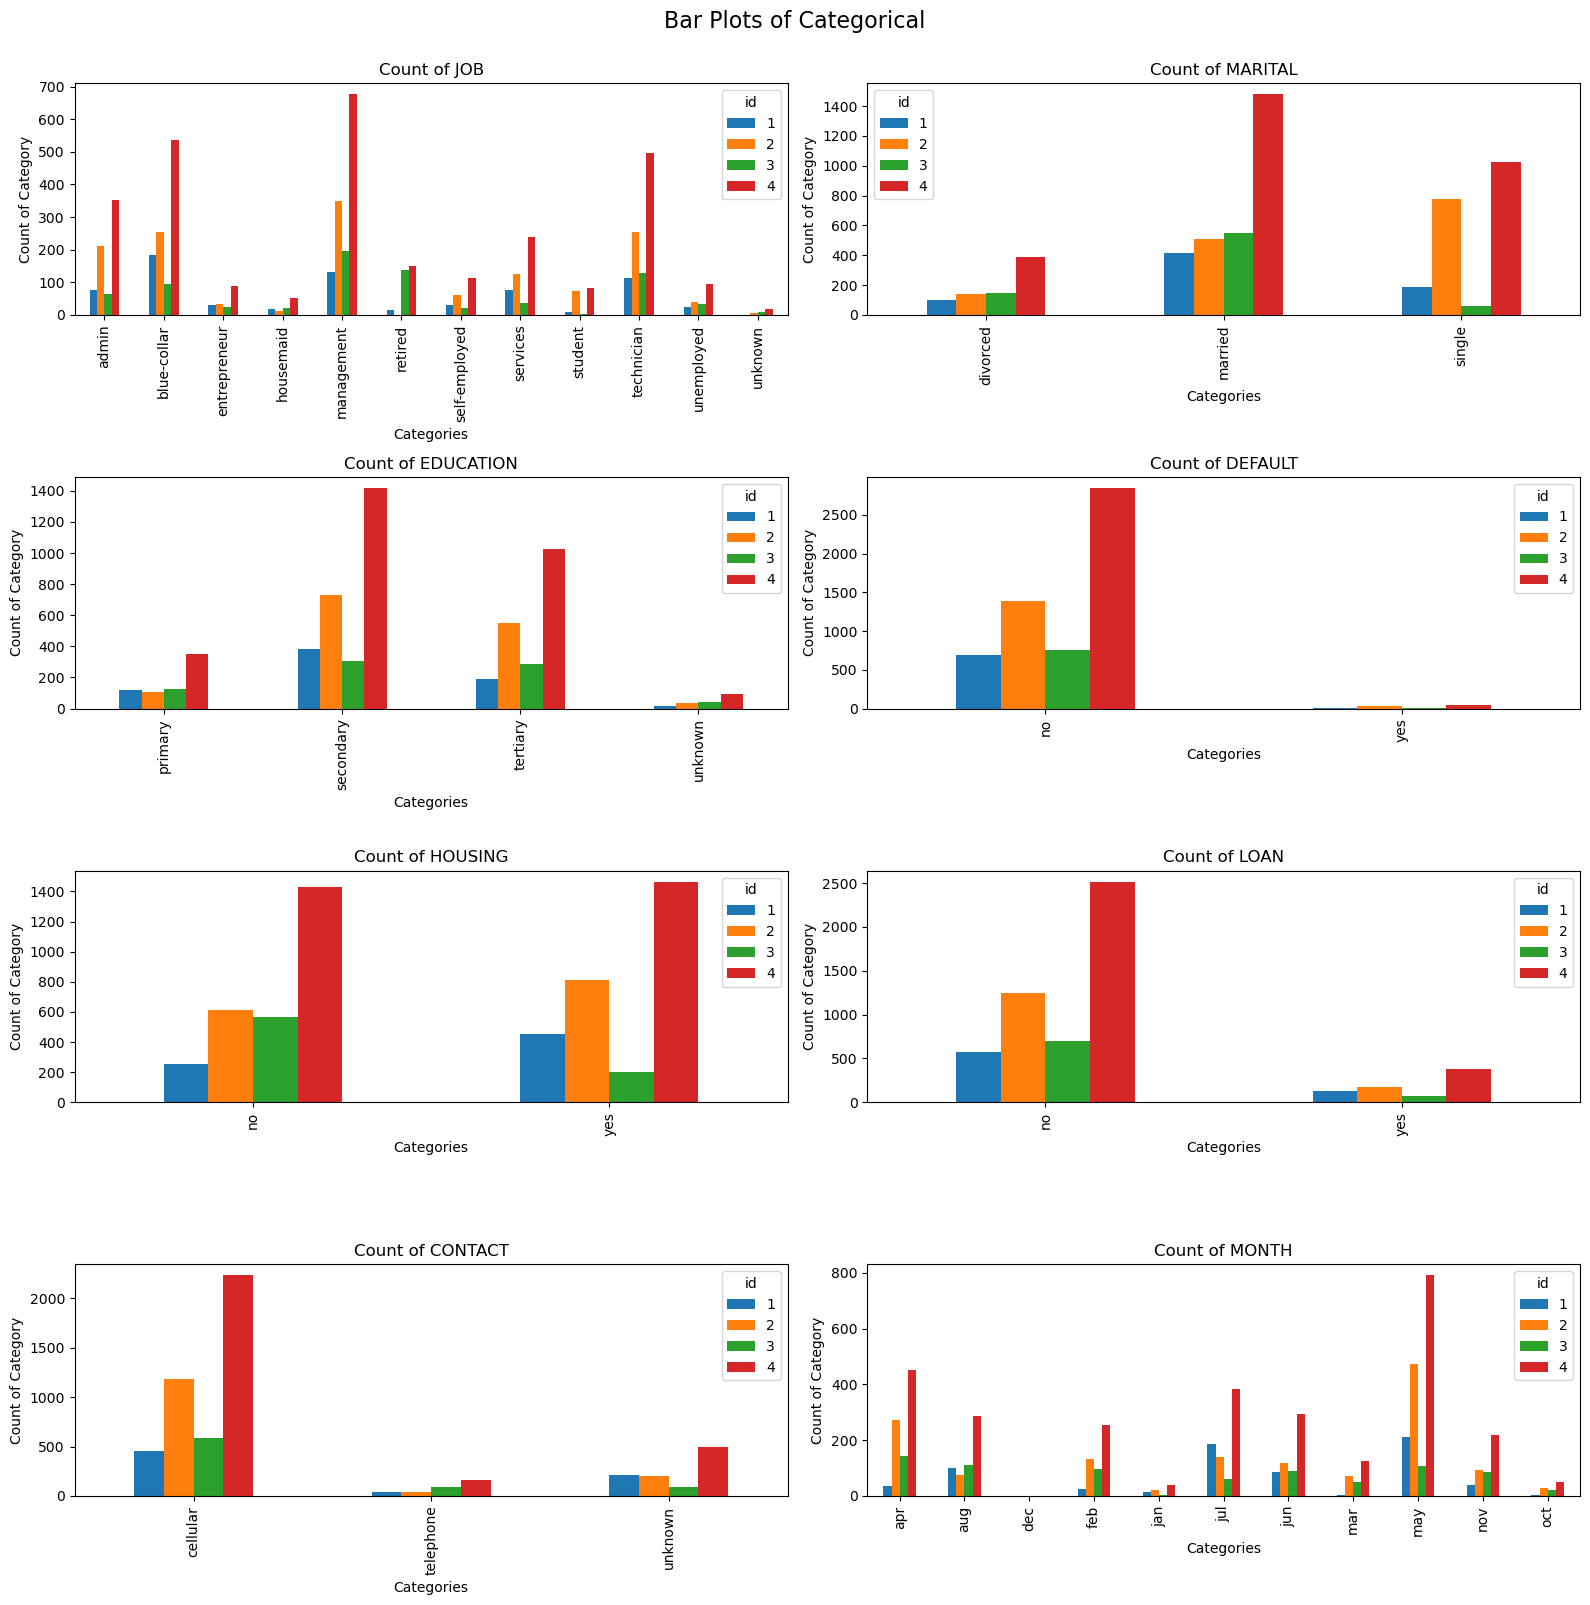

In [76]:
# Grouped Bar Plots -----------------------------------------------------------
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes_flat = axes.flatten()

for ax, column in zip(axes_flat, _cols_categorical):
    _group = groups_df.groupby([column, 'id'])[column].count()
    _group.name = 'value'
    _data = _group.reset_index()

    _pivot = _data.pivot_table(
        index=_data.columns[0],
        columns=_data.columns[1],
        values='value'
        )

    _pivot.plot(kind='bar', stacked=False, ax=ax)

    ax.set_title(f'Count of {column.upper()}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count of Category')

fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

The most discernible difference is that group orange is mostly single, but that's likely due to them being younger as seen in the prior violin plots.

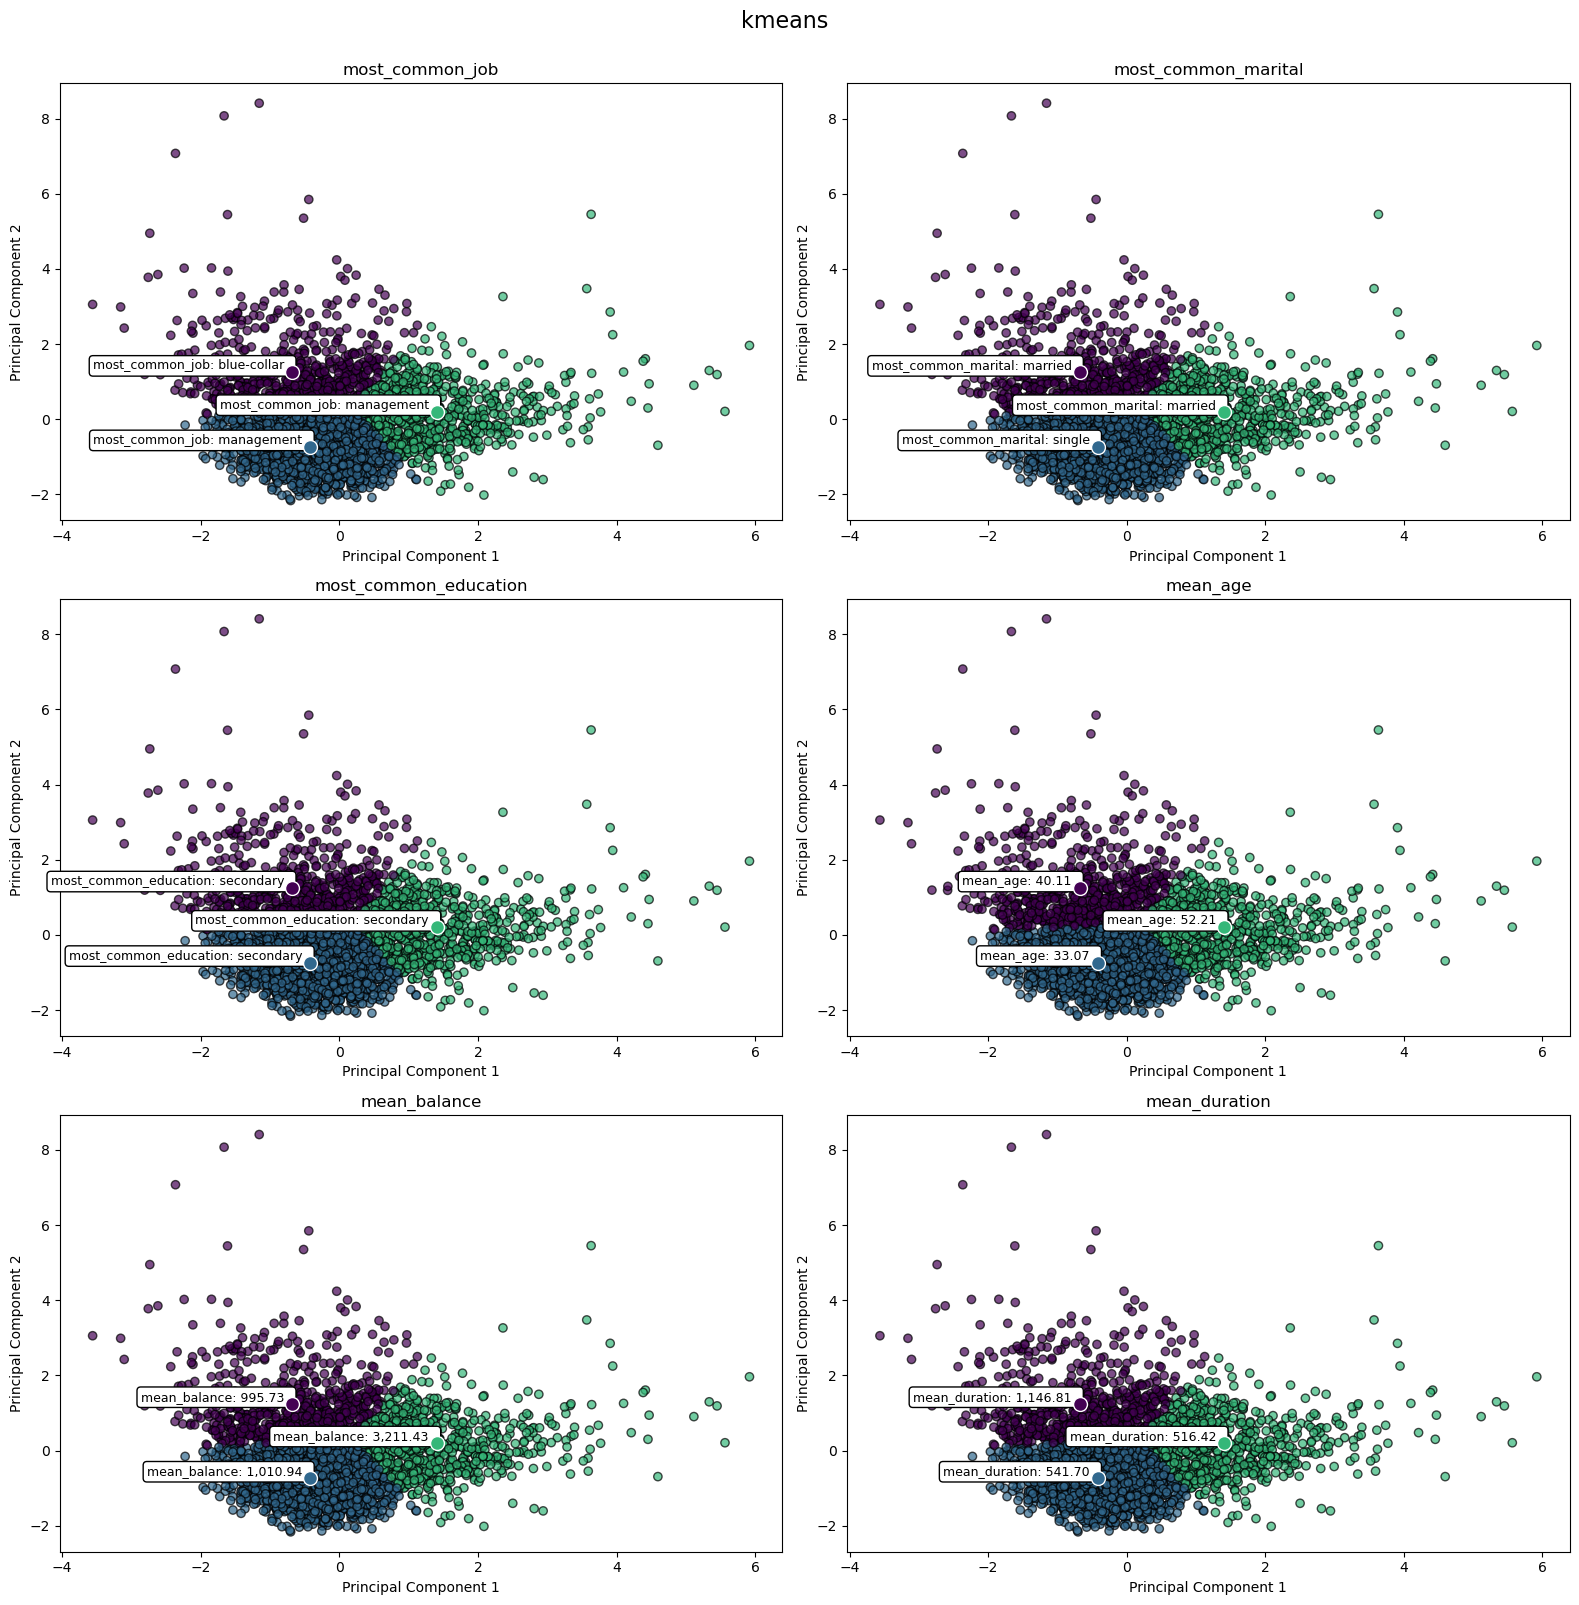

In [70]:
# Create Measures Per Group/Label ---------------------------------------------

indexes_list = [
    ['most_common', 'job'],
    ['most_common', 'marital'],
    ['most_common', 'education'],
    ['mean', 'age'],
    ['mean', 'balance'],
    ['mean', 'duration']
    ]

label_groups_df = {}
pca_result_df = pd.DataFrame(pca_result.copy())

# Create Measures Per Group/Label ---------------------------------------------

kmeans = KMeans(n_clusters=3, random_state=seed)  # Change number of clusters as needed
kmeans.fit(pca_result)
labels = kmeans.labels_
label_df = pd.DataFrame(df_subscribers.copy())
label_df['id'] = labels
pca_result_df['id'] = labels

# seperate groups
for label in set(label_df['id']):
    label_groups_df[label] = label_df[label_df['id'] == label]

common_features_2 = dict(map(
    lambda x: apply_measures(x[0], x[1]), label_groups_df.items())
    )

new_table = pd.DataFrame()

for indexes in indexes_list:
    for key in common_features_2.keys():
        new_table.loc['_'.join(map(str, indexes)), key] = (
            common_features_2[key].at[indexes[0], indexes[1]]
            )
kmeans = KMeans(n_clusters=3, random_state=seed)  # Change number of clusters as needed
kmeans.fit(pca_result)
labels = kmeans.labels_

label_df = pd.DataFrame(df_subscribers.copy())
label_df['id'] = labels
pca_result_df['id'] = labels

# Create Centriods and Adjust -------------------------------------------------
centroids = {}

for label in label_df.id:
    temp = pca_result_df[pca_result_df['id'] == label]
    centroids[label] = (temp[0].mean(), temp[1].mean())


def adjust_centroids(centroids, min_distance):
    """
    Adjust centroids if they are too close to each other by adding a margin.

    Parameters:
    - centroids: A dictionary where keys are labels and values are 2D
    centroids (x, y).
    - min_distance: The minimum allowed distance between any two centroids.

    Returns:
    - Adjusted centroids with the margin added.
    """
    labels = list(centroids.keys())
    adjusted_centroids = centroids.copy()

    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            label_i = labels[i]
            label_j = labels[j]
            centroid_i = np.array(centroids[label_i])
            centroid_j = np.array(centroids[label_j])

            dist = np.linalg.norm(centroid_i - centroid_j)
            if dist < min_distance:
                # Calculate the direction vector and normalize it
                direction = centroid_j - centroid_i
                direction /= np.linalg.norm(direction)

                # Add margin to the centroids in opposite directions
                margin_vector = direction * (min_distance - dist) / 2
                adjusted_centroids[label_i] = tuple(centroid_i - margin_vector)
                adjusted_centroids[label_j] = tuple(centroid_j + margin_vector)

    return adjusted_centroids


# Example usage
min_distance = 2  # Minimum distance to maintain

adjusted_centroids = adjust_centroids(centroids, min_distance)

# variables
label_groups_df = {}
cmap = cm.viridis

# Bar plots
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes_flat = axes.flatten()

# colors

num_colors = len(set(label_df['id']))
colors = [cmap(i / num_colors) for i in range(num_colors)]
color_map = {id_val: colors[i] for i, id_val in enumerate(
    sorted(set(label_df['id'])))}
label_df['color'] = (
    label_df['id'].map(color_map)
    )

pca_result_df['color'] = label_df['color'].copy()

for ax, index in zip(axes_flat, indexes_list):
    # Plot the scatter with custom colors
    ax.scatter(
        pca_result_df.loc[:, 0],  # x-coordinates
        pca_result_df.loc[:, 1],  # y-coordinates
        c=pca_result_df['color'],  # Custom colors
        edgecolor='k',  # Black edge for the points
        alpha=0.7  # Transparency
    )

    for key, value in adjusted_centroids.items():

        ax.scatter(
            value[0],
            value[1],
            color=colors[key],
            s=100,
            edgecolor='white',
            marker='o',
            zorder=5
        )

        try:
            label = f'{index[0]}_{index[1]}: {new_table.at["_".join(index), key]:,.2f}  '
        except Exception:
            label = f'{index[0]}_{index[1]}: {new_table.at["_".join(index), key]}  '

        ax.text(
            value[0], value[1],
            s=f'{label}',
            fontsize=9,
            ha='right',
            va='bottom',
            color='black',
            bbox=dict(
                facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'
            )
        )

    ax.set_title(f'{index[0]}_{index[1]}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

# fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)

plt.suptitle("kmeans", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

This plot just ties some of the measures to the actual groups on a 2D plane.

### 4.4B Hierarchical and DBSCAN

This section focuses on applying some more clustering techniques (hierarchical and dbscan), and feature engineering (gower). The goal is to see if we can make more distinct groups. I apply gower's distance to our dataset to handle the distance between mixed data types better (numeric, categorical, binary).

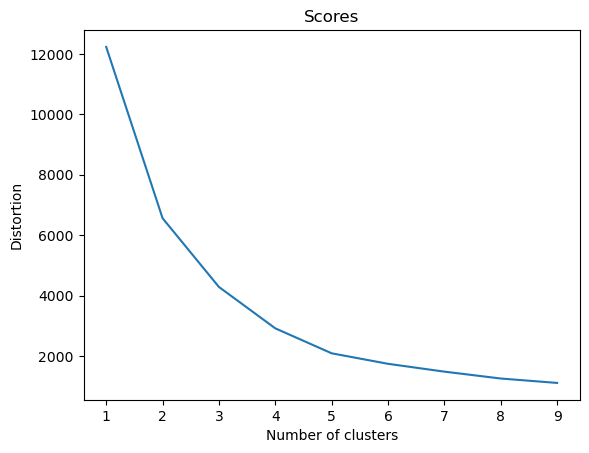

In [81]:
# %% [14] Higher Order Clustering
'''
- Kmeans + gower
- Hierarchical Clustering + Gower’s Distanc
- DBSCAN + Gower’s Distance
'''
# setup data ------------------------------------------------------------------

gower_distance_matrix = gower.gower_matrix(df_subscribers_encoded_df)
pca = PCA(n_components=2)
pca_gower_result = pca.fit_transform(gower_distance_matrix)
# -----------------------------------------------------------------------------

# Optimal Clusters ------------------------------------------------------------
distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(pca_gower_result)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 10), distortions)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Scores')
plt.show()

'''
With the gower+pca data, it seems like 5 groups is most optimal.
'''
# -----------------------------------------------------------------------------

# Convert to DF ---------------------------------------------------------------
'''
To make adding labels, ids, clusters, etc, easier.
'''
pca_gower_result = pd.DataFrame(pca_gower_result)
# -----------------------------------------------------------------------------

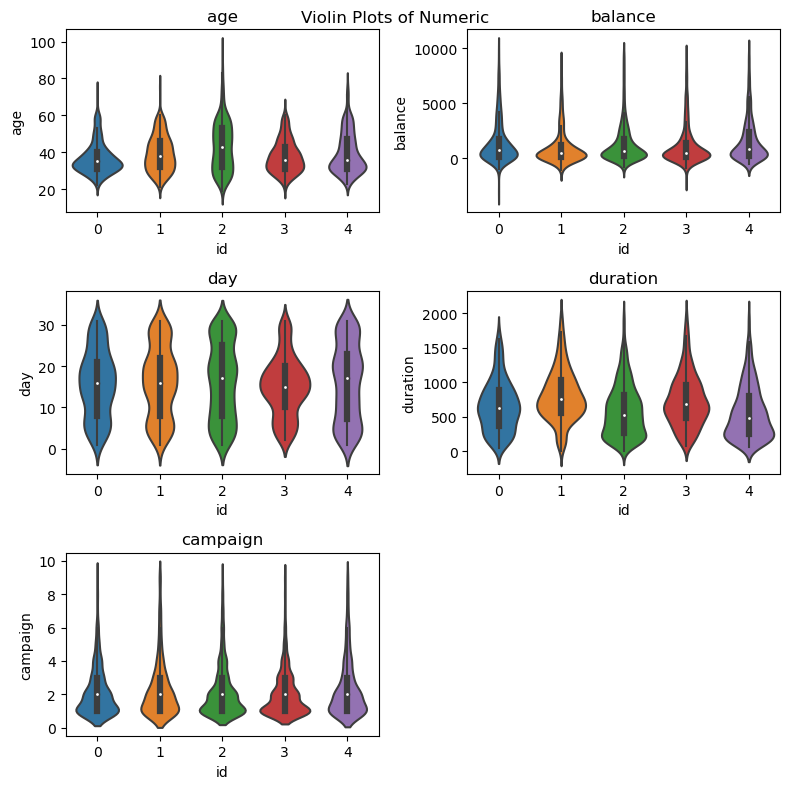

In [82]:
# gower + kmeans -------------------------------------------------------------
'''
If I do 3 groups instead of 5, I actually get similar grouping as the next
model, hierarchical. But 5 should be better based on our distortion scores.
'''

kmeans = KMeans(n_clusters=5, random_state=seed)
kmeans.fit(gower_distance_matrix)

label_df = df_subscribers.copy()
label_df['id'] = kmeans.labels_

# Violin
fig_violin, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    try:

        _col = _cols_numerical[i]

        cutoff = {
            'balance': 10000,
            'duration': 2000,
            'campaign': 10
            }

        if _col in cutoff.keys():

            rows = label_df[_col] < int(cutoff[_col])
            _ydata = label_df.loc[rows, _col]
            _xdata = label_df.loc[rows, 'id']

        else:
            _ydata = label_df.loc[:, _col]
            _xdata = label_df['id']

        sns.violinplot(x=_xdata, y=_ydata, ax=ax)
        ax.set_title(f"{_col}")

    except Exception:
        ax.axis('off')

plt.tight_layout()
fig_violin.suptitle("Violin Plots of Numeric")
plt.show()


Again, only age and duration show any noticeable differences.

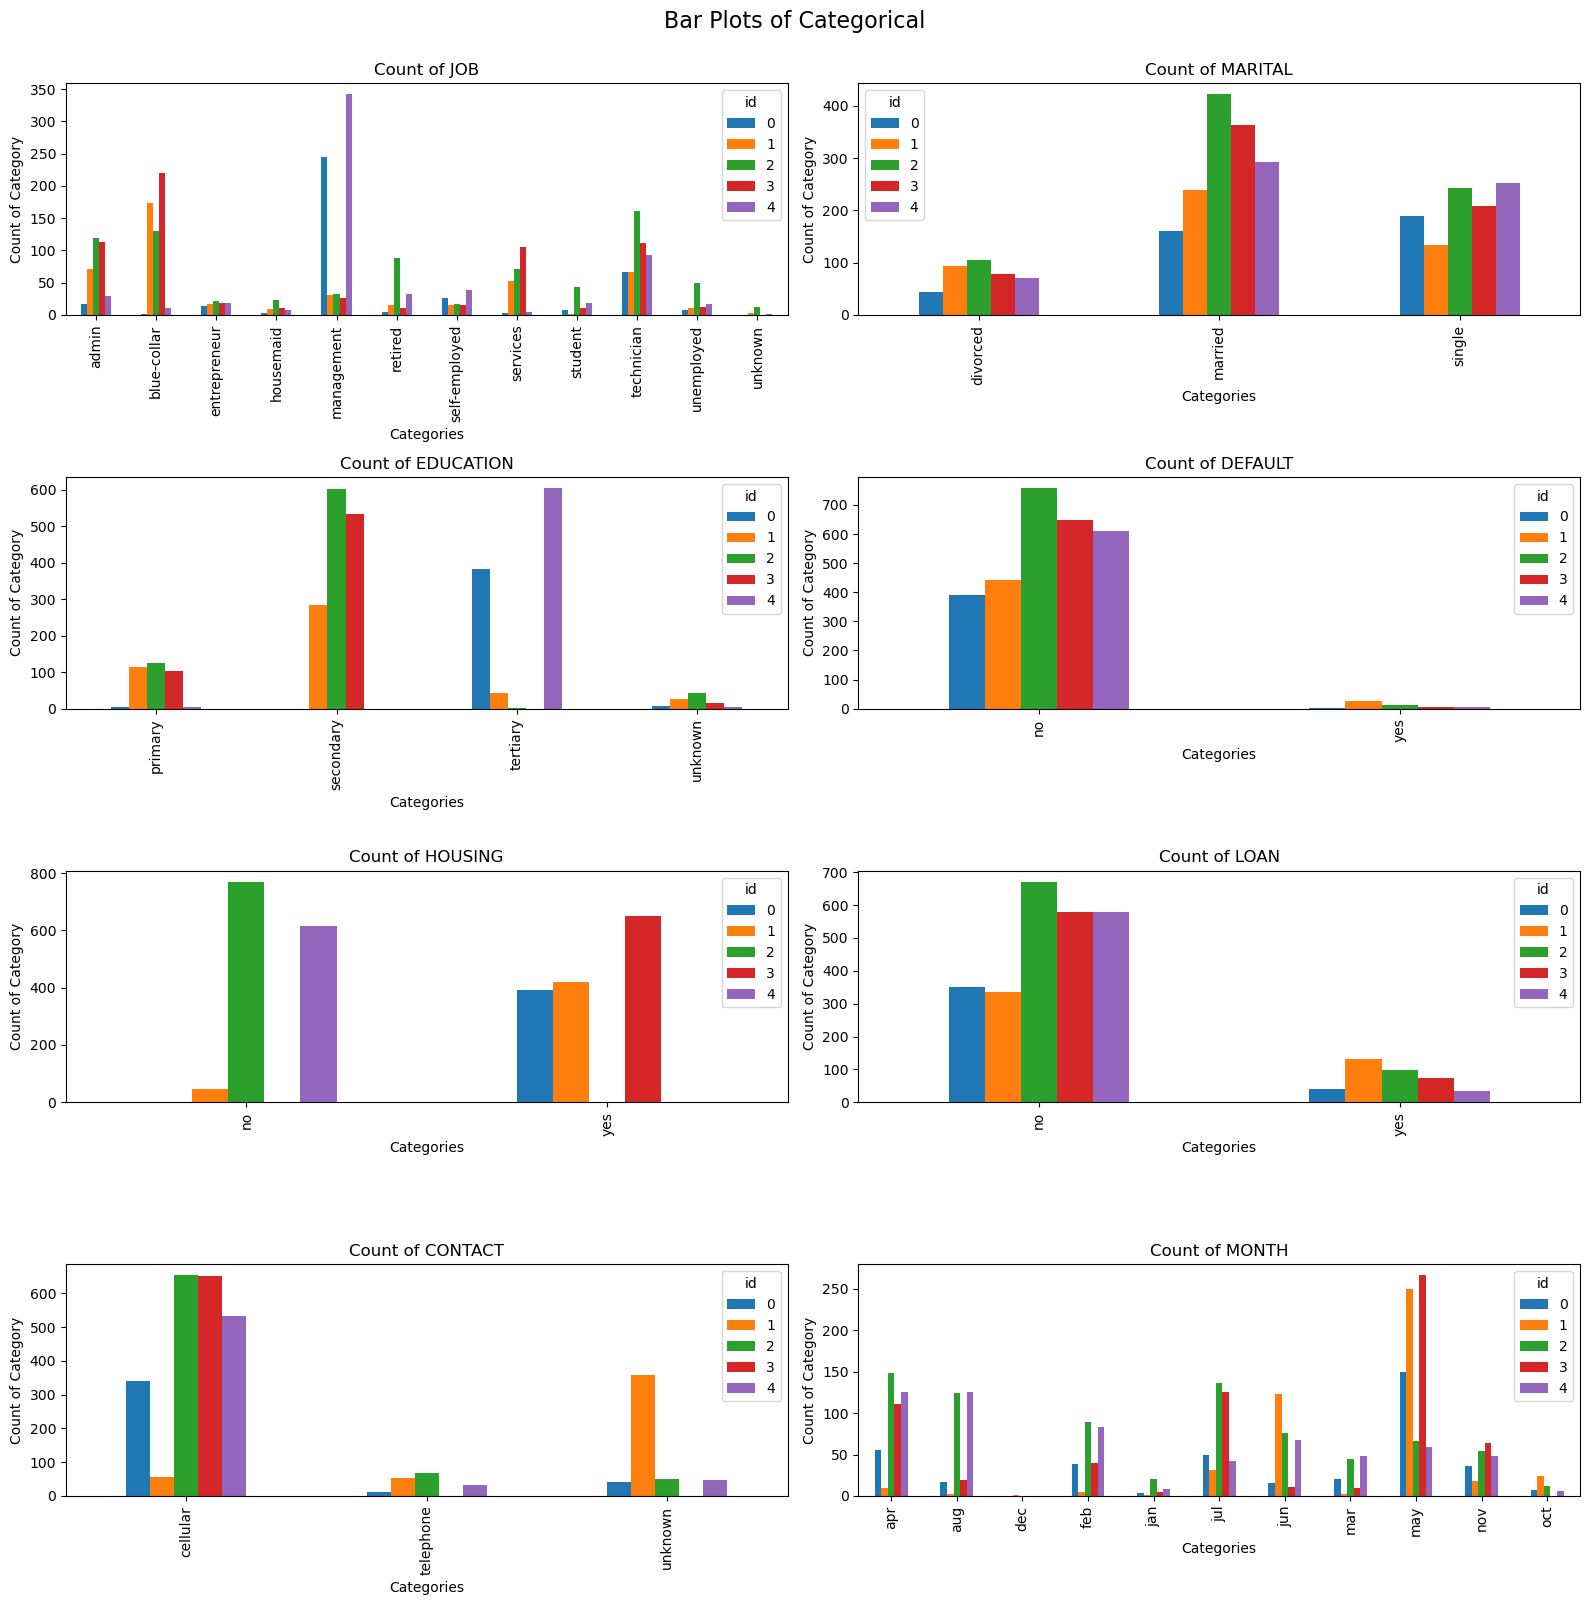

In [83]:
# Bar plots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes_flat = axes.flatten()

for ax, column in zip(axes_flat, _cols_categorical):
    _group = label_df.groupby([column, 'id'])[column].count()
    _group.name = 'value'
    _data = _group.reset_index()

    _pivot = _data.pivot_table(
        index=_data.columns[0],
        columns=_data.columns[1],
        values='value'
        )

    _pivot.plot(kind='bar', stacked=False, ax=ax)

    ax.set_title(f'Count of {column.upper()}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count of Category')

fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

Seeing some different groups based on housing loans and education. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


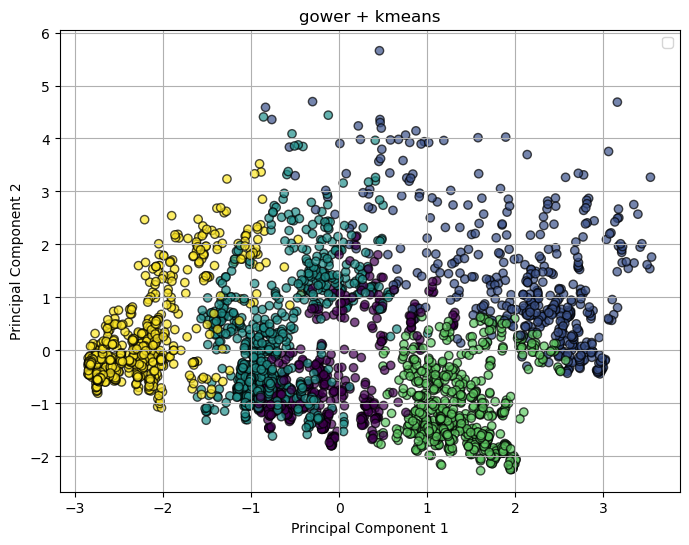

In [86]:
# 2D plot ---------------------------------------------------------------------
pca_gower_result['id'] = kmeans.labels_

plt.figure(figsize=(8, 6))

plt.scatter(
    pca_gower_result.loc[:, 0],
    pca_gower_result.loc[:, 1],
    c=pca_gower_result['id'],
    cmap='viridis',
    edgecolor='k',
    alpha=0.7
    )

plt.title('gower + kmeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# -----------------------------------------------------------------------------

Some different groups are seen to be forming, but still not very distinct.

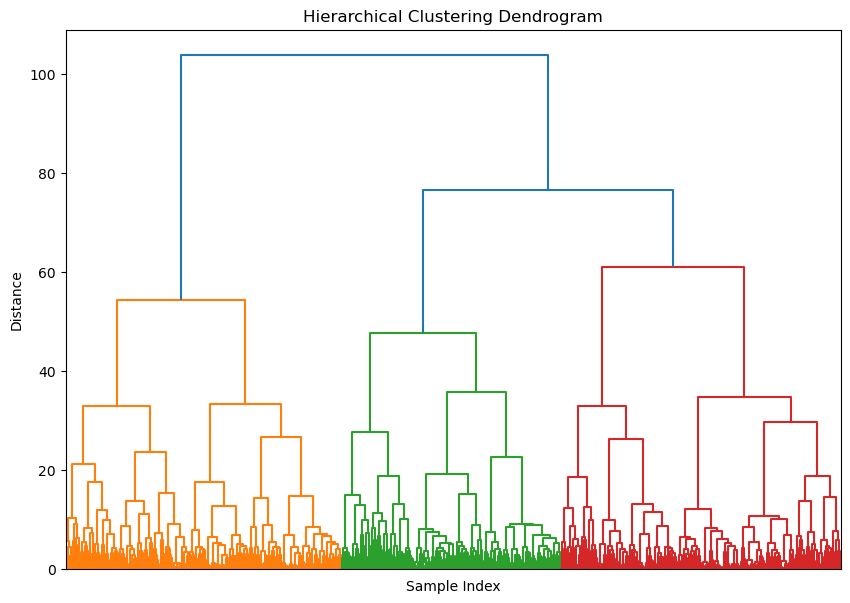

In [87]:
# gower + hierarchical --------------------------------------------------------
Z = sch.linkage(gower_distance_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(Z, no_labels=True)  # Suppress default labels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

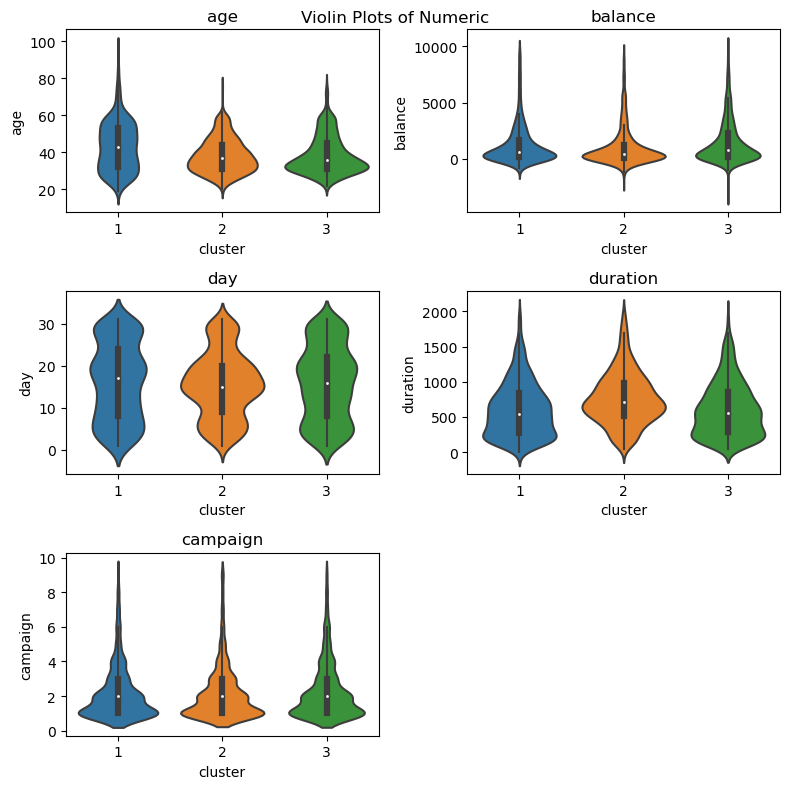

In [88]:
# Apply flat clustering
'''
At around height 60, we see the three groups form. So we set our clusters around
that height.
'''
clusters = fcluster(Z, t=65, criterion='distance')

# Add the hierarchical cluster labels to the dataframe
label_df['cluster'] = clusters
label_df['cluster'] = label_df['cluster'].replace({2: 1, 1: 2})

# violin plots
fig_violin, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    try:

        _col = _cols_numerical[i]

        cutoff = {
            'balance': 10000,
            'duration': 2000,
            'campaign': 10
            }

        if _col in cutoff.keys():

            rows = label_df[_col] < int(cutoff[_col])
            _ydata = label_df.loc[rows, _col]
            _xdata = label_df.loc[rows, 'cluster']

        else:
            _ydata = label_df.loc[:, _col]
            _xdata = label_df['cluster']

        sns.violinplot(x=_xdata, y=_ydata, ax=ax)
        ax.set_title(f"{_col}")

    except Exception:
        ax.axis('off')

plt.tight_layout()
fig_violin.suptitle("Violin Plots of Numeric")
plt.show()

Again, the most noticeable differences are in age and duration. Note that at one point I had used 3 clusters instead of 5 in the prior kmeans model, and when comparing this model it showed that the groups were basically identically. This is interesting since kmeans and this hierarchical algorithm work very differently, but were able to come to very similar conclusions in how groups should be formed.

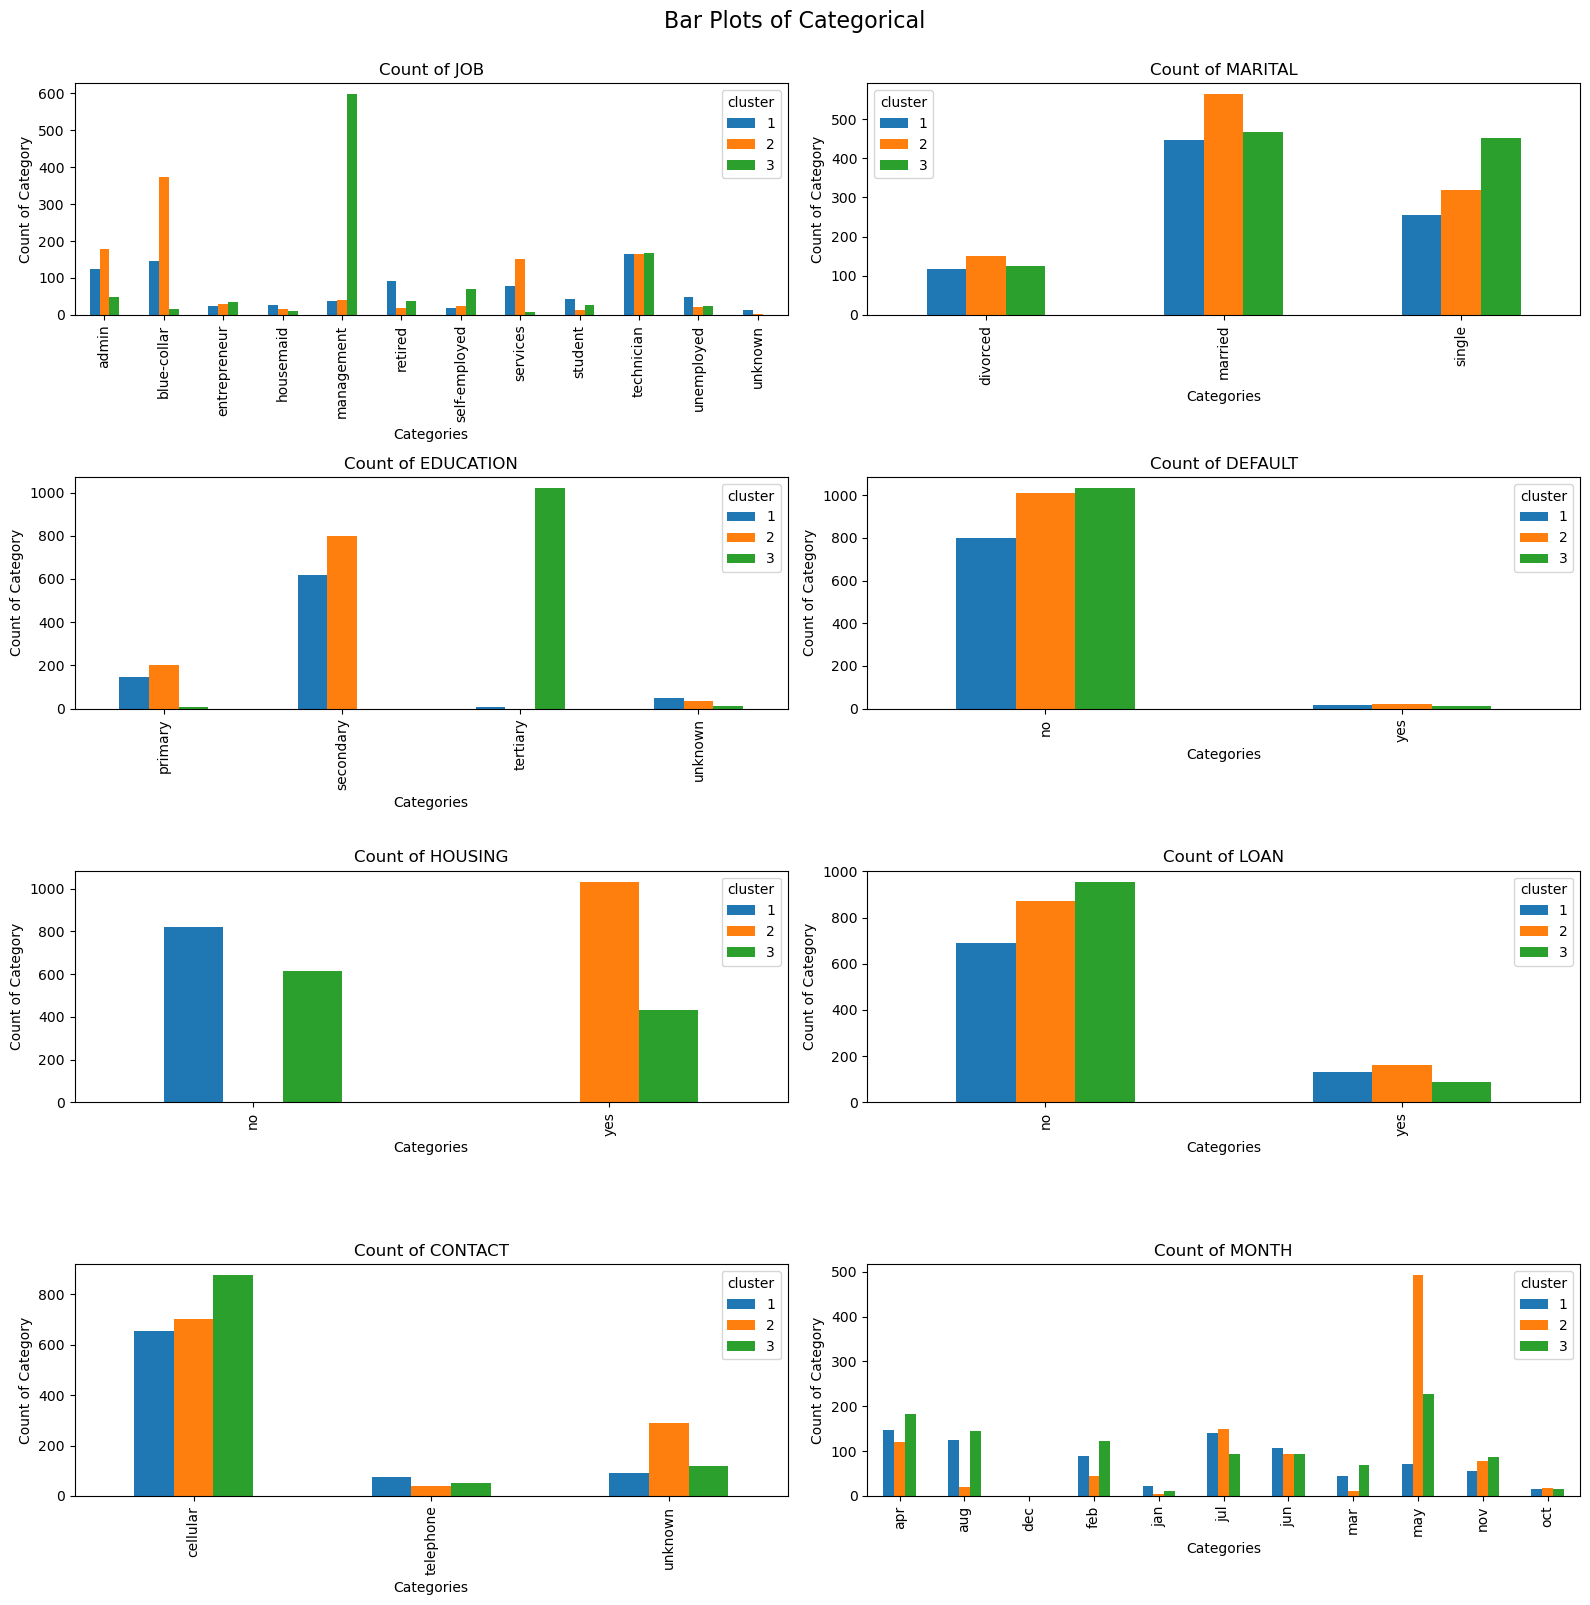

In [89]:
# Bar plots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes_flat = axes.flatten()

for ax, column in zip(axes_flat, _cols_categorical):
    _group = label_df.groupby([column, 'cluster'])[column].count()
    _group.name = 'value'
    _data = _group.reset_index()

    _pivot = _data.pivot_table(
        index=_data.columns[0],
        columns=_data.columns[1],
        values='value'
        )

    _pivot.plot(kind='bar', stacked=False, ax=ax)

    ax.set_title(f'Count of {column.upper()}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count of Category')

fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

Same differences as before in housing and education for some groups.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


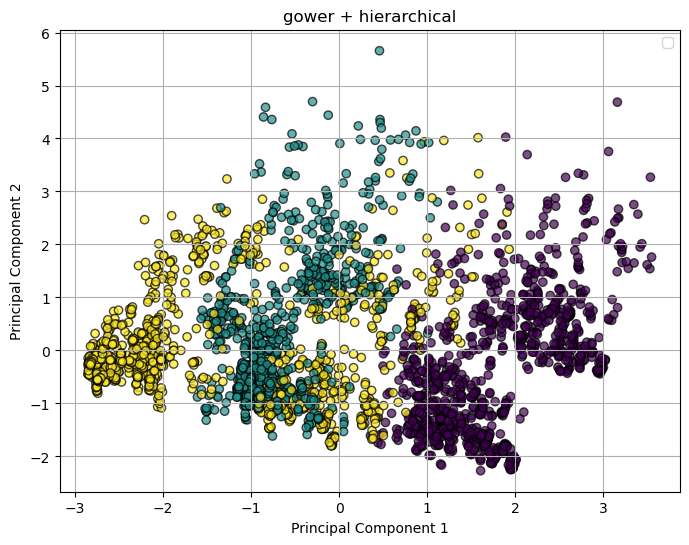

In [90]:
# 2D plot
pca_gower_result['cluster'] = clusters

plt.figure(figsize=(8, 6))

plt.scatter(
    pca_gower_result.loc[:, 0],
    pca_gower_result.loc[:, 1],
    c=pca_gower_result['cluster'],
    cmap='viridis',
    edgecolor='k',
    alpha=0.7
    )

plt.title('gower + hierarchical')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# -----------------------------------------------------------------------------

The groupings are pretty messy, especially group yellow.

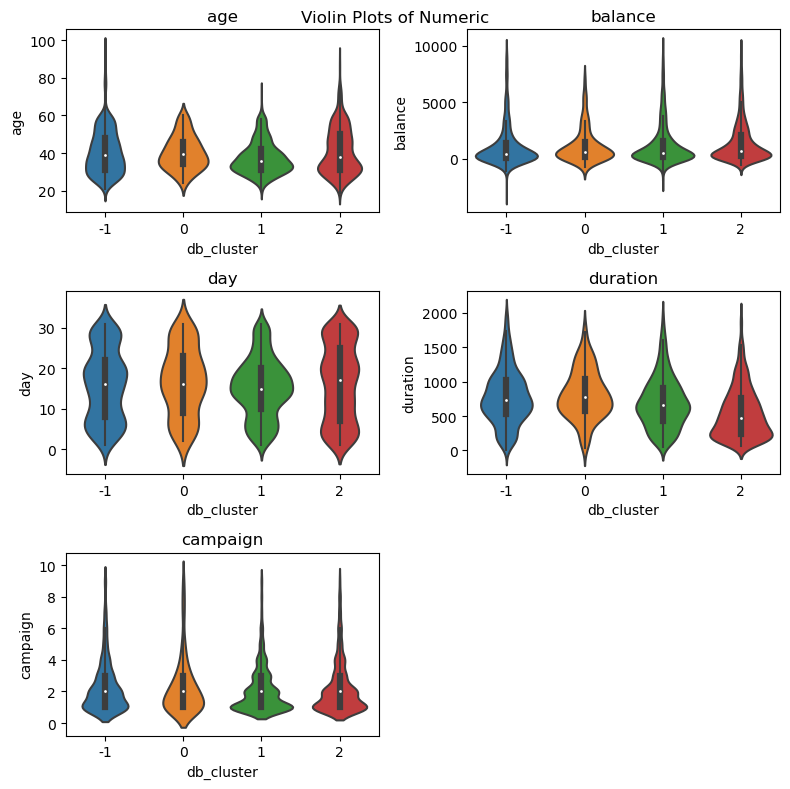

In [50]:
# gower + DBSCAN --------------------------------------------------------------

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=2.25, min_samples=125, n_jobs=-1)
labels = dbscan.fit_predict(gower_distance_matrix)

# Add cluster labels to dataset
label_df['db_cluster'] = labels

# violin plots
fig_violin, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    try:

        _col = _cols_numerical[i]

        cutoff = {
            'balance': 10000,
            'duration': 2000,
            'campaign': 10
            }

        if _col in cutoff.keys():

            rows = label_df[_col] < int(cutoff[_col])
            _ydata = label_df.loc[rows, _col]
            _xdata = label_df.loc[rows, 'db_cluster']

        else:
            _ydata = label_df.loc[:, _col]
            _xdata = label_df['db_cluster']

        sns.violinplot(x=_xdata, y=_ydata, ax=ax)
        ax.set_title(f"{_col}")

    except Exception:
        ax.axis('off')

plt.tight_layout()
fig_violin.suptitle("Violin Plots of Numeric")
plt.show()

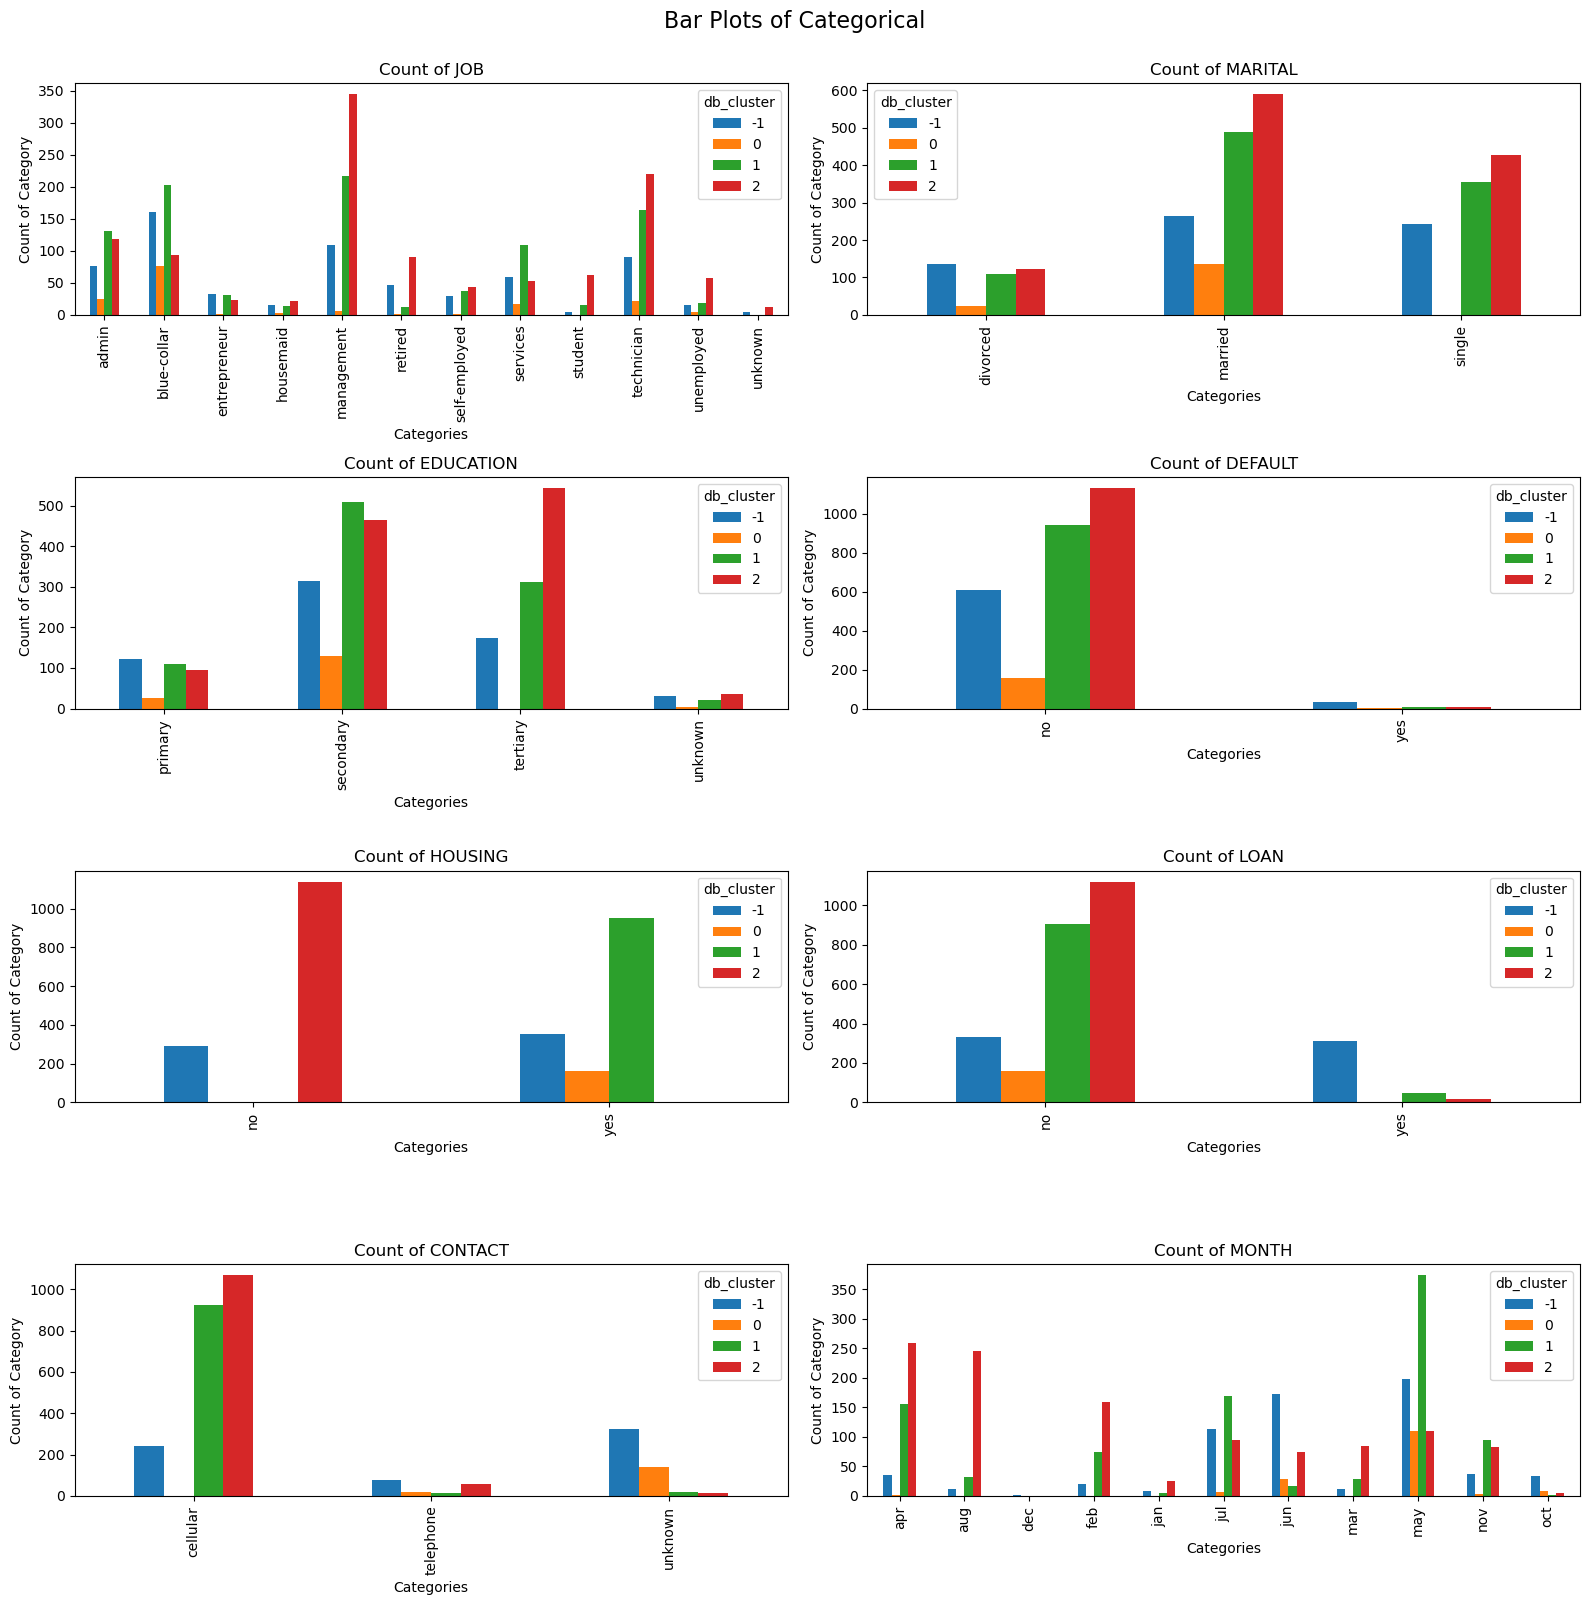

In [51]:
# Bar plots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes_flat = axes.flatten()

for ax, column in zip(axes_flat, _cols_categorical):
    _group = label_df.groupby([column, 'db_cluster'])[column].count()
    _group.name = 'value'
    _data = _group.reset_index()

    _pivot = _data.pivot_table(
        index=_data.columns[0],
        columns=_data.columns[1],
        values='value'
        )

    _pivot.plot(kind='bar', stacked=False, ax=ax)

    ax.set_title(f'Count of {column.upper()}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count of Category')

fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

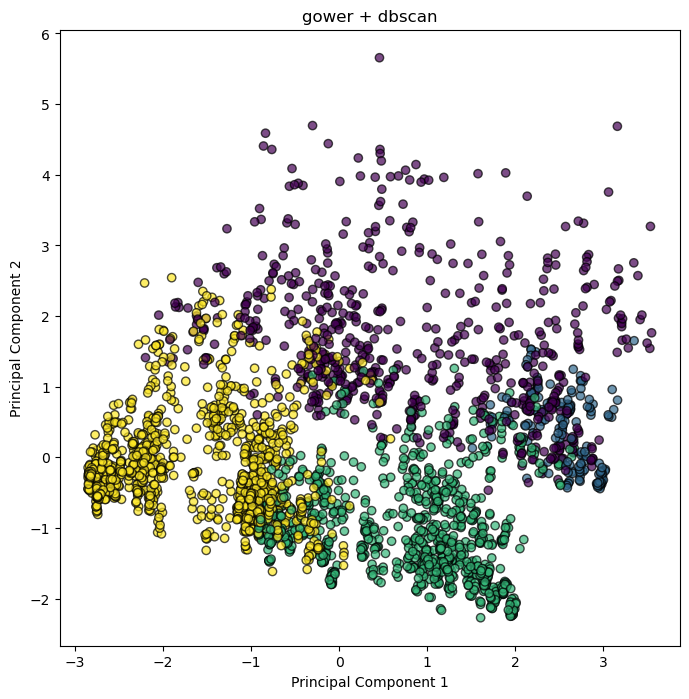

In [52]:
# 2d plot
pca_gower_result['db_cluster'] = labels

plt.figure(figsize=(8, 8))

plt.scatter(
    pca_gower_result.loc[:, 0],
    pca_gower_result.loc[:, 1],
    c=pca_gower_result['db_cluster'],
    cmap='viridis',
    edgecolor='k',
    alpha=0.7
    )

plt.title('gower + dbscan')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

DBscan is able to define the groups a little bit better than hierarchical. But the space overall is still very irregular and had to note any truly distinct clusters.

### 4.4C More Feature Engineering

At this point, I tried removing features that were ubiquitous among groups or at least close to identical.
- loan: 2516 out of 2896 have no loan (86%), in prior plots we don't see different groups having largely different loan amounts.
- contact: majority are just cell phone, and the rest are 'unknown', not useful.
- default: majority have no defaults, no groups in prior plots seems to indicate anything useful.

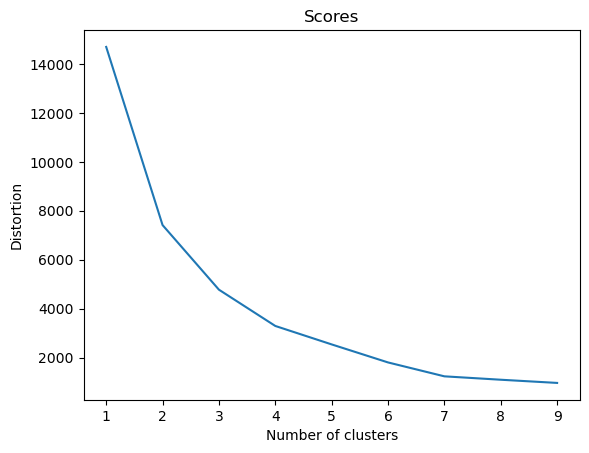

'\nWith the gower+pca data, it seems like 7 groups is most optimal.\n'

In [101]:
# %% [15] More Feature Engineering

features_describe = return_common_features(df_subscribers)

subscribers_clean = df_subscribers.drop(
    columns=['loan', 'contact', 'default']
    )

subscribers_clean_encoded = preprocessing.fit_transform(subscribers_clean)

subscribers_clean_encoded_df = pd.DataFrame(
    subscribers_clean_encoded,
    columns=preprocessing.get_feature_names_out(),
    index=df_subscribers.index)

gower_distance_matrix = gower.gower_matrix(subscribers_clean_encoded_df)
pca = PCA(n_components=2)
pca_gower_clean_result = pca.fit_transform(gower_distance_matrix)

# Optimal Clusters ------------------------------------------------------------
distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(pca_gower_clean_result)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 10), distortions)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Scores')
plt.show()
# -----------------------------------------------------------------------------

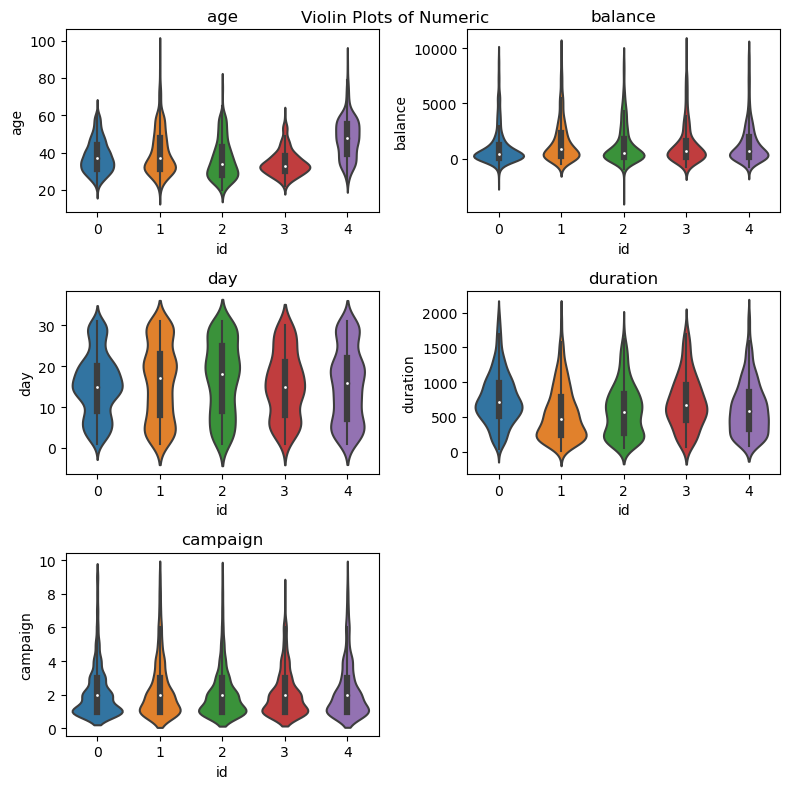

In [102]:
# Convert to DF ---------------------------------------------------------------
'''
To make adding labels, ids, clusters, etc, easier.
'''
pca_gower_clean_result = pd.DataFrame(pca_gower_clean_result)
# -----------------------------------------------------------------------------

# gower + kmeans -------------------------------------------------------------

kmeans = KMeans(n_clusters=5, random_state=seed)
kmeans.fit(pca_gower_clean_result)

label_df = subscribers_clean.copy()
label_df['id'] = kmeans.labels_
pca_gower_clean_result['id'] = kmeans.labels_

# Violin
fig_violin, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    try:

        _col = _cols_numerical[i]

        cutoff = {
            'balance': 10000,
            'duration': 2000,
            'campaign': 10
            }

        if _col in cutoff.keys():

            rows = label_df[_col] < int(cutoff[_col])
            _ydata = label_df.loc[rows, _col]
            _xdata = label_df.loc[rows, 'id']

        else:
            _ydata = label_df.loc[:, _col]
            _xdata = label_df['id']

        sns.violinplot(x=_xdata, y=_ydata, ax=ax)
        ax.set_title(f"{_col}")

    except Exception:
        ax.axis('off')

plt.tight_layout()
fig_violin.suptitle("Violin Plots of Numeric")
plt.show()

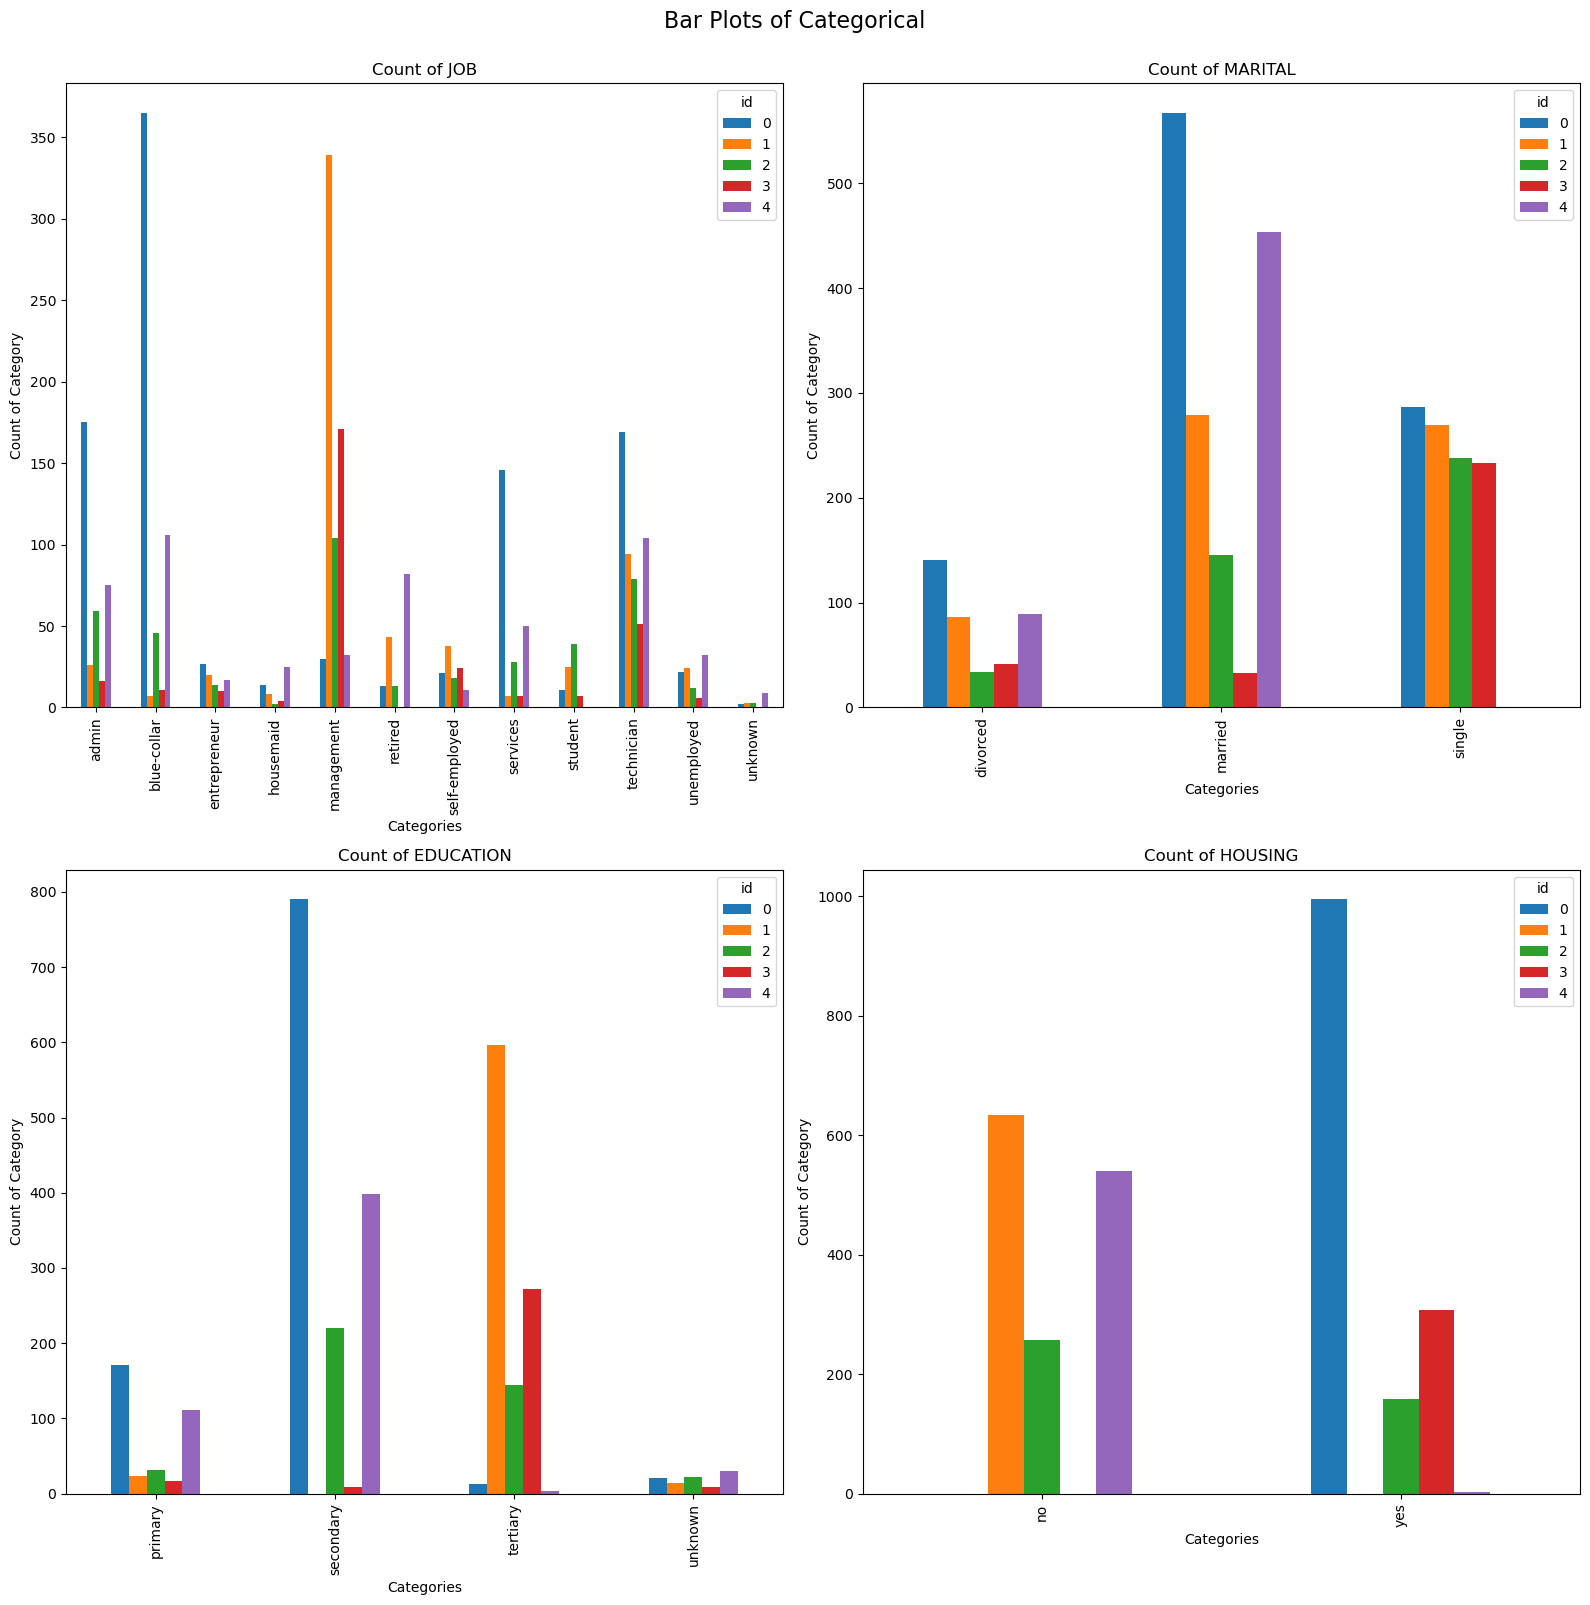

In [94]:
# Bar plots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes_flat = axes.flatten()

for ax, column in zip(axes_flat, ['job', 'marital', 'education', 'housing']):
    try:
        _group = label_df.groupby([column, 'id'])[column].count()
        _group.name = 'value'
        _data = _group.reset_index()

        _pivot = _data.pivot_table(
            index=_data.columns[0],
            columns=_data.columns[1],
            values='value'
            )

        _pivot.plot(kind='bar', stacked=False, ax=ax)

        ax.set_title(f'Count of {column.upper()}')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Count of Category')
    except Exception:
        ax.axis('off')

fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


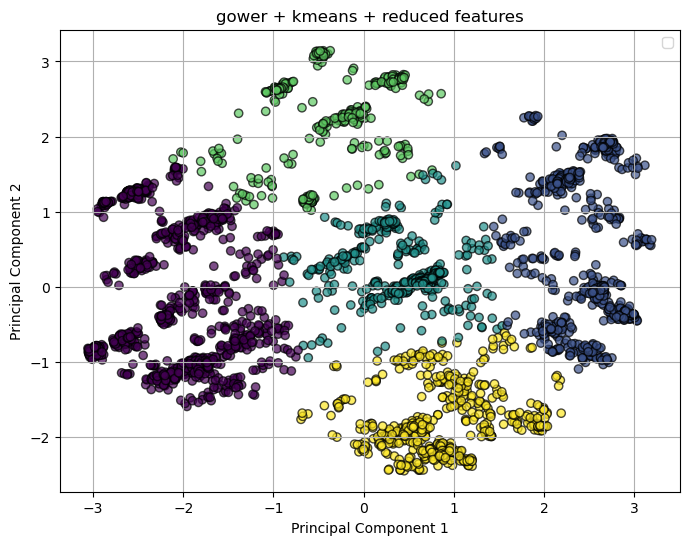

In [103]:
# 2D plot ---------------------------------------------------------------------
plt.figure(figsize=(8, 6))

plt.scatter(
    pca_gower_clean_result.loc[:, 0],
    pca_gower_clean_result.loc[:, 1],
    c=pca_gower_clean_result['id'],
    cmap='viridis',
    edgecolor='k',
    alpha=0.7
    )

plt.title('gower + kmeans + reduced features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# -----------------------------------------------------------------------------

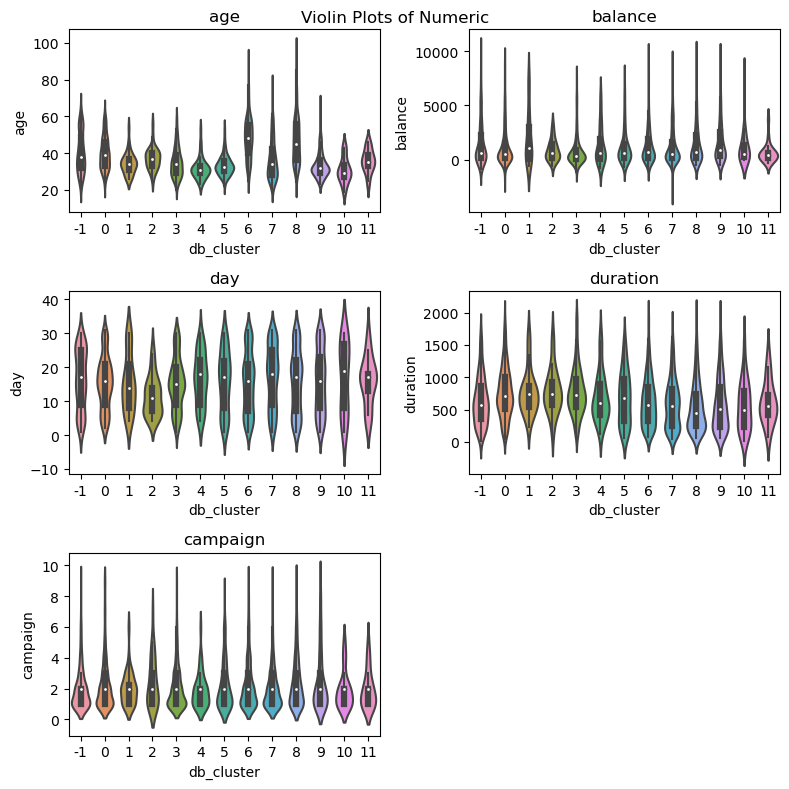

In [104]:
# DBSCAN ----------------------------------------------------------------------
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=25, n_jobs=-1)

pca_gower_clean_result = pca.fit_transform(gower_distance_matrix)
labels = dbscan.fit_predict(pca_gower_clean_result)
pca_gower_clean_result = pd.DataFrame(pca_gower_clean_result)
pca_gower_clean_result['id'] = kmeans.labels_


# Add cluster labels to dataset
label_df['db_cluster'] = labels

# violin plots
fig_violin, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    try:

        _col = _cols_numerical[i]

        cutoff = {
            'balance': 10000,
            'duration': 2000,
            'campaign': 10
            }

        if _col in cutoff.keys():

            rows = label_df[_col] < int(cutoff[_col])
            _ydata = label_df.loc[rows, _col]
            _xdata = label_df.loc[rows, 'db_cluster']

        else:
            _ydata = label_df.loc[:, _col]
            _xdata = label_df['db_cluster']

        sns.violinplot(x=_xdata, y=_ydata, ax=ax)
        ax.set_title(f"{_col}")

    except Exception:
        ax.axis('off')

plt.tight_layout()
fig_violin.suptitle("Violin Plots of Numeric")
plt.show()

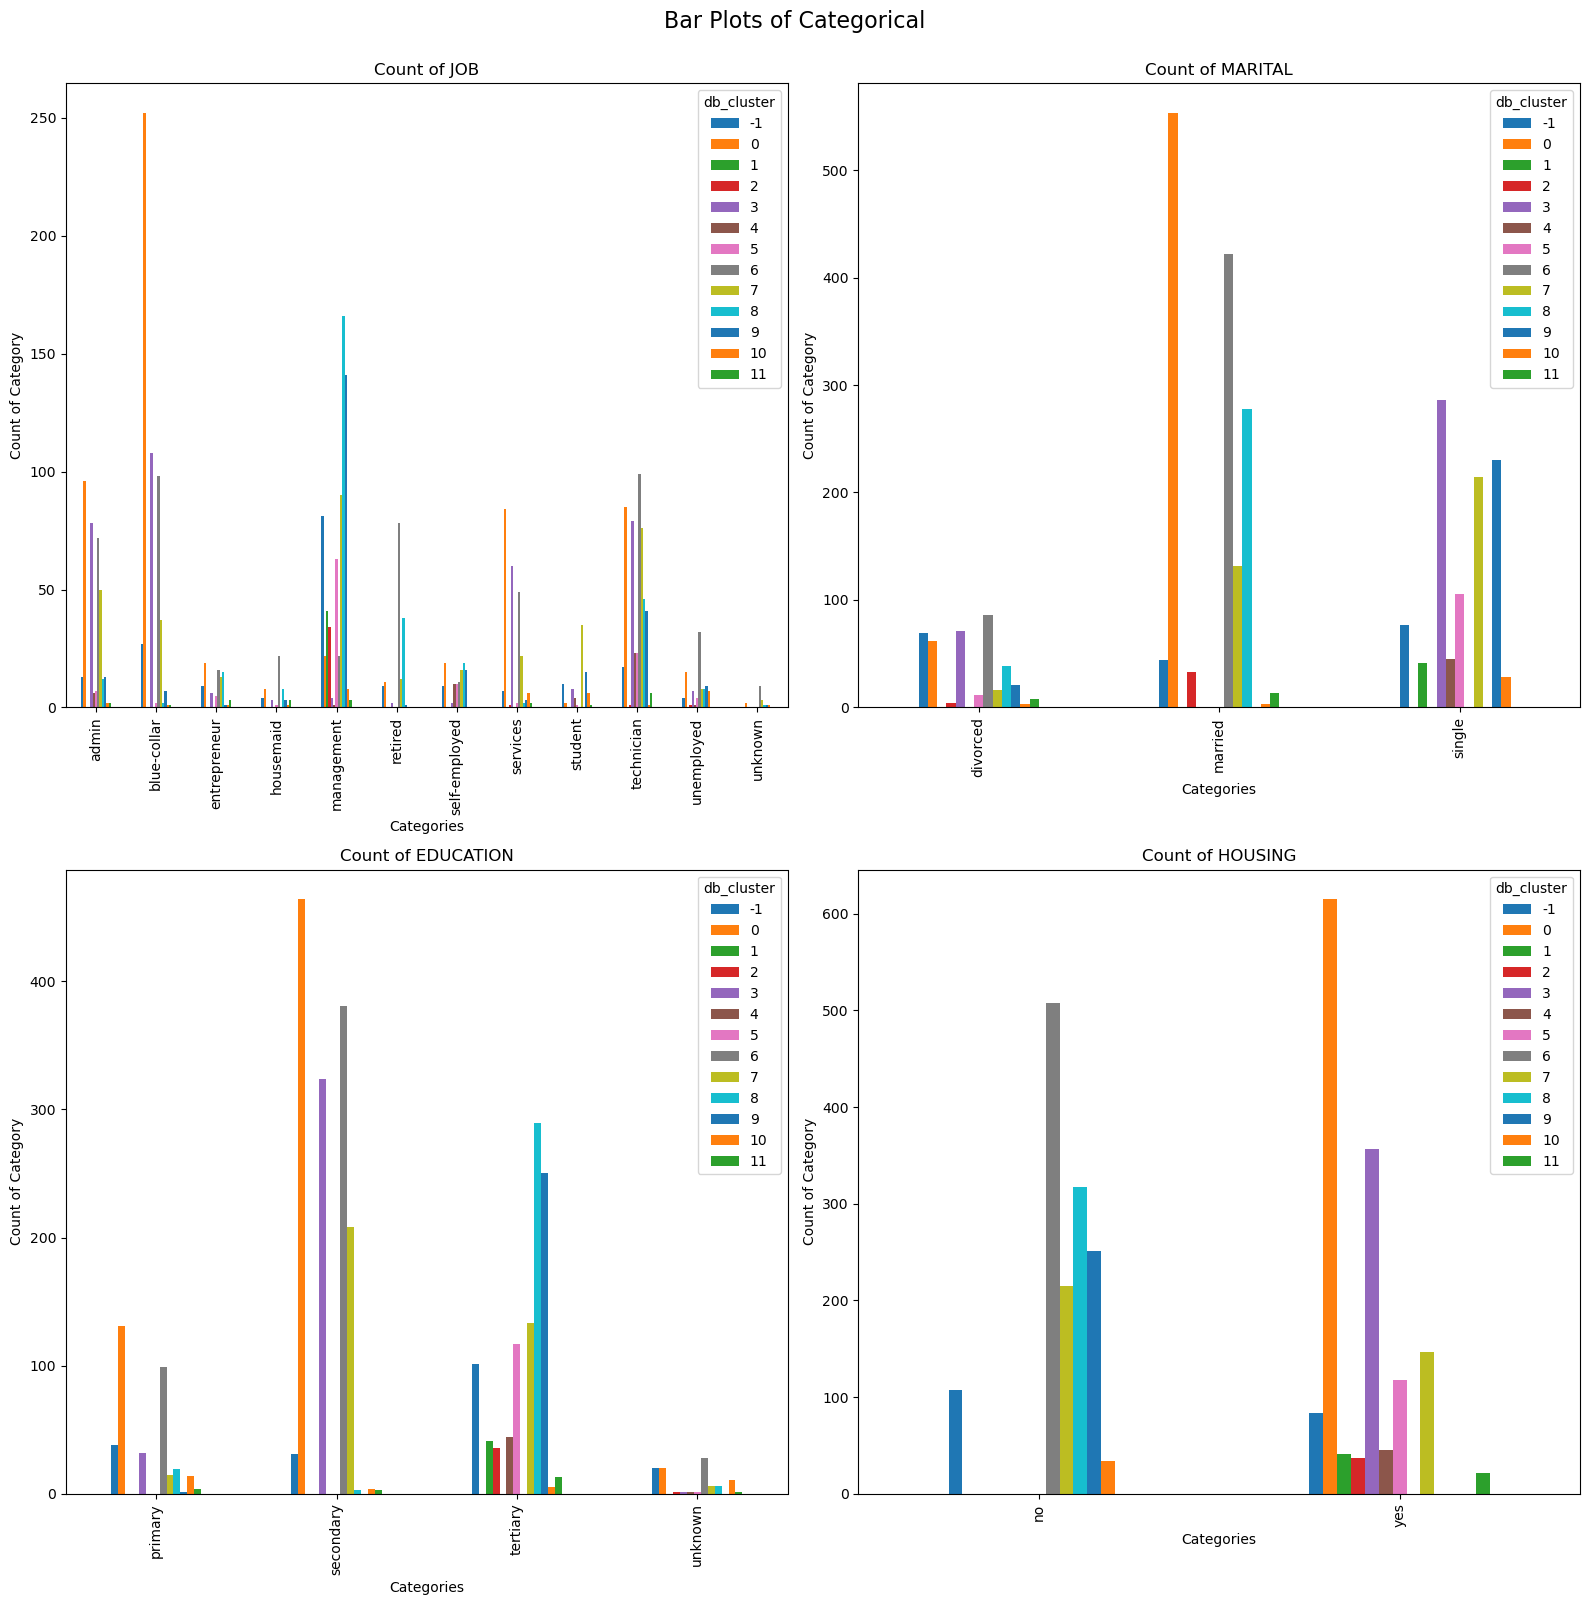

In [105]:
# Bar plots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes_flat = axes.flatten()

for ax, column in zip(axes_flat, ['job', 'marital', 'education', 'housing']):
    try:
        _group = label_df.groupby([column, 'db_cluster'])[column].count()
        _group.name = 'value'
        _data = _group.reset_index()

        _pivot = _data.pivot_table(
            index=_data.columns[0],
            columns=_data.columns[1],
            values='value'
            )

        _pivot.plot(kind='bar', stacked=False, ax=ax)

        ax.set_title(f'Count of {column.upper()}')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Count of Category')
    except Exception:
        ax.axis('off')

fig.suptitle("Bar Plots of Categorical", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


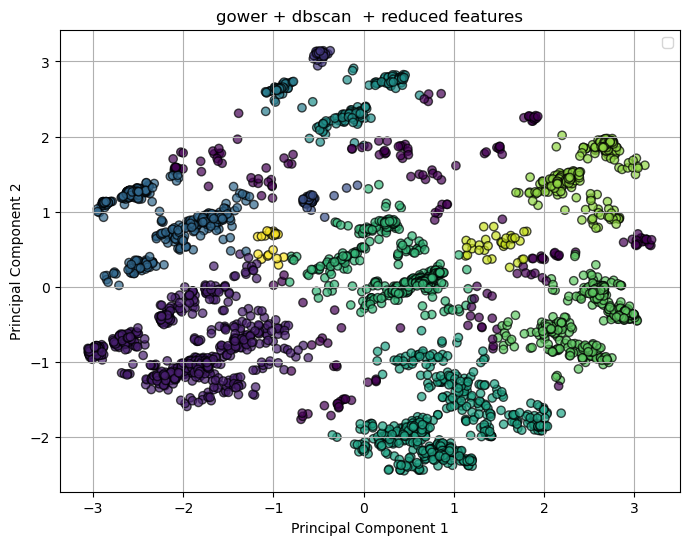

In [106]:
# Add cluster labels to dataset
label_df['db_cluster'] = labels

# 2d plot
pca_gower_clean_result['db_cluster'] = labels

plt.figure(figsize=(8, 6))

plt.scatter(
    pca_gower_clean_result.loc[:, 0],
    pca_gower_clean_result.loc[:, 1],
    c=pca_gower_clean_result['db_cluster'],
    cmap='viridis',
    edgecolor='k',
    alpha=0.7
    )

plt.title('gower + dbscan  + reduced features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

I do start seeing some very small clusters forming, but overall it's still very irregular and hard to distinctly create groups. And even when creating and comparing groups, the differences become minute and negligible as we try to better measure the differences.

# 5. Conclusion

My overall analysis reveals these key insights into predicting and segmenting potential subscribers.

    Exploratory Analysis:
    Duration appears to be the strongest predictor of conversions. While certain groups (e.g., married individuals, those with secondary education, and those without defaults) exhibit higher subscription rates, overall conversion remains low. Violin plots suggest a relationship between longer call duration and higher conversion, though causality remains uncertain at this stage.

    Regression Findings:
    Individuals with lower risk tolerance (e.g., unemployed, older, debt-free, or with higher balances) are more likely to subscribe. It's also likely that duration is leaking the target rather than explaining.

    Machine Learning:
    A two-layer classification model effectively reduced calling time while maintaining high accuracy (~82%). By initially trimming unlikely subscribers and applying a predictive model, I saved approximately 2367 days of call time while securing 1,658 subscribers. The trade-off is a loss of 822 subscribers, but with significantly reduced effort. Thus the actual implementation of this approach would depend on an acceptable trade-off between call time reduction and subscriber gain; how much time saved is worth per subscriber loss.

    Segmentation Insights:
    K-means clustering was best at identifying three groups based on call duration, balance, and number of campaign calls. Group 1 (middle-aged, longer calls) requires more engagement, Group 2 (younger, shorter calls) makes quicker decisions, and Group 3 (older, varied balances) shows inconsistent call responses. Alternative distance metrics (Gower) and additional feature engineering enhanced visual separation but did not significantly improve interpretability.

Overall, these findings indicate that machine learning can optimize call targeting and significantly improve efficiency while maintaining strong conversion rates. While segmenting callers and tailoring strategies to each group may enhance conversions but ultimately remains unclear.